In [1]:
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate 
sys.path.append(r'C:\Chuji\Code_and_Data\MyCode')

import Circuit_Simulator 
import PulseGenerator as PG
from toolfunc import *
from toolfunc.adia_analysis import *
from toolfunc.pulse_filter import *
import scipy.optimize as sci_op
from toolfunc import DE

{'Q1_freq': '6000.0MHz', 'Q1_anhar': '-125.0MHz', 'Q2_freq': '8500.0MHz', 'Q2_anhar': '-150.0MHz', 'Q3_freq': '5400.0MHz', 'Q3_anhar': '-125.0MHz', 'g12': '128.5457MHz', 'g13': '8.5381MHz', 'g23': '121.9492MHz'}


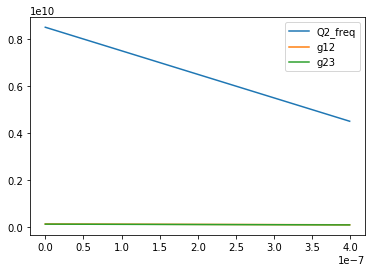

In [2]:
raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='ground',sampling_rate=1e9)
raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)

flux_pulse = np.linspace(0/7.5,4/7.5,400)
freq_array = 8.5e9-flux_pulse * (8.5e9 - 1e9)

raw_config.setValue('Q1 f01_max',6.0e9)
raw_config.setValue('Q2 f01_max',8.5e9)
raw_config.setValue('Q3 f01_max',5.4e9)
raw_config.setValue('Q1 f01_min',1e9)
raw_config.setValue('Q2 f01_min',1e9)
raw_config.setValue('Q3 f01_min',1e9)
raw_config.setValue('Q1 Ec',0.25e9)
raw_config.setValue('Q2 Ec',0.30e9)
raw_config.setValue('Q3 Ec',0.25e9)

raw_config.setValue('r12',0.018)
raw_config.setValue('r23',0.018)
raw_config.setValue('r13',0.0015)

raw_config.setValue('Q2 Voltage period',-1)
raw_config.setValue('Q2 Voltage operating point',0.00)
raw_config.setValue('Q2 Flux',flux_pulse)

simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
Simulator = Circuit_Simulator.Simulator(simu_config)
Simulator.show_pulse()

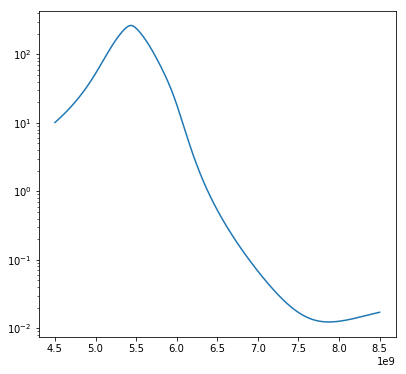

In [3]:
Simulator.performsimulation(solver_type=2,resample_factor=1,eigen_cloest_to_bare=False ,sort_by_maximum_overlap=True,gap=12e6)

fig = plt.figure(figsize=[6.4,6])
ax = fig.add_subplot(111)

eigen_trace = Simulator.EigenResult.get_Ener_gap_trace('101-100-001+000')
ax.plot(freq_array[0:400],-eigen_trace[0:400]/1e6)

ax.set_yscale('log')

In [4]:
%matplotlib qt

In [4]:
T_reflec=5e-9
f_term=2
lamb1 = [1.10843258, -0.48871076]
# lamb1 = [1.22936097,0.57456054]

total_len = gate_time + 12e-9+4*T_reflec
factor1=1.0 
factorc=1.0 
factor2=1.0 
factor_r=0.1

Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
Seq.clear_pulse(tips_on=False)
Seq.add_pulse('Adiabatic',t0=gate_time/2+12e-9/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=f_term,Lcoeff=np.array(lamb1),Q1_freq=6.0e9,
             CPLR_idle_freq=(7.87e9-6e9)*factorc+6e9,Q2_freq=6e9+(5.4e9-6e9)*factor2,constant_coupling=False,r1c=0.018*factor1,r2c=0.018*factor2,r12=0.0015*factorc,anhar_CPLR=-300e6*factorc,
             anhar_Q1=-250e6*factor1,anhar_Q2=-250e6*factor2,negative_amplitude=False,dfdV=(7.87e9-6e9)*factorc+6e9-1e9,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
Seq.add_filter('Gauss Low Pass',300e6)
Seq.add_filter('Reflection',*(factor_r,T_reflec))
flux_pulse=Seq.get_sequence()
plt.plot(flux_pulse)

NameError: name 'gate_time' is not defined

In [43]:
%matplotlib inline

In [5]:
def cost_func_distor(pulse_params,*args):
    gate_time,SRATE,f_term,factor_r,T_reflec=args
#     str_idx = bin(int(factor_idx))[2:6].zfill(4)
    factor1=1.0 
    factorc=1.0 
    factor2=1.0 
    
    lamb1 = pulse_params
    total_len = gate_time + 12e-9+4*T_reflec
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=gate_time/2+12e-9/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=f_term,Lcoeff=np.array(lamb1),Q1_freq=6.0e9,
                 CPLR_idle_freq=(7.87e9-6e9)*factorc+6e9,Q2_freq=6e9+(5.4e9-6e9)*factor2,constant_coupling=False,r1c=0.018*factor1,r2c=0.018*factor2,r12=0.0015*factorc,anhar_CPLR=-300e6*factorc,
                 anhar_Q1=-250e6*factor1,anhar_Q2=-250e6*factor2,negative_amplitude=False,dfdV=(7.87e9-6e9)*factorc+6e9-1e9,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
    Seq.add_filter('Reflection',*(factor_r,T_reflec))
    flux_pulse=Seq.get_sequence()

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    
    raw_config.setValue('Q1 f01_max',6.0e9)
    raw_config.setValue('Q2 f01_max',7.87e9)
    raw_config.setValue('Q3 f01_max',5.4e9)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',1e9)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',0.3e9)
    raw_config.setValue('Q3 Ec',0.25e9)
    raw_config.setValue('r12',0.018)
    raw_config.setValue('r23',0.018)
    raw_config.setValue('r13',0.0015)
    
    raw_config.setValue('Q2 Voltage period',-1)
    raw_config.setValue('Q2 Voltage operating point',0)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['000','001','100','101'])
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.get_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity

    print('coeff',pulse_params)
    print('error',1-fidelity)
    return 1 - fidelity

In [33]:
np.linspace(-0.1,0.1,21)
len(np.arange(0.5e-9,10.1e-9,0.5e-9))

20

In [ ]:
SRATE=6e9
gate_time=30e-9
f_terms=2

Tr_arr = np.arange(0e-9,30.1e-9,1e-9)
factor_r_arr = np.linspace(-0.1,0.1,21)

gate_fidelity_two = np.zeros([len(Tr_arr),len(factor_r_arr)])
gate_params_two_1 = np.zeros([len(Tr_arr),len(factor_r_arr)])
gate_params_two_2 = np.zeros([len(Tr_arr),len(factor_r_arr)])
raw_initial_seeds=np.array([0.8,-0.06])

ii = 0
for T_r in Tr_arr:
    jj = 0
    for factor_r in factor_r_arr:
        time_start = time.time()
        DATA = sci_op.minimize(cost_func_distor,raw_initial_seeds,args=(gate_time,SRATE,f_terms,factor_r,T_r), method='Nelder-Mead', options={'disp': True,'ftol':5e-5,'xtol':5e-5,'maxiter':50})

        gate_fidelity_two[ii,jj] = DATA.fun
        gate_params_two_1[ii,jj] = DATA.x[0]
        gate_params_two_2[ii,jj] = DATA.x[1]
        
        print('fidelity',DATA.fun)
        print(time.time()-time_start)
        np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\params_two1_distor_0ns_30ns.txt',gate_params_two_1 )
        np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\params_two2_distor_0ns_30ns.txt',gate_params_two_2 )
        np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\error_two_distor_0ns_30ns.txt',gate_fidelity_two )
        jj+=1
    ii+=1

coeff [ 0.8  -0.06]
error 0.002550164674472888
coeff [ 0.84 -0.06]
error 0.006462344945538656
coeff [ 0.8   -0.063]
error 0.00286641015207445
coeff [ 0.76  -0.063]
error 0.029630376694620986
coeff [ 0.82    -0.06075]
error 0.00017372685989902603
coeff [ 0.82    -0.05775]
error 0.0002677522044217673
coeff [ 0.84   -0.0585]
error 0.006728718075027507
coeff [ 0.81     -0.059625]
error 0.0003503102818086523
coeff [ 0.83     -0.058875]
error 0.002297453639256819
coeff [ 0.815     -0.0594375]
error 1.7843368958381234e-05
coeff [ 0.815     -0.0624375]
error 4.169174712442825e-05
coeff [ 0.81     -0.061125]
error 0.00041061803356634563
coeff [ 0.8175     -0.06084375]
error 3.3630253302496804e-05
coeff [ 0.8175     -0.05784375]
error 7.270552966476274e-05
coeff [ 0.815625   -0.06128906]
error 1.7689536844334164e-05
coeff [ 0.813125   -0.05988281]
error 8.936349158461532e-05
coeff [ 0.81640625 -0.06060352]
error 1.478494861617552e-05
coeff [ 0.81703125 -0.06245508]
error 1.4971403010544115e-05
c

coeff [ 0.84135157 -0.11106367]
error 1.2080787718193875e-05
coeff [ 0.84083219 -0.10967037]
error 1.1812148734691164e-05
coeff [ 0.84448627 -0.1212779 ]
error 1.1472574022675097e-05
coeff [ 0.85283319 -0.14727955]
error 1.427143324539415e-05
coeff [ 0.83796178 -0.1006164 ]
error 1.2051352422437489e-05
coeff [ 0.84109648 -0.11083063]
error 1.152441720808639e-05
coeff [ 0.84762097 -0.13149213]
error 1.1032242700603767e-05
coeff [ 0.85245056 -0.14692999]
error 1.1116601930316605e-05
coeff [ 0.85101076 -0.1419394 ]
error 1.2042766337261313e-05
coeff [ 0.84357505 -0.11860782]
error 1.1304977317494469e-05
coeff [ 0.84670975 -0.12882205]
error 1.0777993988186907e-05
coeff [ 0.84782149 -0.13259413]
error 1.0513584811966403e-05
coeff [ 0.85186741 -0.14547843]
error 1.0288998734009347e-05
coeff [ 0.85601359 -0.15891374]
error 1.0224469478181675e-05
coeff [ 0.85621412 -0.16001574]
error 9.356520607406438e-06
coeff [ 0.86051069 -0.17427755]
error 8.886188909484893e-06
coeff [ 0.86870279 -0.200597

coeff [ 0.84  -0.057]
error 1.5409595452209324e-05
coeff [ 0.86  -0.054]
error 0.005115439698996416
coeff [ 0.88  -0.057]
error 0.01917420329531161
coeff [ 0.82    -0.05925]
error 0.004229175693862719
coeff [ 0.86    -0.05775]
error 0.004564214903549302
coeff [ 0.83     -0.058875]
error 0.0011049481393444749
coeff [ 0.85     -0.058125]
error 0.0011141309018505297
coeff [ 0.835     -0.0586875]
error 0.00029573729055676345
coeff [ 0.845     -0.0583125]
error 0.00028009411636076287
coeff [ 0.8425     -0.05840625]
error 7.718338456896845e-05
coeff [ 0.8375     -0.05859375]
error 8.759831584659317e-05
coeff [ 0.84125    -0.05845312]
error 2.815931707245145e-05
coeff [ 0.83875    -0.05854687]
error 3.3748483264317564e-05
coeff [ 0.840625   -0.05847656]
error 1.6680064978680242e-05
coeff [ 0.840625   -0.05547656]
error 3.729996028201121e-05
coeff [ 0.84015625 -0.05886914]
error 1.3952755733681599e-05
coeff [ 0.83953125 -0.05739258]
error 1.4489558101016264e-05
coeff [ 0.8396875  -0.05926172]


coeff [ 0.85061995 -0.07149833]
error 1.3801338647145833e-05
coeff [ 0.85194535 -0.07569933]
error 1.3772461711525352e-05
coeff [ 0.85324004 -0.07997979]
error 1.3707305341004172e-05
coeff [ 0.85553647 -0.08739113]
error 1.3648509491925864e-05
coeff [ 0.85753994 -0.09365288]
error 1.3770052392114707e-05
coeff [ 0.86113105 -0.10534469]
error 1.3865189393835742e-05
coeff [ 0.85424178 -0.08311067]
error 1.3718606142631984e-05
coeff [ 0.85223831 -0.07684891]
error 1.3727905061711176e-05
coeff [ 0.85356371 -0.0810499 ]
error 1.3691896117662417e-05
coeff [ 0.8548584  -0.08533037]
error 1.364570631157136e-05
coeff [ 0.85516672 -0.08644022]
error 1.3640855278662656e-05
coeff [ 0.85713947 -0.09278144]
error 1.3570187009426249e-05
coeff [ 0.85892735 -0.09864721]
error 1.350032789393385e-05
coeff [ 0.8585576 -0.0976963]
error 1.3555677306764657e-05
coeff [ 0.86231822 -0.10990329]
error 1.3320760985147118e-05
coeff [ 0.86589398 -0.12163483]
error 1.3214551849660694e-05
coeff [ 0.86626373 -0.122585

coeff [ 0.86188582 -0.09043852]
error 1.3897061011847178e-05
coeff [ 0.86126338 -0.08841843]
error 1.3891452092407164e-05
coeff [ 0.86136014 -0.08872145]
error 1.389332995471726e-05
coeff [ 0.86132789 -0.08862044]
error 1.3893418616572895e-05
coeff [ 0.86147818 -0.08910526]
error 1.3894158591210015e-05
coeff [ 0.86141367 -0.08890325]
error 1.3886701737075846e-05
coeff [ 0.86164974 -0.08967089]
error 1.3889272398204255e-05
coeff [ 0.86156928 -0.08940828]
error 1.3891045782199463e-05
coeff [ 0.86148882 -0.08914566]
error 1.3892941373550016e-05
coeff [ 0.86144593 -0.08900426]
error 1.3891958456024867e-05
coeff [ 0.86152107 -0.08924667]
error 1.3891738400051423e-05
coeff [ 0.86163911 -0.08963049]
error 1.389138886898067e-05
fidelity 1.3883076188658805e-05
183.79304194450378
coeff [ 0.8  -0.06]
error 0.030637234504902078
coeff [ 0.84 -0.06]
error 0.0030738515043085
coeff [ 0.8   -0.063]
error 0.03160411652508732
coeff [ 0.84  -0.057]
error 0.0027618707749712534
coeff [ 0.86  -0.054]
error 0

coeff [ 0.85787945 -0.05072696]
error 1.403014105094691e-05
coeff [ 0.85759801 -0.04971797]
error 1.4025721273402958e-05
coeff [ 0.8570693  -0.04792655]
error 1.4049898630519309e-05
coeff [ 0.85710345 -0.0481531 ]
error 1.4010009499076936e-05
coeff [ 0.85646818 -0.04608373]
error 1.3985339737399016e-05
coeff [ 0.85618674 -0.04507474]
error 1.401754936092292e-05
coeff [ 0.85505691 -0.0414405 ]
error 1.3977273351395425e-05
coeff [ 0.85378636 -0.03730177]
error 1.3963162280417052e-05
coeff [ 0.85406779 -0.03831076]
error 1.3934513604429988e-05
coeff [ 0.85300832 -0.03492877]
error 1.3901944864058713e-05
coeff [ 0.85032649 -0.02614681]
error 1.3965956670025648e-05
coeff [ 0.85186191 -0.03113104]
error 1.3933676704658282e-05
coeff [ 0.85108387 -0.02875804]
error 1.3887250329802647e-05
coeff [ 0.84973263 -0.02448617]
error 1.3874129249802358e-05
coeff [ 0.85087904 -0.0282839 ]
error 1.3888968313113814e-05
coeff [ 0.84760335 -0.0178413 ]
error 1.3861168153717074e-05
coeff [ 0.84490087 -0.0092

coeff [0.83953985 0.01607844]
error 1.3448188606601796e-05
coeff [0.83805286 0.02096633]
error 1.3549981174643122e-05
coeff [0.83960631 0.01601759]
error 1.3462611458625595e-05
coeff [0.83636648 0.02603676]
error 1.3437935010740532e-05
coeff [0.83315989 0.0360255 ]
error 1.3444486108071807e-05
coeff [0.83630002 0.02609761]
error 1.339861373494955e-05
coeff [0.83464688 0.03113761]
error 1.3379036995830873e-05
coeff [0.83147352 0.04109593]
error 1.334721564816288e-05
coeff [0.82744036 0.05360468]
error 1.3288848207171355e-05
fidelity 1.3288848207171355e-05
173.8202509880066
coeff [ 0.8  -0.06]
error 0.03898005906634894
coeff [ 0.84 -0.06]
error 0.006412330175268877
coeff [ 0.8   -0.063]
error 0.04003368102080307
coeff [ 0.84  -0.057]
error 0.005955692750136188
coeff [ 0.86  -0.054]
error 0.00011626096349648396
coeff [ 0.9   -0.054]
error 0.01652395593698175
coeff [ 0.875  -0.0555]
error 0.0015107533290751318
coeff [ 0.895  -0.0495]
error 0.013275763300702459
coeff [ 0.85375  -0.057375]
e

coeff [ 0.86310849 -0.05258824]
error 1.4091530561310961e-05
coeff [ 0.86329741 -0.0529404 ]
error 1.4070421339718031e-05
coeff [ 0.86322272 -0.05260734]
error 1.4079279929579691e-05
coeff [ 0.8631164  -0.05252545]
error 1.4064907768007728e-05
coeff [ 0.8629433 -0.0520477]
error 1.408286413018267e-05
coeff [ 0.86313222 -0.05239986]
error 1.406088777333725e-05
coeff [ 0.86305754 -0.0520668 ]
error 1.4069679093342558e-05
coeff [ 0.86295121 -0.05198491]
error 1.4054927566675701e-05
coeff [ 0.86277812 -0.05150717]
error 1.4074298536503882e-05
coeff [ 0.86296703 -0.05185933]
error 1.4047544356521335e-05
coeff [ 0.86289235 -0.05152627]
error 1.4069321687570913e-05
coeff [ 0.86278603 -0.05144437]
error 1.4050954491917622e-05
coeff [ 0.86280185 -0.05131879]
error 1.4039148743538732e-05
coeff [ 0.86272717 -0.05098573]
error 1.404960607997996e-05
coeff [ 0.86298285 -0.05173374]
error 1.4106749366193938e-05
coeff [ 0.86283523 -0.05151672]
error 1.4038460729004498e-05
coeff [ 0.86267005 -0.0509761

coeff [0.82941811 0.05244484]
error 1.3112301835649376e-05
coeff [0.82555526 0.06450244]
error 1.3231608688268892e-05
coeff [0.82270186 0.07316639]
error 1.3299404877598064e-05
coeff [0.82987909 0.05112727]
error 1.3187018186422428e-05
coeff [0.83374195 0.03906967]
error 1.3219288155674747e-05
coeff [0.83169527 0.04542786]
error 1.3175091670647454e-05
coeff [0.83123429 0.04674544]
error 1.3137362708470768e-05
coeff [0.82895713 0.05376242]
error 1.3067957868706515e-05
coeff [0.82758805 0.05792969]
error 1.3013871160816315e-05
coeff [0.82577187 0.0636291 ]
error 1.307784274495738e-05
coeff [0.82394182 0.06911395]
error 1.3005847819047567e-05
coeff [0.82120367 0.0774485 ]
error 1.3054035254866925e-05
fidelity 1.3005847819047567e-05
161.58944058418274
coeff [ 0.8  -0.06]
error 0.03711355026058716
coeff [ 0.84 -0.06]
error 0.005599302930065941
coeff [ 0.8   -0.063]
error 0.038164629000695394
coeff [ 0.84  -0.057]
error 0.005176128463928231
coeff [ 0.86  -0.054]
error 3.540741154772764e-05
c

coeff [0.83826673 0.01045046]
error 1.3666273179002708e-05
coeff [0.83483851 0.02147489]
error 1.3634928784034273e-05
coeff [0.83102773 0.03345607]
error 1.3806978444774742e-05
coeff [0.8340734  0.02338839]
error 1.364722736696411e-05
coeff [0.83064518 0.03441282]
error 1.3633198844731353e-05
coeff [0.8268344  0.04639401]
error 1.3800945945496856e-05
coeff [0.83141029 0.03249932]
error 1.4059364075724723e-05
coeff [0.83340762 0.02566613]
error 1.3581195729472917e-05
coeff [0.82921429 0.03860406]
error 1.3544469133486281e-05
coeff [0.82640218 0.04716864]
error 1.3482182955715238e-05
coeff [0.82916462 0.03842195]
error 1.3619220446292601e-05
coeff [0.82953476 0.03741967]
error 1.3571012863700105e-05
coeff [0.82252932 0.05892218]
error 1.3379467304730497e-05
coeff [0.81709017 0.07555021]
error 1.3490464822352166e-05
coeff [0.81939674 0.06867116]
error 1.3537576736832868e-05
coeff [0.82193124 0.06085829]
error 1.3422867719437015e-05
coeff [0.81805838 0.07261183]
error 1.3471343518145495e-0

coeff [ 0.85006565 -0.05639166]
error 1.4023303270382925e-05
coeff [ 0.8500498  -0.05634461]
error 1.4022513250777635e-05
coeff [ 0.85006279 -0.05638676]
error 1.4022904169741501e-05
coeff [ 0.85003108 -0.05629267]
error 1.4029785646352266e-05
coeff [ 0.85005486 -0.05636324]
error 1.4022375229183481e-05
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 31
         Function evaluations: 61
fidelity 1.4022375229183481e-05
110.9225287437439
coeff [ 0.8  -0.06]
error 0.019198860318856092
coeff [ 0.84 -0.06]
error 0.00024516272915608983
coeff [ 0.8   -0.063]
error 0.019972639513542
coeff [ 0.84  -0.057]
error 0.00016155298258979656
coeff [ 0.86  -0.054]
error 0.0033286370062710624
coeff [ 0.88  -0.057]
error 0.015432121695293954
coeff [ 0.86    -0.05775]
error 0.002890319594947788
coeff [ 0.82    -0.05925]
error 0.006051143382362012
coeff [ 0.85     -0.058125]
error 0.00039699858526331955
coeff [ 0.83     -0.058875]
error 0.0021398604165112

coeff [ 0.83658599 -0.0593194 ]
error 1.3816406350120047e-05
coeff [ 0.83667717 -0.0596323 ]
error 1.381140577561002e-05
coeff [ 0.83674291 -0.0598177 ]
error 1.3803730560146832e-05
coeff [ 0.8368834  -0.06026965]
error 1.3792195577733146e-05
coeff [ 0.8370329  -0.06080273]
error 1.380131184591793e-05
coeff [ 0.83723913 -0.06144009]
error 1.3774738885641291e-05
coeff [ 0.8375201  -0.06234398]
error 1.3749729996903604e-05
coeff [ 0.8373706 -0.0618109]
error 1.3752577412762257e-05
coeff [ 0.8380073  -0.06388523]
error 1.3708574696069675e-05
coeff [ 0.83856926 -0.06569302]
error 1.3665872400370205e-05
coeff [ 0.83871876 -0.0662261 ]
error 1.3674636421434627e-05
coeff [ 0.83976791 -0.06957514]
error 1.3644323347494769e-05
coeff [ 0.84089182 -0.07319072]
error 1.3569723225637098e-05
coeff [ 0.84074232 -0.07265764]
error 1.3526349989301245e-05
coeff [ 0.84175409 -0.07587341]
error 1.3456088519880893e-05
coeff [ 0.84407666 -0.08337111]
error 1.329545121453446e-05
coeff [ 0.84683036 -0.0922101

coeff [ 0.89693125 -0.29674536]
error 2.5064015587439314e-06
coeff [ 0.90593595 -0.32876644]
error 9.008006413124825e-06
coeff [ 0.88886753 -0.26682109]
error 3.4766449406031796e-06
fidelity 2.5064015587439314e-06
161.88422679901123
coeff [ 0.8  -0.06]
error 0.002885868849392681
coeff [ 0.84 -0.06]
error 0.005909198577524699
coeff [ 0.8   -0.063]
error 0.003225309780321872
coeff [ 0.76  -0.063]
error 0.030651960526089428
coeff [ 0.82    -0.06075]
error 0.00010049753594876254
coeff [ 0.82    -0.05775]
error 0.00017035508638474361
coeff [ 0.84   -0.0585]
error 0.006163495863383162
coeff [ 0.81     -0.059625]
error 0.0004844317716184987
coeff [ 0.83     -0.058875]
error 0.001976524327803153
coeff [ 0.815     -0.0594375]
error 4.349325246677527e-05
coeff [ 0.815     -0.0624375]
error 8.777487922961846e-05
coeff [ 0.81     -0.061125]
error 0.0005553762957842823
coeff [ 0.8175     -0.06084375]
error 1.4609206207327752e-05
coeff [ 0.8175     -0.05784375]
error 3.19619262505455e-05
coeff [ 0.8

coeff [ 0.8  -0.06]
error 0.0018219585038679043
coeff [ 0.84 -0.06]
error 0.008598117234981495
coeff [ 0.8   -0.063]
error 0.002073331967833991
coeff [ 0.76  -0.063]
error 0.026676438741202624
coeff [ 0.82    -0.06075]
error 0.0007779269903580577
coeff [ 0.82    -0.05775]
error 0.0009455978928164521
coeff [ 0.84   -0.0585]
error 0.008903286382840325
coeff [ 0.81     -0.059625]
error 0.0002866106093170062
coeff [ 0.81     -0.062625]
error 0.0003388826499677311
coeff [ 0.8    -0.0615]
error 0.001945291856389142
coeff [ 0.815     -0.0609375]
error 0.00027224579670437343
coeff [ 0.815     -0.0579375]
error 0.0003336728662906019
coeff [ 0.81375    -0.05910937]
error 0.00025113261615905547
coeff [ 0.81875    -0.06042187]
error 0.0006160160182213659
coeff [ 0.8121875  -0.05982422]
error 0.00022657302132234047
coeff [ 0.8109375  -0.05799609]
error 0.0002391059577343535
coeff [ 0.809375   -0.05871094]
error 0.0003060640112390045
coeff [ 0.81265625 -0.05900977]
error 0.0002296271205638467
coeff 

coeff [ 0.86721786 -0.21013857]
error 2.9826019869894083e-05
coeff [ 0.87639641 -0.24156656]
error 1.757403149971193e-05
coeff [ 0.88979805 -0.28418625]
error 5.1043186174437594e-05
coeff [ 0.88018316 -0.25248987]
error 2.2441300749909132e-05
coeff [ 0.89183943 -0.29403601]
error 2.7882299448500625e-05
coeff [ 0.88506461 -0.27053211]
error 1.8108076835887665e-05
coeff [ 0.88127785 -0.2596088 ]
error 1.2906992804873063e-05
coeff [ 0.8818252  -0.26316827]
error 1.4604976932064417e-05
coeff [ 0.87260965 -0.23064325]
error 2.6939036298911923e-05
coeff [ 0.88195087 -0.2605599 ]
error 1.4368095004879677e-05
coeff [ 0.88683231 -0.27860214]
error 1.0917268981502914e-05
coeff [ 0.89205026 -0.29711993]
error 1.25770278027737e-05
coeff [ 0.8861593  -0.27765104]
error 9.202503051031208e-06
coeff [ 0.88826351 -0.28619661]
error 8.281540863297465e-06
coeff [ 0.89381797 -0.30518995]
error 7.134291522992164e-06
coeff [ 0.90008803 -0.32798052]
error 1.1785318437262937e-05
coeff [ 0.89524917 -0.31278443

coeff [ 0.85570908 -0.11654142]
error 5.911262982494225e-05
coeff [ 0.86161392 -0.13579737]
error 5.084166418989344e-05
coeff [ 0.86059944 -0.13375925]
error 5.0314639731929844e-05
coeff [ 0.86574343 -0.15148662]
error 4.2903693698082e-05
coeff [ 0.87806036 -0.19101759]
error 3.684089951705438e-05
coeff [ 0.89244205 -0.23839318]
error 6.923793810942325e-05
coeff [ 0.88218987 -0.20670683]
error 2.837846754988327e-05
coeff [ 0.89247784 -0.24216156]
error 3.138281452752523e-05
coeff [ 0.8945068 -0.2462378]
error 6.538217546370184e-05
coeff [ 0.87293427 -0.17517441]
error 3.4648633941869456e-05
coeff [ 0.87706378 -0.19086365]
error 2.9690055600051224e-05
coeff [ 0.88631937 -0.22239607]
error 2.259855787112297e-05
coeff [ 0.89301192 -0.2460069 ]
error 2.0773106760185733e-05
coeff [ 0.89813801 -0.26185007]
error 4.0360981366172055e-05
coeff [ 0.88233233 -0.20861026]
error 2.4950744522689305e-05
coeff [ 0.89315439 -0.24791033]
error 1.706210260110641e-05
coeff [ 0.89863665 -0.26851208]
error 

coeff [ 0.92263484 -0.34012124]
error 1.047455243363693e-05
coeff [ 0.92240047 -0.33929391]
error 1.0443035649787547e-05
coeff [ 0.92428407 -0.34694311]
error 1.0515350884809926e-05
coeff [ 0.92198925 -0.33771725]
error 1.0444590669567155e-05
coeff [ 0.92351913 -0.34386783]
error 1.0458721124262382e-05
coeff [ 0.92237172 -0.3392549 ]
error 1.043864742455991e-05
coeff [ 0.92307915 -0.34225217]
error 1.0441992770338082e-05
coeff [ 0.92290948 -0.3415126 ]
error 1.0438401611079229e-05
coeff [ 0.92364566 -0.34454888]
error 1.0446562042520924e-05
coeff [ 0.9226902  -0.34057839]
error 1.0437513566996515e-05
coeff [ 0.92249178 -0.33979982]
error 1.0439998857525445e-05
coeff [ 0.92295387 -0.34166834]
error 1.0437674053509483e-05
fidelity 1.0437513566996515e-05
182.30958080291748
coeff [ 0.8  -0.06]
error 0.024436275821720366
coeff [ 0.84 -0.06]
error 0.0012479186426372912
coeff [ 0.8   -0.063]
error 0.02531587481446851
coeff [ 0.84  -0.057]
error 0.0010496871225874616
coeff [ 0.86  -0.054]
erro

coeff [ 0.85486618 -0.05830046]
error 3.831155460309876e-05
coeff [ 0.85437378 -0.05702234]
error 3.898054451023647e-05
coeff [ 0.85461502 -0.05675606]
error 3.838075215356618e-05
coeff [ 0.85494461 -0.05784956]
error 3.81763339337704e-05
coeff [ 0.85523201 -0.05862531]
error 3.813142487163468e-05
coeff [ 0.85531639 -0.05926083]
error 3.788172494312292e-05
coeff [ 0.85566708 -0.06051321]
error 3.7670850208892936e-05
coeff [ 0.85619968 -0.06174695]
error 3.7602055174890125e-05
coeff [ 0.85694983 -0.06392464]
error 3.751424542530746e-05
coeff [ 0.85738489 -0.06581254]
error 3.67644105074838e-05
coeff [ 0.85846133 -0.06940615]
error 3.611313450913034e-05
coeff [ 0.85974408 -0.07281759]
error 3.641273599230832e-05
coeff [ 0.86125559 -0.0782991 ]
error 3.478595908246174e-05
coeff [ 0.86340847 -0.08548632]
error 3.3609212523377785e-05
coeff [ 0.86212572 -0.08207489]
error 3.417428694774127e-05
coeff [ 0.86707286 -0.09815506]
error 3.1633580968692954e-05
coeff [ 0.87137862 -0.11252952]
error 

coeff [ 0.91385693 -0.25106965]
error 2.007125819425415e-05
coeff [ 0.91131159 -0.24244143]
error 1.8594129685078897e-05
coeff [ 0.91634568 -0.26134765]
error 1.8676913228876657e-05
coeff [ 0.9153615  -0.25690649]
error 1.9912211698724924e-05
coeff [ 0.90702979 -0.22645363]
error 1.9003346380275232e-05
coeff [ 0.91003892 -0.23812732]
error 1.8705282375464094e-05
coeff [ 0.91432073 -0.25411512]
error 1.831637637739192e-05
coeff [ 0.9179662  -0.26794587]
error 1.8244366375430587e-05
coeff [ 0.91923887 -0.27225998]
error 1.917258987849113e-05
coeff [ 0.91233891 -0.24666048]
error 1.844199081246778e-05
coeff [ 0.91899352 -0.27216492]
error 1.8048094069689213e-05
coeff [ 0.92283448 -0.28702667]
error 1.8309838668240097e-05
coeff [ 0.92462081 -0.29345031]
error 1.9615567875663764e-05
coeff [ 0.91540939 -0.25835794]
error 1.8226380818942012e-05
coeff [ 0.9164367 -0.262577 ]
error 1.8127361120501284e-05
coeff [ 0.92002084 -0.27638398]
error 1.7939368207708917e-05
coeff [ 0.92232656 -0.285397  

coeff [ 0.86276611 -0.0557688 ]
error 1.8684340873265093e-05
coeff [ 0.86210205 -0.05432739]
error 2.10897002799193e-05
coeff [ 0.86337463 -0.05603082]
error 1.7413943720567815e-05
coeff [ 0.86374329 -0.05541925]
error 2.2705701240521847e-05
coeff [ 0.86301041 -0.05568141]
error 1.7265352158624125e-05
coeff [ 0.86325027 -0.05655501]
error 1.7330059349895954e-05
coeff [ 0.86288605 -0.0562056 ]
error 1.8792209546036887e-05
coeff [ 0.86325249 -0.05607452]
error 1.7152965253730557e-05
coeff [ 0.86301262 -0.05520092]
error 1.7172573195334273e-05
coeff [ 0.8632547  -0.05559402]
error 1.7460422603088332e-05
coeff [ 0.86307148 -0.05565956]
error 1.7162675260751215e-05
coeff [ 0.86331135 -0.05653316]
error 1.7188872176943093e-05
coeff [ 0.8630873  -0.05553398]
error 1.7153256762769686e-05
coeff [ 0.86326831 -0.05594893]
error 1.720872614940916e-05
coeff [ 0.86312069 -0.05573191]
error 1.7149752130185547e-05
coeff [ 0.86328587 -0.05627244]
error 1.714897930504833e-05
coeff [ 0.86338516 -0.056641

coeff [0.84431595 0.00801212]
error 1.3442928611273608e-05
coeff [0.84018294 0.02096773]
error 1.3376279273780156e-05
coeff [0.8387327  0.02528691]
error 1.3279196711346586e-05
coeff [0.83594108 0.0339243 ]
error 1.3230699592692297e-05
coeff [0.83862385 0.02528787]
error 1.334061346791593e-05
coeff [0.83169922 0.04688087]
error 1.3085453159478178e-05
coeff [0.82611597 0.06415566]
error 1.2993187978205256e-05
coeff [0.82343319 0.07279209]
error 1.3669513698522096e-05
coeff [0.83482619 0.03716392]
error 1.3206312979185952e-05
coeff [0.82500108 0.06739528]
error 1.2894633445115211e-05
coeff [0.81953108 0.08413076]
error 1.3072969178407057e-05
coeff [0.81629086 0.09438701]
error 1.4221855361262747e-05
coeff [0.83019235 0.05146969]
error 1.3027627161932287e-05
coeff [0.82092469 0.08008124]
error 1.32381625819189e-05
coeff [0.82787544 0.05862258]
error 1.2944178236495851e-05
coeff [0.82676055 0.0618622 ]
error 1.2895234562826374e-05
coeff [0.82388619 0.0706349 ]
error 1.2832442299881563e-05


coeff [ 0.8659375  -0.05559375]
error 0.00012378537727664174
coeff [ 0.8721875  -0.05221875]
error 0.0012463997981086994
coeff [ 0.85835937 -0.05608594]
error 0.00023513710130329546
coeff [ 0.86757812 -0.05350781]
error 0.000343739274214494
coeff [ 0.86066406 -0.05544141]
error 5.657551717219711e-05
coeff [ 0.85472656 -0.05384766]
error 0.0006149696025279372
coeff [ 0.86313477 -0.05515723]
error 1.4065223155279583e-05
coeff [ 0.86379883 -0.05659863]
error 1.723194296265884e-05
coeff [ 0.86626953 -0.05631445]
error 0.00013196856145392122
coeff [ 0.86206543 -0.05565967]
error 1.6567336889039552e-05
coeff [ 0.86140137 -0.05421826]
error 2.0520394235168382e-05
coeff [ 0.86319946 -0.05600354]
error 1.2295329974376656e-05
coeff [ 0.8642688 -0.0555011]
error 3.754920545573359e-05
coeff [ 0.86261627 -0.05562003]
error 1.1342168581895962e-05
coeff [ 0.86268097 -0.05646634]
error 1.2380885354046356e-05
coeff [ 0.86279442 -0.05613906]
error 1.13010607394326e-05
coeff [ 0.86221123 -0.05575555]
err

coeff [ 0.85634482 -0.04231738]
error 1.0226729936002599e-05
coeff [ 0.85614771 -0.04155313]
error 1.0214306416012064e-05
coeff [ 0.85510935 -0.03812163]
error 1.0141948846409399e-05
coeff [ 0.85342684 -0.03278711]
error 9.975786513294338e-06
coeff [ 0.8511266  -0.02535472]
error 9.808505924024935e-06
coeff [ 0.84989114 -0.02115898]
error 9.866287031701226e-06
coeff [ 0.84590839 -0.00839207]
error 9.658363215647725e-06
coeff [0.84130791 0.00647271]
error 9.926191943621099e-06
coeff [ 0.84714385 -0.01258781]
error 9.514056674708726e-06
coeff [ 0.84577021 -0.00830223]
error 9.353784632626372e-06
coeff [0.840552   0.00866042]
error 9.52239387819187e-06
coeff [0.84041382 0.00875026]
error 9.029873489940776e-06
coeff [0.83766654 0.01732143]
error 8.825681179547296e-06
coeff [8.42884758e-01 3.58773245e-04]
error 9.056979522692465e-06
coeff [0.83478109 0.02598243]
error 8.375165763796488e-06
coeff [0.82928652 0.04312476]
error 8.20118335542741e-06
coeff [0.82406831 0.06008741]
error 1.0718262

coeff [ 0.9   -0.054]
error 0.02826576840798878
coeff [ 0.825  -0.0585]
error 0.00804361284920907
coeff [ 0.875  -0.0555]
error 0.005926517863755643
coeff [ 0.8625  -0.05625]
error 0.0011186340599013134
coeff [ 0.8825  -0.05025]
error 0.01185650627657242
coeff [ 0.850625  -0.0575625]
error 6.784830563422162e-05
coeff [ 0.848125  -0.0553125]
error 0.00019092696955458344
coeff [ 0.83875  -0.058875]
error 0.00223434490959451
coeff [ 0.8546875  -0.05521875]
error 7.854272779883598e-05
coeff [ 0.8571875  -0.05746875]
error 0.00021296018191263588
coeff [ 0.85039062 -0.05585156]
error 5.400946580680355e-05
coeff [ 0.84632812 -0.05819531]
error 0.0005028700128091312
coeff [ 0.85259766 -0.05596289]
error 1.1163316626650044e-05
coeff [ 0.85236328 -0.05425195]
error 1.3198480532494727e-05
coeff [ 0.85457031 -0.05436328]
error 8.68491282377537e-05
coeff [ 0.85143555 -0.05547949]
error 1.8471351921012236e-05
coeff [ 0.85352539 -0.05473535]
error 3.465436316385517e-05
coeff [ 0.85195801 -0.05529346]

coeff [ 0.84570192 -0.05337684]
error 1.127847061288545e-05
coeff [ 0.84542354 -0.0524488 ]
error 1.1272659541816665e-05
coeff [ 0.84489213 -0.05072987]
error 1.1260501117660304e-05
coeff [ 0.84438609 -0.0491481 ]
error 1.1240300684667304e-05
coeff [ 0.84347514 -0.04624284]
error 1.1208481482838373e-05
coeff [ 0.84266536 -0.04359587]
error 1.1195900973315354e-05
coeff [ 0.84114707 -0.03870539]
error 1.117470330302961e-05
coeff [ 0.83973008 -0.03421836]
error 1.1133576465538475e-05
coeff [ 0.83714906 -0.0259626 ]
error 1.1179660682314463e-05
coeff [ 0.83740202 -0.02668091]
error 1.1269573042760328e-05
coeff [ 0.84195686 -0.04135236]
error 1.116695959002545e-05
coeff [ 0.84053987 -0.03686533]
error 1.1113213286395585e-05
coeff [ 0.84023627 -0.0359453 ]
error 1.1086831659179452e-05
coeff [ 0.83800949 -0.0288113 ]
error 1.1074150238266078e-05
coeff [ 0.83603581 -0.02254077]
error 1.1088590646801677e-05
coeff [ 0.83851568 -0.03053824]
error 1.1018182471178584e-05
coeff [ 0.83790848 -0.02869

coeff [ 0.8782643  -0.18445632]
error 9.060736286481408e-06
coeff [ 0.88383338 -0.20305456]
error 8.786050798237355e-06
coeff [ 0.88904606 -0.22079922]
error 9.478455102018835e-06
fidelity 8.786050798237355e-06
180.53990840911865
coeff [ 0.8  -0.06]
error 0.010087993291642339
coeff [ 0.84 -0.06]
error 0.0006944502223259486
coeff [ 0.8   -0.063]
error 0.010695231335491107
coeff [ 0.84  -0.057]
error 0.000870447873037028
coeff [ 0.88  -0.057]
error 0.028259057095394002
coeff [ 0.82    -0.05925]
error 0.001449101740553016
coeff [ 0.86    -0.05775]
error 0.009305469503624764
coeff [ 0.83     -0.058875]
error 4.2372543893831605e-05
coeff [ 0.83     -0.061875]
error 8.64039271013528e-05
coeff [ 0.82    -0.06075]
error 0.0015682908887295621
coeff [ 0.835     -0.0601875]
error 0.0001012255737522505
coeff [ 0.825     -0.0605625]
error 0.0005573817958050009
coeff [ 0.8325     -0.06028125]
error 1.3555497221595658e-05
coeff [ 0.8325     -0.05728125]
error 3.084044351719939e-05
coeff [ 0.835     -

coeff [ 0.82507159 -0.06905203]
error 1.20031045397484e-05
coeff [ 0.82526477 -0.06945957]
error 1.203258874127311e-05
coeff [ 0.82642533 -0.07312118]
error 1.1835748449873229e-05
coeff [ 0.82768248 -0.07698656]
error 1.1666540155719218e-05
coeff [ 0.8274893  -0.07657902]
error 1.1657165328582408e-05
coeff [ 0.82860157 -0.08013874]
error 1.1511727776358782e-05
coeff [ 0.83121246 -0.08807327]
error 1.1113528246342597e-05
coeff [ 0.8342829  -0.09758389]
error 1.0678263846264358e-05
coeff [ 0.83520199 -0.10073607]
error 1.0496385337233072e-05
coeff [ 0.83896174 -0.11261083]
error 9.93098920654134e-06
coeff [ 0.84464307 -0.13005598]
error 9.563240858434519e-06
coeff [ 0.85266383 -0.15501461]
error 1.113576790856552e-05
coeff [ 0.84932191 -0.14508292]
error 8.99291960432258e-06
coeff [ 0.85684142 -0.16883244]
error 1.0259997199280058e-05
coeff [ 0.85500325 -0.16252807]
error 1.1451301982767781e-05
coeff [ 0.84297212 -0.12509014]
error 9.406315370275031e-06
coeff [ 0.84765095 -0.14011708]
er

coeff [ 0.87799872 -0.27860081]
error 3.343629725427455e-06
coeff [ 0.87935773 -0.28344706]
error 3.3265931992376707e-06
coeff [ 0.88071296 -0.28823673]
error 3.339126934620573e-06
coeff [ 0.87936528 -0.28356023]
error 3.3150002969328796e-06
coeff [ 0.88004857 -0.28603994]
error 3.3144576704335904e-06
fidelity 3.3144576704335904e-06
174.64761757850647
coeff [ 0.8  -0.06]
error 0.005988112868906881
coeff [ 0.84 -0.06]
error 0.02595505726145353
coeff [ 0.8   -0.063]
error 0.005818877431970959
coeff [ 0.76  -0.063]
error 0.020154756855716327
coeff [ 0.78    -0.06225]
error 0.009274166667411987
coeff [ 0.82    -0.06075]
error 0.011108998220549782
coeff [ 0.79     -0.061875]
error 0.0065815322951047195
coeff [ 0.81     -0.061125]
error 0.0073650405506130445
coeff [ 0.795     -0.0616875]
error 0.0059810475927457585
coeff [ 0.795     -0.0646875]
error 0.005933291053128453
coeff [ 0.8   -0.066]
error 0.005674078280983652
coeff [ 0.8025     -0.06815625]
error 0.0056169072588506674
coeff [ 0.807

coeff [ 0.88832954 -0.3319885 ]
error 0.00025336252123009384
coeff [ 0.89373863 -0.34613737]
error 0.000252630603447046
coeff [ 0.90029076 -0.3743686 ]
error 0.00028327231463609603
coeff [ 0.89089121 -0.33730264]
error 0.000241681136723626
coeff [ 0.89146273 -0.34434382]
error 0.0002445058194484595
coeff [ 0.8920317  -0.34479221]
error 0.0002385963989132156
coeff [ 0.89545064 -0.36066811]
error 0.00025032617150877456
coeff [ 0.89203107 -0.34314401]
error 0.00023791785258875375
coeff [ 0.88975262 -0.33475767]
error 0.00024175067899978586
coeff [ 0.89317077 -0.34857333]
error 0.00023790015888247584
coeff [ 0.89317013 -0.34692513]
error 0.00023909117690834591
coeff [ 0.89231631 -0.34532544]
error 0.0002377763821749257
coeff [ 0.89345601 -0.35075476]
error 0.000239459349629767
coeff [ 0.8923873 -0.3450467]
error 0.00023758198008683173
coeff [ 0.89153285 -0.34179881]
error 0.0002380971819495592
coeff [ 0.89276129 -0.3468797 ]
error 0.0002376633252257898
coeff [ 0.89283228 -0.34660096]
error

coeff [ 0.83     -0.057375]
error 0.0019466009594754086
coeff [ 0.84   -0.0585]
error 0.003492333882248788
coeff [ 0.825     -0.0590625]
error 0.0019388883357822628
coeff [ 0.825     -0.0620625]
error 0.0019639295058977435
coeff [ 0.82875    -0.05854687]
error 0.0018662077764549645
coeff [ 0.83375    -0.05985937]
error 0.002167702235804536
coeff [ 0.8271875  -0.05926172]
error 0.0018521231556529738
coeff [ 0.8284375  -0.06108984]
error 0.0018178215383836127
coeff [ 0.82828125 -0.06236133]
error 0.0018040969643633442
coeff [ 0.82546875 -0.06124805]
error 0.0019215636302759576
coeff [ 0.82886719 -0.06059326]
error 0.0018270266104736255
coeff [ 0.82996094 -0.06369287]
error 0.001781571365293555
coeff [ 0.83134766 -0.06590845]
error 0.0017611006807777274
coeff [ 0.83076172 -0.06767651]
error 0.0017200681550169072
coeff [ 0.83170898 -0.07121814]
error 0.0016691258912432394
coeff [ 0.83477539 -0.07476526]
error 0.0016519881023948635
coeff [ 0.83802246 -0.08096722]
error 0.001631817764030652


coeff [ 0.845625   -0.09016406]
error 0.0008452673324076398
coeff [ 0.84804688 -0.09283887]
error 0.0008404763115259506
coeff [ 0.85072266 -0.09889087]
error 0.0008228207261730125
coeff [ 0.85123047 -0.10564526]
error 0.0007273676605963342
coeff [ 0.85428711 -0.11676306]
error 0.0006461102287881326
coeff [ 0.85938477 -0.12548987]
error 0.0006652896746696113
coeff [ 0.86294922 -0.14336206]
error 0.000488595814253423
coeff [ 0.8690625  -0.16559766]
error 0.00036944660520166206
coeff [ 0.86396484 -0.15687085]
error 0.0004602714504305938
coeff [ 0.87874023 -0.20570544]
error 0.00023455886440004736
coeff [ 0.8909668  -0.25017664]
error 0.0001298483940738171
coeff [ 0.89606445 -0.25890344]
error 0.0001345719611794971
coeff [ 0.91796875 -0.34348242]
error 0.00014470057428106475
coeff [ 0.90574219 -0.29901123]
error 8.001723617634404e-05
coeff [ 0.90064453 -0.29028442]
error 0.00011279735272906599
coeff [ 0.91541992 -0.33911902]
error 7.401109197024969e-05
coeff [ 0.92764648 -0.38359021]
error

coeff [ 0.86    -0.05625]
error 0.0017310229994697002
coeff [ 0.845     -0.0568125]
error 0.0004793629268253774
coeff [ 0.855     -0.0564375]
error 0.000740536462385033
coeff [ 0.8475     -0.05671875]
error 0.00033626855195656447
coeff [ 0.8475     -0.05971875]
error 0.00036432762014493303
coeff [ 0.849375   -0.05627344]
error 0.0003214403100278984
coeff [ 0.851875   -0.05767969]
error 0.00039208094055431797
coeff [ 0.84859375 -0.05695898]
error 0.00031638173652692725
coeff [ 0.84921875 -0.05881055]
error 0.00031037243184672825
coeff [ 0.84914062 -0.0600791 ]
error 0.00031215427613995317
coeff [ 0.8478125  -0.05764453]
error 0.0003327277685357677
coeff [ 0.84945313 -0.05800488]
error 0.0003120904294700022
coeff [ 0.85007812 -0.05985645]
error 0.0003066838211034373
coeff [ 0.85082031 -0.06130518]
error 0.0003046768043667436
coeff [ 0.85058594 -0.06211084]
error 0.00029941016347545535
coeff [ 0.85115234 -0.06416382]
error 0.0002933547342591769
coeff [ 0.85275391 -0.06665845]
error 0.0002

coeff [ 0.8588002 -0.0704485]
error 0.00011172086546085147
coeff [ 0.85874826 -0.07109719]
error 0.00010937293482504717
coeff [ 0.85988859 -0.07490531]
error 0.00010456410893422419
coeff [ 0.86227311 -0.08122417]
error 0.0001007858277862761
coeff [ 0.86520182 -0.08977144]
error 9.713425672208675e-05
coeff [ 0.8662902  -0.09422825]
error 8.765575596714203e-05
coeff [ 0.87003521 -0.10611812]
error 7.930745227424651e-05
coeff [ 0.87534844 -0.12098424]
error 9.577708900976312e-05
coeff [ 0.88018183 -0.13733092]
error 8.741599426687063e-05
coeff [ 0.87486859 -0.1224648 ]
error 6.536283125258002e-05
coeff [ 0.87462867 -0.12320508]
error 5.7334628536076515e-05
coeff [ 0.86448205 -0.09199228]
error 8.651136946014049e-05
coeff [ 0.868407   -0.10332694]
error 7.273964059406612e-05
coeff [ 0.87300046 -0.1204139 ]
error 5.8211813770969734e-05
coeff [ 0.87922214 -0.14029205]
error 4.196991669447314e-05
coeff [ 0.88462971 -0.1587746 ]
error 3.1359389083940314e-05
coeff [ 0.88625792 -0.16156578]
erro

coeff [ 0.8   -0.063]
error 0.03782691675039429
coeff [ 0.84  -0.057]
error 0.005029029787036898
coeff [ 0.86  -0.054]
error 1.8936272533909282e-05
coeff [ 0.9   -0.054]
error 0.0183643825704507
coeff [ 0.875  -0.0555]
error 0.0020649589810216584
coeff [ 0.895  -0.0495]
error 0.014915687765796437
coeff [ 0.85375  -0.057375]
error 0.0007595068228974933
coeff [ 0.83875  -0.055875]
error 0.0054346696997689126
coeff [ 0.8659375  -0.05559375]
error 0.00021715990993564915
coeff [ 0.8721875  -0.05221875]
error 0.0015372473805407294
coeff [ 0.85835937 -0.05608594]
error 0.0001293275195141108
coeff [ 0.85242187 -0.05449219]
error 0.0008402085608406606
coeff [ 0.86255859 -0.05531836]
error 1.8341648519215603e-05
coeff [ 0.86419922 -0.05323242]
error 0.00012964668454495953
coeff [ 0.85981934 -0.05537256]
error 3.706996743046975e-05
coeff [ 0.86273926 -0.0539458 ]
error 3.648458765703744e-05
coeff [ 0.86200928 -0.05430249]
error 1.3407113382934988e-05
coeff [ 0.86456787 -0.05562085]
error 0.000104

coeff [ 0.86145256 -0.04718621]
error 1.3976637318169338e-05
coeff [ 0.86102225 -0.04556749]
error 1.402473323997011e-05
coeff [ 0.86014722 -0.04282054]
error 1.3947636984257272e-05
coeff [ 0.85905704 -0.03926423]
error 1.3909578372328646e-05
coeff [ 0.85948735 -0.04088294]
error 1.3899463715549842e-05
coeff [ 0.8587199  -0.03854067]
error 1.391298279607156e-05
coeff [ 0.85709183 -0.03296097]
error 1.383514265029806e-05
coeff [ 0.85491146 -0.02584835]
error 1.381335245187465e-05
coeff [ 0.85534177 -0.02746706]
error 1.3794894808460967e-05
coeff [ 0.85348414 -0.02156848]
error 1.376573711919793e-05
coeff [ 0.84890825 -0.00653388]
error 1.3673113765877432e-05
coeff [0.8436187  0.01064065]
error 1.402290231278247e-05
coeff [ 0.84748093 -0.00225401]
error 1.3511129083765283e-05
coeff [0.84376566 0.00954316]
error 1.3399697218252626e-05
coeff [0.83918977 0.02457775]
error 1.4145801209397568e-05
coeff [ 0.84991055 -0.01003192]
error 1.3613698663150764e-05
coeff [0.84476796 0.00604512]
error 

coeff [ 0.94394159 -0.34560485]
error 2.5475884359305034e-05
coeff [ 0.94280393 -0.34090931]
error 2.5412107316324928e-05
fidelity 2.5412107316324928e-05
186.5271713733673
coeff [ 0.8  -0.06]
error 0.04164780322609396
coeff [ 0.84 -0.06]
error 0.007699238115344231
coeff [ 0.8   -0.063]
error 0.042741469759731365
coeff [ 0.84  -0.057]
error 0.007202902327028915
coeff [ 0.86  -0.054]
error 0.0004006603327043612
coeff [ 0.9   -0.054]
error 0.014515054555825913
coeff [ 0.875  -0.0555]
error 0.001027840915986733
coeff [ 0.895  -0.0495]
error 0.011503556672307957
coeff [ 0.85375  -0.057375]
error 0.0017981592658032897
coeff [ 0.88125  -0.052125]
error 0.003182124196477343
coeff [ 0.860625  -0.0560625]
error 0.00040075607812428693
coeff [ 0.845625  -0.0545625]
error 0.004239966553912677
coeff [ 0.86765625 -0.05526562]
error 0.0001223133837476853
coeff [ 0.86703125 -0.05320312]
error 0.00012309842362212553
coeff [ 0.8746875  -0.05446875]
error 0.0010277939249684342
coeff [ 0.86367187 -0.054117

coeff [ 0.87386871 -0.08425113]
error 0.00010994204517411621
coeff [ 0.87539398 -0.09106577]
error 0.00011050173021354137
coeff [ 0.8787616  -0.10119452]
error 0.00010170971135303741
coeff [ 0.88289185 -0.11473059]
error 9.445468117497136e-05
coeff [ 0.88136658 -0.10791595]
error 9.908094051680472e-05
coeff [ 0.89038971 -0.13839542]
error 8.663035676181874e-05
coeff [ 0.89865021 -0.16546756]
error 8.632264567065562e-05
coeff [ 0.90017548 -0.1722822 ]
error 7.56110207242866e-05
coeff [ 0.90957993 -0.20446532]
error 7.629150770305237e-05
coeff [ 0.91593384 -0.22301917]
error 0.00013262387333567993
coeff [ 0.89115234 -0.14180273]
error 8.313876059107272e-05
coeff [ 0.89267761 -0.14861737]
error 7.948020735815131e-05
coeff [ 0.90170074 -0.17909683]
error 6.868736123877284e-05
coeff [ 0.90697495 -0.19774388]
error 6.336475614487913e-05
coeff [ 0.91447281 -0.22140871]
error 8.138288197967469e-05
coeff [ 0.89812641 -0.1668152 ]
error 7.24113838017626e-05
coeff [ 0.90492588 -0.19227689]
error 

coeff [ 0.95159099 -0.37717088]
error 3.55123924712375e-05
coeff [ 0.94542232 -0.35370467]
error 3.928984563628113e-05
coeff [ 0.94631427 -0.3564898 ]
error 3.7385716107896094e-05
coeff [ 0.95508382 -0.39228171]
error 3.4558992445199443e-05
coeff [ 0.96121501 -0.41773308]
error 3.466235636018222e-05
coeff [ 0.96036054 -0.41296279]
error 3.670170739977774e-05
coeff [ 0.95684897 -0.39884454]
error 3.496398732305561e-05
coeff [ 0.96034181 -0.41395537]
error 3.4642951113994513e-05
coeff [ 0.95857665 -0.40739254]
error 3.428214824885423e-05
coeff [ 0.9594405  -0.41166653]
error 3.4803839652375324e-05
coeff [ 0.95331867 -0.38571887]
error 3.549931186486166e-05
coeff [ 0.95858602 -0.40689625]
error 3.4271228577353874e-05
fidelity 3.4271228577353874e-05
186.21544766426086
coeff [ 0.8  -0.06]
error 0.03627594937722156
coeff [ 0.84 -0.06]
error 0.005389893503664478
coeff [ 0.8   -0.063]
error 0.03731830572439521
coeff [ 0.84  -0.057]
error 0.004976028004863187
coeff [ 0.86  -0.054]
error 0.00021

coeff [ 0.8569458  -0.05718677]
error 0.00026596050045324393
coeff [ 0.85784027 -0.05688657]
error 0.00025967644040858495
coeff [ 0.8580307  -0.05760873]
error 0.0002585499638195765
coeff [ 0.8583226  -0.05810033]
error 0.00025852023954930914
coeff [ 0.85811966 -0.05856148]
error 0.00025703830038681375
coeff [ 0.85825935 -0.05939893]
error 0.0002562038193596461
coeff [ 0.85894463 -0.06015154]
error 0.0002555842750591175
coeff [ 0.85959827 -0.06155346]
error 0.0002554431282318914
coeff [ 0.85953503 -0.06285206]
error 0.00025109897672015435
coeff [ 0.86014124 -0.06522793]
error 0.0002480022945373639
coeff [ 0.86148016 -0.06738245]
error 0.00024834236374293717
coeff [ 0.86202312 -0.07105693]
error 0.00024005033704643797
coeff [ 0.86323555 -0.07580866]
error 0.000234745211383669
coeff [ 0.86189663 -0.07365414]
error 0.00024687798534983596
coeff [ 0.86499094 -0.08423487]
error 0.00023721021971878642
coeff [ 0.86632986 -0.08638939]
error 0.0002227199380285816
coeff [ 0.86854648 -0.09275702]


coeff [ 0.93236053 -0.3315347 ]
error 6.610696405207062e-05
coeff [ 0.93115073 -0.32863073]
error 6.613825951184982e-05
coeff [ 0.93659981 -0.34790996]
error 6.401783421894347e-05
coeff [ 0.94144399 -0.3657372 ]
error 6.552643352031318e-05
coeff [ 0.93780961 -0.35081393]
error 6.959071700984865e-05
coeff [ 0.93281545 -0.33417653]
error 6.477926596426542e-05
coeff [ 0.93705473 -0.35055179]
error 6.303317747480275e-05
coeff [ 0.93940183 -0.36006033]
error 6.253709923931261e-05
coeff [ 0.94318619 -0.37379376]
error 6.265933015281444e-05
coeff [ 0.94598822 -0.38594413]
error 6.261944871777114e-05
coeff [ 0.94220386 -0.3722107 ]
error 6.453577308673797e-05
coeff [ 0.94294061 -0.373398  ]
error 6.226053906233098e-05
coeff [ 0.93635422 -0.34751419]
error 6.3411791886403e-05
coeff [ 0.94357972 -0.37633665]
error 6.237923171514836e-05
coeff [ 0.94711849 -0.38967431]
error 6.263831433461764e-05
coeff [ 0.941331   -0.36746383]
error 6.22947684664199e-05
coeff [ 0.94069189 -0.36452517]
error 6.230

coeff [ 0.83984375 -0.05813086]
error 0.00043892851908577946
coeff [ 0.84046875 -0.05960742]
error 0.000436446909910182
coeff [ 0.840625   -0.06147656]
error 0.0004321642400985093
coeff [ 0.84101563 -0.06314941]
error 0.00042953642311660545
coeff [ 0.84054687 -0.06354199]
error 0.0004367269738011492
coeff [ 0.84048828 -0.06059106]
error 0.0004336582306653236
coeff [ 0.84150391 -0.06374048]
error 0.0004271487528076934
coeff [ 0.84225586 -0.06561072]
error 0.0004234339851814095
coeff [ 0.8427832  -0.06816907]
error 0.00041847928562899206
coeff [ 0.84393066 -0.07195807]
error 0.00041124698883721056
coeff [ 0.8451709  -0.07441937]
error 0.00040602897718922115
coeff [ 0.84724854 -0.08005435]
error 0.000396931446784321
coeff [ 0.84892334 -0.0864017 ]
error 0.0003826320921799242
coeff [ 0.85225708 -0.0967972 ]
error 0.00036317800616036955
coeff [ 0.85557495 -0.10489348]
error 0.0003566567903663387
coeff [ 0.86139709 -0.12136118]
error 0.0003450579934185516
coeff [ 0.86640564 -0.13810403]
erro

coeff [ 0.92210789 -0.35719076]
error 0.00011167888919350055
coeff [ 0.92553407 -0.36899191]
error 0.00011186328368728571
coeff [ 0.92422603 -0.36434969]
error 0.00011159793553028319
coeff [ 0.92260582 -0.35931627]
error 0.00011193239971007962
coeff [ 0.92344753 -0.36149721]
error 0.00011157996572408457
coeff [ 0.92556567 -0.36865614]
error 0.00011224712354429567
coeff [ 0.92297234 -0.36005711]
error 0.00011153735095814632
coeff [ 0.92219384 -0.35720462]
error 0.00011160823266209707
coeff [ 0.92371798 -0.36256342]
error 0.00011155207766488928
coeff [ 0.92324279 -0.36112332]
error 0.00011154812080094167
coeff [ 0.92249714 -0.35861701]
error 0.00011165385249634063
coeff [ 0.92341277 -0.36157682]
error 0.00011152909249945164
coeff [ 0.92314232 -0.3605106 ]
error 0.0001115455871137927
coeff [ 0.92316744 -0.36066378]
error 0.00011153330239177528
coeff [ 0.92360788 -0.3621835 ]
error 0.00011154476733576946
coeff [ 0.92313122 -0.3605887 ]
error 0.00011153086381010535
coeff [ 0.92337656 -0.361

coeff [ 0.785     -0.0785625]
error 0.01736732204779412
coeff [ 0.7875     -0.07696875]
error 0.01756500307512543
coeff [ 0.79125    -0.08657813]
error 0.01722317832080067
coeff [ 0.79625    -0.09539063]
error 0.017071875196517095
coeff [ 0.79375    -0.09698438]
error 0.01672457847340536
coeff [ 0.796875   -0.10699219]
error 0.016288997892730306
coeff [ 0.808125   -0.12382031]
error 0.01618180588693341
coeff [ 0.8196875  -0.14644922]
error 0.016036812472749684
coeff [ 0.8203125  -0.15805078]
error 0.0147605783262863
coeff [ 0.83234375 -0.18938086]
error 0.013683635107219039
coeff [ 0.85515625 -0.22883789]
error 0.01585099912367638
coeff [ 0.8678125  -0.27176953]
error 0.014074133484954232
coeff [ 0.845     -0.2323125]
error 0.011446576203467784
coeff [ 0.83992187 -0.2340498 ]
error 0.010370228871847353
coeff [ 0.80445312 -0.15166113]
error 0.014448766559803983
coeff [ 0.85197266 -0.24174243]
error 0.0122240299676033
coeff [ 0.85955078 -0.28641138]
error 0.008720145417605685
coeff [ 0.8

coeff [ 0.88285928 -0.37460754]
error 0.0037084448209897536
coeff [ 0.88296307 -0.37438653]
error 0.0037087015547629942
coeff [ 0.88291817 -0.37490553]
error 0.003708421739366141
coeff [ 0.88277045 -0.37465555]
error 0.003708597033737382
coeff [ 0.88294786 -0.37480703]
error 0.0037084238787159496
coeff [ 0.88300675 -0.37510503]
error 0.003708445247838865
coeff [ 0.88289615 -0.37473191]
error 0.0037084220158267733
coeff [ 0.88286646 -0.37483041]
error 0.003708456262258575
coeff [ 0.88292751 -0.37481288]
error 0.0037084156040528837
coeff [ 0.88294953 -0.3749865 ]
error 0.0037084218868063124
coeff [ 0.88293618 -0.37492285]
error 0.0037084170008083728
coeff [ 0.88294552 -0.37483019]
error 0.003708419230130655
coeff [ 0.88293868 -0.37484903]
error 0.0037084153564406197
coeff [ 0.88293001 -0.37473905]
error 0.0037084264996183336
coeff [ 0.88293464 -0.3748769 ]
error 0.0037084145436422356
coeff [ 0.88294582 -0.37491306]
error 0.0037084156389826095
coeff [ 0.88293208 -0.37483792]
error 0.00370

coeff [ 0.8575     -0.20334375]
error 0.004514365346777516
coeff [ 0.871875   -0.25117969]
error 0.0034536131886404586
coeff [ 0.87265625 -0.24543164]
error 0.003491176571983501
coeff [ 0.90101563 -0.34397754]
error 0.001976757081905034
coeff [ 0.92976563 -0.43964941]
error 0.004668619606658209
coeff [ 0.90023438 -0.34972559]
error 0.001797496207173066
coeff [ 0.91402344 -0.40187256]
error 0.0018510222532086562
coeff [ 0.929375   -0.44252344]
error 0.00451604423903007
coeff [ 0.88625    -0.29901563]
error 0.0024881973582007166
coeff [ 0.915     -0.3946875]
error 0.0021263892656664396
coeff [ 0.9078125  -0.37076953]
error 0.0018393203227603516
coeff [ 0.90703125 -0.37651758]
error 0.0016556274415893135
coeff [ 0.91003906 -0.3927876 ]
error 0.0016364656181232506
coeff [ 0.90246094 -0.37174365]
error 0.0016356851847963982
coeff [ 0.89978516 -0.37223071]
error 0.001818681845034087
coeff [ 0.91226563 -0.41480566]
error 0.0018008113955325644
coeff [ 0.90324219 -0.36599561]
error 0.0016495899

coeff [ 0.917251  -0.3908341]
error 0.0009347436500711792
coeff [ 0.9172794  -0.39097413]
error 0.0009347458386275154
coeff [ 0.91727    -0.39091168]
error 0.0009347440600417922
coeff [ 0.91725079 -0.39088143]
error 0.0009347459242293743
coeff [ 0.91726535 -0.39086862]
error 0.0009347437340285758
coeff [ 0.91724635 -0.39079104]
error 0.0009347438700724187
coeff [ 0.91725226 -0.3908212 ]
error 0.0009347435562943041
fidelity 0.0009347435562943041
186.60196995735168
coeff [ 0.8  -0.06]
error 0.016248377566062344
coeff [ 0.84 -0.06]
error 0.0030026564239721276
coeff [ 0.8   -0.063]
error 0.016914018521088536
coeff [ 0.84  -0.057]
error 0.0030984361312056397
coeff [ 0.88  -0.057]
error 0.02561569275689124
coeff [ 0.82    -0.05925]
error 0.005800667891056266
coeff [ 0.86    -0.05775]
error 0.009230619930435946
coeff [ 0.83     -0.058875]
error 0.0033859012288802726
coeff [ 0.85     -0.058125]
error 0.0049434253221292135
coeff [ 0.835     -0.0586875]
error 0.002947673218942626
coeff [ 0.835  

coeff [ 0.84983307 -0.07110909]
error 0.0015069774679460357
coeff [ 0.85138199 -0.07542583]
error 0.0014910004097846707
coeff [ 0.85078476 -0.07618243]
error 0.0014791897496038153
coeff [ 0.85188576 -0.08106662]
error 0.0014586595804244595
coeff [ 0.85528221 -0.0893218 ]
error 0.0014229566063304055
coeff [ 0.85893055 -0.10039738]
error 0.0013771105936006833
coeff [ 0.85943432 -0.10603818]
error 0.0013468493479144028
coeff [ 0.86346048 -0.12134435]
error 0.0012858247903874132
coeff [ 0.87050528 -0.1406751 ]
error 0.0011886830282951122
coeff [ 0.87981503 -0.17047934]
error 0.0010648601926416257
coeff [ 0.88434497 -0.19142631]
error 0.000956284028915233
coeff [ 0.89705218 -0.23694078]
error 0.0007518929172437572
coeff [ 0.91340673 -0.28607577]
error 0.0007344463267627832
coeff [ 0.93837985 -0.36844148]
error 0.0015144075852041583
coeff [ 0.93064387 -0.35253721]
error 0.0006955971630649982
coeff [ 0.95605829 -0.44356614]
error 0.002311124178484447
coeff [ 0.94699842 -0.4016722 ]
error 0.00

coeff [ 0.94638303 -0.41771047]
error 9.932802616163805e-05
coeff [ 0.94650029 -0.41901712]
error 9.969629550454773e-05
coeff [ 0.94612843 -0.41687213]
error 9.934338748196492e-05
coeff [ 0.94738136 -0.4228388 ]
error 0.00010020956804324133
coeff [ 0.94569292 -0.41451755]
error 9.931174409116839e-05
coeff [ 0.94594752 -0.4153559 ]
error 9.932397993384079e-05
coeff [ 0.9452574  -0.41216297]
error 9.956318100223793e-05
coeff [ 0.94610163 -0.4163236 ]
error 9.927020528233133e-05
coeff [ 0.94584702 -0.41548525]
error 9.93263763007235e-05
coeff [ 0.9459224  -0.41538824]
error 9.928290431571174e-05
coeff [ 0.94633111 -0.41719429]
error 9.935891360934868e-05
coeff [ 0.94585246 -0.41518673]
error 9.92759478810612e-05
fidelity 9.927020528233133e-05
188.4142849445343
coeff [ 0.8  -0.06]
error 0.03360109705892922
coeff [ 0.84 -0.06]
error 0.004272949555522931
coeff [ 0.8   -0.063]
error 0.03460230419446875
coeff [ 0.84  -0.057]
error 0.003906502379811716
coeff [ 0.86  -0.054]
error 0.000242705457

coeff [ 0.86368088 -0.05448967]
error 1.4089739461820017e-05
coeff [ 0.86369919 -0.05382353]
error 1.4838140674933165e-05
coeff [ 0.86355236 -0.05436512]
error 1.4100246982118314e-05
coeff [ 0.86371151 -0.05497528]
error 1.4136974291867332e-05
coeff [ 0.86366406 -0.05470134]
error 1.417263482306197e-05
coeff [ 0.86361662 -0.0544274 ]
error 1.4088412272572626e-05
coeff [ 0.8636013  -0.05418459]
error 1.411894286051929e-05
coeff [ 0.86369619 -0.05473247]
error 1.4093083665622785e-05
coeff [ 0.86367247 -0.0545955 ]
error 1.4092452496061725e-05
coeff [ 0.86362503 -0.05432156]
error 1.4112175064862065e-05
coeff [ 0.86366061 -0.05452702]
error 1.4091002973781741e-05
coeff [ 0.86363689 -0.05439005]
error 1.410766077514225e-05
coeff [ 0.86365468 -0.05449278]
error 1.41009245684387e-05
coeff [ 0.86364875 -0.05445853]
error 1.4103837208900849e-05
coeff [ 0.86363861 -0.05447721]
error 1.409797595230966e-05
Optimization terminated successfully.
         Current function value: 0.000014
         It

coeff [ 0.87257812 -0.0567627 ]
error 0.00021171272032982635
coeff [ 0.87332031 -0.05821143]
error 0.00021220944274336073
coeff [ 0.8728125  -0.05595703]
error 0.0002174096575759954
coeff [ 0.87199219 -0.05577686]
error 0.0002126545569448579
coeff [ 0.87261719 -0.05762842]
error 0.00021015448467442965
coeff [ 0.87294922 -0.05898706]
error 0.0002084935961096379
coeff [ 0.87353516 -0.0599729 ]
error 0.00020748558565575337
coeff [ 0.87430664 -0.06207092]
error 0.00020557301053969468
coeff [ 0.87467773 -0.06429529]
error 0.00020152823398877917
coeff [ 0.87572754 -0.06806158]
error 0.0001967565515594849
coeff [ 0.87708496 -0.07114545]
error 0.00019451920473467776
coeff [ 0.87915283 -0.07722464]
error 0.00018996898563627962
coeff [ 0.88057373 -0.0832153 ]
error 0.00017899306944180182
coeff [ 0.88370728 -0.09378749]
error 0.00016650817269936447
coeff [ 0.88713257 -0.10295055]
error 0.00016708353827166178
coeff [ 0.89168701 -0.1195134 ]
error 0.00014322936897537275
coeff [ 0.8979541  -0.140657

coeff [ 0.95505477 -0.34935665]
error 4.671924380994508e-05
coeff [ 0.95125804 -0.3379001 ]
error 5.64433093684924e-05
coeff [ 0.95258055 -0.33892768]
error 4.59343547929425e-05
coeff [ 0.95841066 -0.36047068]
error 5.589251028026432e-05
coeff [ 0.95152116 -0.33597791]
error 4.570150172300558e-05
coeff [ 0.94904695 -0.32554895]
error 4.5811344823176725e-05
coeff [ 0.94798756 -0.32259918]
error 4.7725401164377956e-05
coeff [ 0.9514323  -0.33484556]
error 4.540976808475872e-05
coeff [ 0.95390652 -0.34527452]
error 4.612353313604434e-05
coeff [ 0.95026184 -0.33048034]
error 4.547889609629596e-05
coeff [ 0.95017298 -0.32934798]
error 4.585820368674387e-05
coeff [ 0.95118412 -0.33432043]
error 4.5452880788054983e-05
coeff [ 0.95235458 -0.33868565]
error 4.5487830428680986e-05
coeff [ 0.95078503 -0.33253167]
error 4.540611050629639e-05
coeff [ 0.95103321 -0.33305679]
error 4.550511563972126e-05
coeff [ 0.95114639 -0.33400452]
error 4.539420562266194e-05
coeff [ 0.95049911 -0.33169063]
error 

coeff [ 0.87609375 -0.05367773]
error 0.0009070399847733723
coeff [ 0.87671875 -0.0555293 ]
error 0.0008971666471575546
coeff [ 0.87664062 -0.05679785]
error 0.0008965768184724388
coeff [ 0.87804687 -0.05796387]
error 0.0008843627309010893
coeff [ 0.87902344 -0.06010693]
error 0.0008765680960634015
coeff [ 0.87816406 -0.06206104]
error 0.0008716985085376328
coeff [ 0.87849609 -0.06566968]
error 0.0008754477874722832
coeff [ 0.88054687 -0.06537012]
error 0.0008493205523414371
coeff [ 0.8825     -0.06965625]
error 0.000840270490145012
coeff [ 0.88164062 -0.07161035]
error 0.0008170168154737478
coeff [ 0.88294922 -0.07736206]
error 0.000794478745617111
coeff [ 0.88728516 -0.08495728]
error 0.0007718765882603895
coeff [ 0.8918457 -0.0964054]
error 0.0007683555075017612
coeff [ 0.89229492 -0.10411121]
error 0.0006692360653559604
coeff [ 0.89719238 -0.12133868]
error 0.0005929055815530049
coeff [ 0.90608887 -0.14038202]
error 0.000680641631005563
coeff [ 0.91143555 -0.16531531]
error 0.00046

coeff [ 0.96336218 -0.35958533]
error 9.017676358025195e-05
coeff [ 0.96218646 -0.35560235]
error 8.992307019950463e-05
coeff [ 0.96186793 -0.35392523]
error 9.009614046029402e-05
coeff [ 0.9625202  -0.35680773]
error 8.991740766139955e-05
coeff [ 0.96228756 -0.35631863]
error 9.011253369495265e-05
coeff [ 0.96238622 -0.35614824]
error 8.991409219472057e-05
coeff [ 0.96271996 -0.35735363]
error 8.994760362524001e-05
coeff [ 0.96231983 -0.35604017]
error 8.990898369676259e-05
coeff [ 0.96218584 -0.35538068]
error 8.99227432603622e-05
coeff [ 0.96243661 -0.35645097]
error 8.990852548895756e-05
coeff [ 0.96237023 -0.35634289]
error 8.993462785511497e-05
coeff [ 0.96238222 -0.35619691]
error 8.990694434907187e-05
coeff [ 0.962499   -0.35660771]
error 8.991279997805357e-05
coeff [ 0.96236463 -0.35618205]
error 8.990696150412703e-05
coeff [ 0.96231023 -0.35592799]
error 8.990693112831405e-05
coeff [ 0.96224704 -0.3556665 ]
error 8.991045616324467e-05
coeff [ 0.96232782 -0.35594284]
error 8.9

coeff [ 0.875     -0.0549375]
error 0.0012433363860325786
coeff [ 0.875     -0.0519375]
error 0.0013048731041485073
coeff [ 0.88    -0.05325]
error 0.001777249275415116
coeff [ 0.8725     -0.05353125]
error 0.0012351672985736473
coeff [ 0.8725     -0.05653125]
error 0.0012371306840437413
coeff [ 0.87     -0.055125]
error 0.0013640355812802873
coeff [ 0.87375    -0.05498437]
error 0.0012207922749232214
coeff [ 0.87375    -0.05198437]
error 0.0012555266672676924
coeff [ 0.8728125  -0.05539453]
error 0.0012266992063871829
coeff [ 0.8740625  -0.05684766]
error 0.0012075243493703258
coeff [ 0.87484375 -0.05850586]
error 0.001195935460503672
coeff [ 0.87578125 -0.0580957 ]
error 0.00121468964630278
coeff [ 0.876875   -0.06161719]
error 0.0011895904056029583
coeff [ 0.8784375  -0.06493359]
error 0.0011832788845165254
coeff [ 0.8775     -0.06534375]
error 0.001152755324357324
coeff [ 0.87835937 -0.06896777]
error 0.001125006383273286
coeff [ 0.88195312 -0.07539551]
error 0.0011219046262201937


coeff [ 0.96348677 -0.36103255]
error 0.00012987080768456227
coeff [ 0.96226386 -0.35888283]
error 0.00012656501420960087
coeff [ 0.95918853 -0.3488771 ]
error 0.00012923256143049233
coeff [ 0.962954   -0.36067098]
error 0.00012647716415503663
coeff [ 0.96408403 -0.36495727]
error 0.0001270091188640965
coeff [ 0.96187138 -0.35718672]
error 0.0001264237028840709
coeff [ 0.96256152 -0.35897487]
error 0.00012672871205121616
coeff [ 0.96233828 -0.35890584]
error 0.00012640814713749116
coeff [ 0.96125565 -0.35542158]
error 0.0001267767722544777
coeff [ 0.96252942 -0.35935863]
error 0.00012638305469281352
coeff [ 0.96299631 -0.36107775]
error 0.00012645612442441223
coeff [ 0.96215261 -0.35815948]
error 0.00012638820352806057
coeff [ 0.96234375 -0.35861227]
error 0.00012640473320923995
coeff [ 0.96234238 -0.35868566]
error 0.00012638342417303772
coeff [ 0.96271919 -0.35988481]
error 0.00012643043717508462
coeff [ 0.96229426 -0.35859081]
error 0.00012637778482649242
coeff [ 0.96248129 -0.35926

coeff [ 0.72   -0.0675]
error 0.0030919710638566134
coeff [ 0.68    -0.07125]
error 0.016925096861793998
coeff [ 0.64  -0.069]
error 0.05586834036092014
coeff [ 0.68   -0.0675]
error 0.015867898425096616
coeff [ 0.76   -0.0645]
error 0.024137714553500778
coeff [ 0.7     -0.06675]
error 0.0056641034411853974
coeff [ 0.74    -0.06525]
error 0.009051699219447706
coeff [ 0.71     -0.066375]
error 0.003386328149518558
coeff [ 0.73     -0.065625]
error 0.004985875722592681
coeff [ 0.715     -0.0661875]
error 0.002998437014299582
coeff [ 0.715     -0.0691875]
error 0.00305655628195578
coeff [ 0.71     -0.067875]
error 0.0034714763882918165
coeff [ 0.7175     -0.06759375]
error 0.002992604676236743
coeff [ 0.7175     -0.06459375]
error 0.0030103663268608027
coeff [ 0.716875   -0.06574219]
error 0.0029861849982933952
coeff [ 0.719375   -0.06714844]
error 0.0030611145745630397
coeff [ 0.71609375 -0.06642773]
error 0.002983788538173604
coeff [ 0.71546875 -0.06457617]
error 0.002975660518249046
co

coeff [ 0.71005989 -0.00135708]
error 0.003134581005168058
coeff [ 0.71007042 -0.00135388]
error 0.0031345810876419744
coeff [ 0.71012555 -0.00151094]
error 0.003134582939900543
coeff [ 0.71003496 -0.00127775]
error 0.0031345809242878664
coeff [ 0.71002442 -0.00128094]
error 0.0031345817541750254
coeff [ 0.71005892 -0.00133565]
error 0.003134580722117475
coeff [ 0.71003399 -0.00125632]
error 0.003134582055781765
coeff [ 0.71005341 -0.00133189]
error 0.003134580694161282
coeff [ 0.71007738 -0.00138979]
error 0.0031345809132159452
coeff [ 0.71006677 -0.00136178]
error 0.003134580729360459
Optimization terminated successfully.
         Current function value: 0.003135
         Iterations: 46
         Function evaluations: 85
fidelity 0.003134580694161282
180.3791286945343
coeff [ 0.8  -0.06]
error 0.02849693730930203
coeff [ 0.84 -0.06]
error 0.09176432420821923
coeff [ 0.8   -0.063]
error 0.027389017186586706
coeff [ 0.76  -0.063]
error 0.0041254289526875265
coeff [ 0.72   -0.0645]
error

coeff [0.69907227 0.12518591]
error 0.003027952701687431
coeff [0.70995239 0.09428947]
error 0.0029754748804616815
coeff [0.70317017 0.10941307]
error 0.0029774776974967887
coeff [0.70480682 0.10631643]
error 0.0029737790051084234
coeff [0.71182465 0.08845581]
error 0.002983915877893706
coeff [0.70515709 0.10622652]
error 0.002973361830047372
coeff [0.70001152 0.11825347]
error 0.0029821691591984667
coeff [0.70746717 0.10028047]
error 0.002973039902702257
coeff [0.70781744 0.10019057]
error 0.0029734515906775227
coeff [0.70706479 0.10172203]
error 0.002972908103373584
coeff [0.70937487 0.09577599]
error 0.0029745718802641763
coeff [0.70621153 0.10361388]
error 0.002972829234515806
coeff [0.70580915 0.10505544]
error 0.0029735729694255753
coeff [0.70705267 0.10147422]
error 0.002972813120568518
coeff [0.70619942 0.10336607]
error 0.002972830656028158
coeff [0.70641576 0.10295506]
error 0.0029727755831708835
coeff [0.70725689 0.10081539]
error 0.0029729367950870333
coeff [0.70647287 0.10

coeff [ 0.79625    -0.06051562]
error 0.0031582565536876217
coeff [ 0.8028125  -0.06111328]
error 0.00278724452380974
coeff [ 0.8040625  -0.06294141]
error 0.0027988015536941635
coeff [ 0.805625   -0.06222656]
error 0.002865282773320099
coeff [ 0.80234375 -0.06192773]
error 0.0027901375441646836
coeff [ 0.80109375 -0.06009961]
error 0.002796487738993436
coeff [ 0.80183594 -0.06081006]
error 0.002789307659446516
coeff [ 0.80230469 -0.05999561]
error 0.002784386417830187
coeff [ 0.80228516 -0.05902954]
error 0.002784346058913423
coeff [ 0.80326172 -0.05933276]
error 0.0028011093594754177
coeff [ 0.80219238 -0.06044073]
error 0.0027851549254522823
coeff [ 0.80166504 -0.05835699]
error 0.0027808234945719823
coeff [ 0.80109131 -0.05697885]
error 0.0027779141430566145
coeff [ 0.80118408 -0.05556766]
error 0.0027777560574760995
coeff [ 0.80067993 -0.05313112]
error 0.002777015826476714
coeff [ 0.79948608 -0.05108043]
error 0.002766395278246403
coeff [ 0.79808655 -0.04710587]
error 0.002757139

coeff [0.72574717 0.19778046]
error 0.001715431956423208
coeff [0.71275595 0.2319802 ]
error 0.001716071116260931
coeff [0.73212959 0.17636005]
error 0.0016758349933257977
coeff [0.7304208  0.17739462]
error 0.0016669950942360678
coeff [0.71423837 0.22230456]
error 0.0016113572644633756
coeff [0.70039276 0.25702158]
error 0.0015759267401159738
coeff [0.70506639 0.23663573]
error 0.0015967274812618282
coeff [0.67503836 0.31626269]
error 0.001516363743615745
coeff [0.64734714 0.38569673]
error 0.0016699891211210405
coeff [0.67036473 0.33664854]
error 0.00177966155764131
coeff [0.69639098 0.26163893]
error 0.001535676160017041
coeff [0.67103657 0.32088005]
error 0.0014858152675152336
coeff [0.65635847 0.35280928]
error 0.0014800677264947826
coeff [0.63500586 0.40743304]
error 0.0015384417204549194
coeff [0.6810447  0.29808746]
error 0.0015002336626374069
coeff [0.66236481 0.33463405]
error 0.0015436196491955823
coeff [0.67186997 0.32085553]
error 0.0014894365267567045
coeff [0.64718375 0.

coeff [ 0.86    -0.05775]
error 0.003970444753448099
coeff [ 0.82    -0.05925]
error 0.005928773271690613
coeff [ 0.85     -0.058125]
error 0.0011561348219070178
coeff [ 0.83     -0.058875]
error 0.002295514679933497
coeff [ 0.845     -0.0583125]
error 0.0006253551290287263
coeff [ 0.845     -0.0553125]
error 0.0006825951530678998
coeff [ 0.84125    -0.05882812]
error 0.0005977796033961313
coeff [ 0.84625    -0.06014063]
error 0.0006628678561174661
coeff [ 0.8415625  -0.05778516]
error 0.0005803064023753857
coeff [ 0.8378125  -0.05830078]
error 0.0008241769807855182
coeff [ 0.84320313 -0.05830957]
error 0.0005720006672574884
coeff [ 0.84351563 -0.0572666 ]
error 0.0005834856532801469
coeff [ 0.84294922 -0.05765698]
error 0.0005718149812914408
coeff [ 0.84458984 -0.0581814 ]
error 0.0006087481732347522
coeff [ 0.84231934 -0.05788422]
error 0.0005704785357492081
coeff [ 0.84206543 -0.05723163]
error 0.0005710763945292463
coeff [ 0.84143555 -0.05745886]
error 0.0005809738262738673
coeff [

coeff [ 0.87676921 -0.13433652]
error 0.00011237113002282584
coeff [ 0.88501076 -0.16108015]
error 0.00010477558898691619
coeff [ 0.89621348 -0.19834273]
error 0.00010884027973612209
coeff [ 0.8909331  -0.18211805]
error 9.824972390615194e-05
coeff [ 0.90097622 -0.21652777]
error 9.889567192433724e-05
coeff [ 0.89917465 -0.20886168]
error 0.00010886081002847714
coeff [ 0.89357329 -0.19023039]
error 0.0001012920869538636
coeff [ 0.89949563 -0.21126829]
error 9.887603803537814e-05
coeff [ 0.89685544 -0.20315595]
error 9.312422549567767e-05
coeff [ 0.89849652 -0.20961874]
error 8.973558597302755e-05
coeff [ 0.88993399 -0.1804685 ]
error 9.721535625262234e-05
coeff [ 0.89749741 -0.20796918]
error 8.807393735432711e-05
coeff [ 0.90077956 -0.22089474]
error 8.472996627451046e-05
coeff [ 0.90934209 -0.25004498]
error 7.910252377474336e-05
coeff [ 0.91904614 -0.28483323]
error 9.302654544718347e-05
coeff [ 0.91162513 -0.26132099]
error 7.105483861569173e-05
coeff [ 0.91818944 -0.28717212]
erro

coeff [ 0.8   -0.063]
error 0.05187246052466232
coeff [ 0.84  -0.057]
error 0.01178788557729693
coeff [ 0.86  -0.054]
error 0.0020026619342918828
coeff [ 0.9   -0.054]
error 0.009118008414759293
coeff [ 0.92  -0.048]
error 0.030597928877754588
coeff [ 0.86  -0.057]
error 0.0022583530441725452
coeff [ 0.82  -0.057]
error 0.02794965400299998
coeff [ 0.88    -0.05475]
error 0.0007944270746180759
coeff [ 0.88    -0.05175]
error 0.0009471839050660957
coeff [ 0.9    -0.0525]
error 0.009415179268681184
coeff [ 0.87     -0.053625]
error 0.000320675281047067
coeff [ 0.87     -0.056625]
error 0.0003829316885132217
coeff [ 0.86   -0.0555]
error 0.002128431063301517
coeff [ 0.875     -0.0549375]
error 0.00028239831336418497
coeff [ 0.875     -0.0519375]
error 0.0003306082823050227
coeff [ 0.87375    -0.05310937]
error 0.0002577657600777439
coeff [ 0.87875    -0.05442187]
error 0.0006255825098177015
coeff [ 0.8721875  -0.05382422]
error 0.0002444778616046417
coeff [ 0.8709375  -0.05199609]
error 0.

coeff [ 0.9240564  -0.20427489]
error 0.0006690141711377384
coeff [ 0.9306311  -0.22473683]
error 0.0006784663237467958
coeff [ 0.94935791 -0.29214468]
error 0.00067207166811456
coeff [ 0.9427832  -0.27168274]
error 0.0006226873009297362
coeff [ 0.94885925 -0.29515569]
error 0.000592046168186311
coeff [ 0.92355774 -0.2072859 ]
error 0.000673123574684964
coeff [ 0.94290787 -0.27092999]
error 0.0006377371634813667
coeff [ 0.96771072 -0.36181079]
error 0.0006389855015527246
coeff [ 0.95679714 -0.32242682]
error 0.0006069358034735961
coeff [ 0.96274853 -0.34665252]
error 0.0005577086025904121
coeff [ 0.97266886 -0.38451379]
error 0.0005438161816926357
coeff [ 0.96473097 -0.35724267]
error 0.000499802379302805
coeff [ 0.96869788 -0.37465059]
error 0.0004555129364559596
coeff [ 0.99250749 -0.46400869]
error 0.0005995911775553697
coeff [ 0.95977131 -0.33736894]
error 0.0005338523299448505
coeff [ 0.95580034 -0.32750574]
error 0.000506499831990137
coeff [ 0.96472691 -0.36478739]
error 0.000439

coeff [ 0.8  -0.06]
error 0.08242675908958708
coeff [ 0.84 -0.06]
error 0.033345131643371606
coeff [ 0.8   -0.063]
error 0.08381760038443165
coeff [ 0.84  -0.057]
error 0.03241270425971854
coeff [ 0.86  -0.054]
error 0.014869923463584622
coeff [ 0.9   -0.054]
error 0.002906335919014791
coeff [ 0.95  -0.051]
error 0.045231093565814784
coeff [ 0.92  -0.048]
error 0.011759160396071722
coeff [ 0.96  -0.048]
error 0.0646884153163445
coeff [ 0.885  -0.0525]
error 0.0034762944880256663
coeff [ 0.865  -0.0585]
error 0.012515203980433931
coeff [ 0.90625  -0.050625]
error 0.004493735253563003
coeff [ 0.87875  -0.055875]
error 0.0054580932634288315
coeff [ 0.899375  -0.0519375]
error 0.002912024488638587
coeff [ 0.914375  -0.0534375]
error 0.007430205290885672
coeff [ 0.89234375 -0.05273437]
error 0.0025966628963633998
coeff [ 0.89296875 -0.05479688]
error 0.00258819697019097
coeff [ 0.88976562 -0.05622656]
error 0.0028764566450781848
coeff [ 0.8853125  -0.05353125]
error 0.003471788360074113
coe

coeff [ 0.93823109 -0.19038828]
error 0.00272752682443711
coeff [ 0.95100346 -0.23759094]
error 0.0023876610569130152
coeff [ 0.96734643 -0.28859411]
error 0.0019817433360882486
coeff [ 0.99237602 -0.37404916]
error 0.0015181903170495836
coeff [ 1.00974928 -0.44295291]
error 0.001430613137348713
coeff [ 1.04780883 -0.58008576]
error 0.011569929145179625
coeff [ 1.05112185 -0.57941113]
error 0.011173006861818324
coeff [ 0.97603306 -0.32304599]
error 0.0016867637016886317
coeff [ 1.02609225 -0.49395608]
error 0.0025068889203453404
coeff [ 0.98854785 -0.36577351]
error 0.0014400598435331258
coeff [ 1.00592112 -0.43467725]
error 0.0013307872723899994
coeff [ 1.01269366 -0.4649913 ]
error 0.001674079286179908
coeff [ 1.02712255 -0.51185665]
error 0.003119082184529276
coeff [ 0.99819153 -0.40229429]
error 0.001303574335476343
coeff [ 0.99436336 -0.39401864]
error 0.0012875325662488057
coeff [ 0.9866704  -0.36955151]
error 0.0013990591313930434
coeff [ 0.98663377 -0.36163568]
error 0.00143184

coeff [ 1.00316088 -0.40258448]
error 0.0015162929443219841
coeff [ 1.00276994 -0.40137262]
error 0.00151676186087224
coeff [ 1.00360808 -0.40442039]
error 0.001516272531565166
coeff [ 1.00327243 -0.40278041]
error 0.0015163041833223811
coeff [ 1.00332845 -0.40314142]
error 0.0015161937465512088
coeff [ 1.00377565 -0.40497734]
error 0.0015163630077094092
coeff [ 1.00331457 -0.40318269]
error 0.0015161881882825856
coeff [ 1.00303495 -0.40190372]
error 0.0015165787673638853
coeff [ 1.00346479 -0.40379122]
error 0.001516170769837566
fidelity 0.001516170769837566
203.54527735710144
coeff [ 0.8  -0.06]
error 0.10503235791507515
coeff [ 0.84 -0.06]
error 0.050835129318428485
coeff [ 0.8   -0.063]
error 0.10656723264743462
coeff [ 0.84  -0.057]
error 0.049719130422055
coeff [ 0.86  -0.054]
error 0.028269369936631872
coeff [ 0.9   -0.054]
error 0.0062183348364129865
coeff [ 0.95  -0.051]
error 0.030126063244386603
coeff [ 0.92  -0.048]
error 0.008044258172118512
coeff [ 0.96  -0.048]
error 0.0

coeff [ 0.90951759 -0.05124891]
error 0.006393548502087842
coeff [ 0.90968622 -0.05148895]
error 0.006390319191302729
coeff [ 0.90938719 -0.05175823]
error 0.006387063745940114
coeff [ 0.90933156 -0.05220023]
error 0.0063823422687649956
coeff [ 0.90981834 -0.05254566]
error 0.006375192494769033
coeff [ 0.91012779 -0.05324672]
error 0.0063652035797368
coeff [ 0.90977313 -0.05395801]
error 0.006358531131280376
coeff [ 0.90981658 -0.05519254]
error 0.0063465660791954814
coeff [ 0.91061282 -0.05623903]
error 0.006324672560063083
coeff [ 0.91125345 -0.05825843]
error 0.00629586074730315
coeff [ 0.91094224 -0.06020424]
error 0.006285928897087234
coeff [ 0.91134947 -0.063683  ]
error 0.006261328735874261
coeff [ 0.91278633 -0.06674889]
error 0.006198135158376972
coeff [ 0.9142712  -0.07252706]
error 0.006126751931961216
coeff [ 0.91436722 -0.07795163]
error 0.006141358604484171
coeff [ 0.91728896 -0.0867957 ]
error 0.005999469237701893
coeff [ 0.9202587  -0.09835205]
error 0.00587758655708114

coeff [ 1.01433779 -0.38900879]
error 0.0018832836262552277
coeff [ 1.01366172 -0.38683799]
error 0.0018828749645073417
coeff [ 1.01344865 -0.38641384]
error 0.0018830388890852534
coeff [ 1.01385737 -0.38743371]
error 0.0018828556735700497
coeff [ 1.01397619 -0.38794524]
error 0.0018829196759870825
coeff [ 1.01374034 -0.3871148 ]
error 0.001882850918643486
coeff [ 1.01381717 -0.387199  ]
error 0.0018828865176115928
coeff [ 1.0137897  -0.38731189]
error 0.0018828498919936099
coeff [ 1.01367267 -0.38699298]
error 0.0018828728786891569
coeff [ 1.0138112  -0.38732353]
error 0.0018828481345296577
coeff [ 1.01386056 -0.38752061]
error 0.001882856650958109
coeff [ 1.0137704  -0.38721625]
error 0.0018828478531761617
coeff [ 1.01379189 -0.3872279 ]
error 0.001882851449500178
coeff [ 1.01379025 -0.38729089]
error 0.001882847801858989
coeff [ 1.01374945 -0.38718362]
error 0.0018828510259437659
coeff [ 1.01379576 -0.38728855]
error 0.001882847362692175
coeff [ 1.01381561 -0.38736318]
error 0.00188

coeff [ 0.6475     -0.07921875]
error 0.00632738135813915
coeff [ 0.64625    -0.08264062]
error 0.006386044736069296
coeff [ 0.655     -0.0826875]
error 0.0062084385998836256
coeff [ 0.66  -0.087]
error 0.006375776795023214
coeff [ 0.65     -0.084375]
error 0.006072045430349671
coeff [ 0.64875    -0.08779687]
error 0.00609988714559051
coeff [ 0.6575     -0.08784375]
error 0.006030877661308387
coeff [ 0.6625     -0.09215625]
error 0.0062448927654645825
coeff [ 0.6525     -0.08953125]
error 0.005823904143150038
coeff [ 0.65125    -0.09295312]
error 0.005820290417741902
coeff [ 0.65875    -0.09642187]
error 0.005545461693400866
coeff [ 0.663125   -0.10244531]
error 0.005434062890352087
coeff [ 0.656875   -0.10755469]
error 0.005159537016234617
coeff [ 0.6565625  -0.11741016]
error 0.00516072955777247
coeff [ 0.66875    -0.11704687]
error 0.004866769743070654
coeff [ 0.6775     -0.12909375]
error 0.005065668946279245
coeff [ 0.6625     -0.12215625]
error 0.004508037987854263
coeff [ 0.6621

coeff [ 0.7425666  -0.31059034]
error 0.0011036094722903789
coeff [ 0.72681604 -0.24923836]
error 0.0005705286076937988
coeff [ 0.7193714  -0.24309611]
error 0.0010518337409535228
coeff [ 0.73168427 -0.26534414]
error 0.0004681605730399996
coeff [ 0.73321213 -0.28272367]
error 0.0004243049133684229
coeff [ 0.73641017 -0.29946632]
error 0.0005450775055938495
coeff [ 0.73655249 -0.28144991]
error 0.0005553311139641082
coeff [ 0.73039605 -0.2703259 ]
error 0.0004347594089537665
coeff [ 0.73192391 -0.28770543]
error 0.0004591583413600109
coeff [ 0.731864   -0.28211511]
error 0.00042979648285901284
coeff [ 0.73468008 -0.29451288]
error 0.0004781228033999829
coeff [ 0.73146706 -0.27637264]
error 0.0004220173510203207
coeff [ 0.73281518 -0.27698121]
error 0.0004239421138297894
coeff [ 0.73107011 -0.27063018]
error 0.0004296118752503686
coeff [ 0.73267662 -0.2797003 ]
error 0.0004198319301405018
coeff [ 0.7313285  -0.27909174]
error 0.0004290819156753667
coeff [ 0.73244351 -0.27750884]
error 0

coeff [ 0.725     -0.0688125]
error 0.003352878130921999
coeff [ 0.7275     -0.07096875]
error 0.0033747749117507553
coeff [ 0.73     -0.067125]
error 0.0038172070229709476
coeff [ 0.7225     -0.06740625]
error 0.003379192439187606
coeff [ 0.7225     -0.07040625]
error 0.0033469105084302786
coeff [ 0.72125    -0.07270313]
error 0.0034201443473856896
coeff [ 0.725     -0.0718125]
error 0.0032791864144164906
coeff [ 0.72625    -0.07401563]
error 0.003235903865578149
coeff [ 0.72375    -0.07560938]
error 0.003264919746546413
coeff [ 0.7275     -0.07921875]
error 0.0031263968929932107
coeff [ 0.73     -0.083625]
error 0.0030441233969016324
coeff [ 0.7325     -0.08203125]
error 0.0032229872259725845
coeff [ 0.73625    -0.09164063]
error 0.0030649948027153817
coeff [ 0.73375    -0.09323438]
error 0.0028596809963591374
coeff [ 0.734375   -0.09883594]
error 0.0027299555758838467
coeff [ 0.728125   -0.09082031]
error 0.0030081118284317476
coeff [ 0.7325     -0.10603125]
error 0.0027648284731047

coeff [ 0.8180199  -0.34494762]
error 0.00012994524951870368
coeff [ 0.833704  -0.3988556]
error 0.0014739583530183342
coeff [ 0.81044657 -0.29596405]
error 0.00022924450814931774
coeff [ 0.82595152 -0.36455842]
error 0.00027726357182222827
coeff [ 0.81432281 -0.31311264]
error 0.00014814453462919097
coeff [ 0.81396452 -0.3424854 ]
error 0.0004021656818207209
coeff [ 0.81727477 -0.32230249]
error 0.00011653747621664934
coeff [ 0.82097187 -0.35413746]
error 0.00010075312750912335
coeff [ 0.82429639 -0.37464987]
error 0.00020038565985336376
coeff [ 0.82022674 -0.33149234]
error 0.00013742377416814389
coeff [ 0.81857161 -0.3415838 ]
error 0.00010242654768199966
coeff [ 0.8222687  -0.37341877]
error 0.00016404369382760908
coeff [ 0.81852325 -0.33508156]
error 9.61041905437332e-05
coeff [ 0.82092351 -0.34763523]
error 9.719025176779805e-05
coeff [ 0.8184749  -0.32857933]
error 0.0001075440490307944
coeff [ 0.82034762 -0.34774793]
error 9.383983464716916e-05
coeff [ 0.81794737 -0.33519426]
e

coeff [ 0.78    -0.06375]
error 0.002520359496221092
coeff [ 0.795     -0.0631875]
error 0.001437211589197962
coeff [ 0.785     -0.0635625]
error 0.0016566731666478596
coeff [ 0.7925     -0.06328125]
error 0.001298641561818692
coeff [ 0.7875     -0.06346875]
error 0.001410356452159811
coeff [ 0.79125    -0.06332813]
error 0.0012783383366650192
coeff [ 0.79125    -0.06032813]
error 0.0013066993977512986
coeff [ 0.7903125  -0.06373828]
error 0.0012845366838805106
coeff [ 0.7915625  -0.06519141]
error 0.0012687449218320435
coeff [ 0.79234375 -0.06684961]
error 0.0012600906179018878
coeff [ 0.79328125 -0.06643945]
error 0.0012757480650394948
coeff [ 0.794375   -0.06996094]
error 0.0012563931118287908
coeff [ 0.7959375  -0.07327734]
error 0.0012526341529436325
coeff [ 0.795     -0.0736875]
error 0.0012277749224381962
coeff [ 0.79585937 -0.07731152]
error 0.0012071849955166414
coeff [ 0.79945312 -0.08373926]
error 0.001204394768408501
coeff [ 0.80300781 -0.09218408]
error 0.00120002508945926

coeff [ 0.88226791 -0.32080857]
error 0.00024712386789149665
coeff [ 0.88943405 -0.35553276]
error 0.00017623124416066283
coeff [ 0.89239662 -0.37407452]
error 0.00014538681627018768
coeff [ 0.90080376 -0.40643937]
error 0.0001249923444789358
coeff [ 0.91007168 -0.44925477]
error 0.000493488788838703
coeff [ 0.90252533 -0.42734048]
error 4.94951798656329e-05
coeff [ 0.90845047 -0.46442401]
error 0.00021730388470941886
coeff [ 0.91093246 -0.45970533]
error 0.0005240880558567973
coeff [ 0.89703058 -0.39548223]
error 9.185571694136918e-05
coeff [ 0.89875216 -0.41638333]
error 6.89627844187024e-05
coeff [ 0.9042469  -0.44824159]
error 2.464072138430584e-05
coeff [ 0.90785506 -0.47462127]
error 0.00019718410935865016
coeff [ 0.90802008 -0.45919874]
error 0.0001895609628785877
coeff [ 0.90106914 -0.42708718]
error 3.544017615930706e-05
coeff [ 0.90279071 -0.44798829]
error 2.0013838702093167e-05
coeff [ 0.9029234 -0.4583122]
error 3.478026419190261e-05
coeff [ 0.90596848 -0.4691427 ]
error 7

coeff [ 0.8  -0.06]
error 0.022295796852781047
coeff [ 0.84 -0.06]
error 0.0008606322523739829
coeff [ 0.8   -0.063]
error 0.023134306845666086
coeff [ 0.84  -0.057]
error 0.0007087533844671867
coeff [ 0.86  -0.054]
error 0.0021832936065641073
coeff [ 0.88  -0.057]
error 0.012532850942650775
coeff [ 0.86    -0.05775]
error 0.0018473472963197457
coeff [ 0.82    -0.05925]
error 0.008018394013071029
coeff [ 0.85     -0.058125]
error 0.00019594475877049433
coeff [ 0.85     -0.055125]
error 0.0002521544813488541
coeff [ 0.86    -0.05625]
error 0.0019779933125120275
coeff [ 0.845     -0.0568125]
error 0.00019511323968024463
coeff [ 0.845     -0.0598125]
error 0.0002490141383794109
coeff [ 0.84625    -0.05864062]
error 0.00016628039130417438
coeff [ 0.84125    -0.05732812]
error 0.0005457925496513694
coeff [ 0.8478125  -0.05792578]
error 0.00013906737811830716
coeff [ 0.8490625  -0.05975391]
error 0.00014633019055609875
coeff [ 0.850625   -0.05903906]
error 0.00021416883546632182
coeff [ 0.84

coeff [ 0.86318941 -0.05346631]
error 1.4089347598944535e-05
coeff [ 0.86329896 -0.05390884]
error 1.4124639237667047e-05
coeff [ 0.86332992 -0.05378321]
error 1.4076028193366064e-05
coeff [ 0.86323402 -0.05346269]
error 1.4070890338557795e-05
coeff [ 0.86316726 -0.05320136]
error 1.4068943409162316e-05
coeff [ 0.86322553 -0.05331974]
error 1.4087737348789098e-05
coeff [ 0.86326012 -0.05357855]
error 1.4072305441925614e-05
coeff [ 0.86309746 -0.0529967 ]
error 1.4063618205328865e-05
coeff [ 0.86298122 -0.05260345]
error 1.4057404895129189e-05
coeff [ 0.86288836 -0.05222625]
error 1.4064132931923545e-05
coeff [ 0.86270232 -0.05162834]
error 1.4050079735539178e-05
coeff [ 0.86246986 -0.05084183]
error 1.404458701825817e-05
coeff [ 0.86256272 -0.05121903]
error 1.403616232698024e-05
coeff [ 0.8623999  -0.05071542]
error 1.4025607928846995e-05
coeff [ 0.86188854 -0.04895381]
error 1.401289994840127e-05
coeff [ 0.86134219 -0.04712899]
error 1.399635875776184e-05
coeff [ 0.86127224 -0.047002

coeff [ 0.98776371 -0.47265063]
error 6.383750182892278e-05
coeff [ 0.98479346 -0.45963349]
error 6.350716862946193e-05
coeff [ 0.98482147 -0.45951951]
error 6.355598718876809e-05
coeff [ 0.98553252 -0.46290202]
error 6.349963680118975e-05
fidelity 6.349963680118975e-05
205.51095628738403
coeff [ 0.8  -0.06]
error 0.07982134610465486
coeff [ 0.84 -0.06]
error 0.030743812169297557
coeff [ 0.8   -0.063]
error 0.08121430371014404
coeff [ 0.84  -0.057]
error 0.029810455575809525
coeff [ 0.86  -0.054]
error 0.012386579206865256
coeff [ 0.9   -0.054]
error 0.0010426461709266421
coeff [ 0.95  -0.051]
error 0.04531671684265415
coeff [ 0.92  -0.048]
error 0.010504329500247378
coeff [ 0.96  -0.048]
error 0.06542540659350016
coeff [ 0.885  -0.0525]
error 0.001312680517132625
coeff [ 0.865  -0.0585]
error 0.010074823467480232
coeff [ 0.87875  -0.055875]
error 0.0031886058106108672
coeff [ 0.90625  -0.050625]
error 0.0028007720045865048
coeff [ 0.899375  -0.0519375]
error 0.0010405137381257479
coef

coeff [ 0.91197622 -0.0711525 ]
error 0.001356793407846002
coeff [ 0.91414922 -0.07787938]
error 0.0013489309119293358
coeff [ 0.9161848  -0.08590659]
error 0.0013360365452104173
coeff [ 0.91988448 -0.09865387]
error 0.0013179796587486914
coeff [ 0.92321268 -0.10809401]
error 0.001312418718487196
coeff [ 0.9294085  -0.12792141]
error 0.0013004419292325098
coeff [ 0.93514376 -0.1486959 ]
error 0.0012664574048167898
coeff [ 0.94564104 -0.18410416]
error 0.0012502469906545688
coeff [ 0.95516507 -0.2133717 ]
error 0.0013475014088953907
coeff [ 0.92870462 -0.12733333]
error 0.001284827606998995
coeff [ 0.94493716 -0.18351609]
error 0.0012211174023055715
coeff [ 0.95270148 -0.21131343]
error 0.0011900544943374003
coeff [ 0.9696379  -0.26808426]
error 0.0012621169318223213
coeff [ 0.95940458 -0.23289653]
error 0.001222877771664188
coeff [ 0.96646502 -0.26010579]
error 0.0011682784540619773
coeff [ 0.97687701 -0.2981066 ]
error 0.0011498220963532813
coeff [ 0.97017392 -0.2765235 ]
error 0.0010

coeff [ 1.05142357 -0.52913943]
error 0.0013004733212917952
coeff [ 1.05125593 -0.52927675]
error 0.001299967105007127
coeff [ 1.05072836 -0.52761169]
error 0.0013000445168362962
coeff [ 1.05094017 -0.52822464]
error 0.001299937432942544
coeff [ 1.05073226 -0.52734634]
error 0.001300233653179994
coeff [ 1.05112502 -0.52879415]
error 0.0012999112239233668
coeff [ 1.05101716 -0.52862034]
error 0.001299972406995198
coeff [ 1.05104031 -0.52845392]
error 0.0012999256726720088
coeff [ 1.05122515 -0.52902342]
error 0.001299921659182135
coeff [ 1.05130986 -0.52936365]
error 0.0012999531941718656
coeff [ 1.0511077  -0.52868135]
error 0.0012999124421489983
fidelity 0.0012999112239233668
202.5844566822052
coeff [ 0.8  -0.06]
error 0.14249461924607898
coeff [ 0.84 -0.06]
error 0.08077876440929099
coeff [ 0.8   -0.063]
error 0.14416058530740705
coeff [ 0.84  -0.057]
error 0.07941399613789435
coeff [ 0.86  -0.054]
error 0.05196835737725425
coeff [ 0.9   -0.054]
error 0.014238051214862546
coeff [ 0.9

coeff [ 0.94202148 -0.05980115]
error 0.006155252886192786
coeff [ 0.94364258 -0.06197864]
error 0.006174771404067081
coeff [ 0.94449219 -0.06543311]
error 0.006149677854811353
coeff [ 0.94615234 -0.06997632]
error 0.0061418026598873965
coeff [ 0.94453125 -0.06779883]
error 0.006115511599627865
coeff [ 0.94497559 -0.07070892]
error 0.006091818505738034
coeff [ 0.94910645 -0.08088409]
error 0.006075665891312365
coeff [ 0.95264893 -0.09142557]
error 0.0060495333855916655
coeff [ 0.95147217 -0.09215817]
error 0.005982406013219199
coeff [ 0.95413208 -0.1032491 ]
error 0.0059099149868142575
coeff [ 0.96180542 -0.12396574]
error 0.005871739582537949
coeff [ 0.97022034 -0.15059415]
error 0.005805592952504046
coeff [ 0.97170349 -0.16241769]
error 0.005617807772101413
coeff [ 0.98123077 -0.19791375]
error 0.005414423497458132
coeff [ 0.99731903 -0.2452588 ]
error 0.005391401303592613
coeff [ 1.01891251 -0.31626365]
error 0.0053020809758019816
coeff [ 1.02992294 -0.36358324]
error 0.004734701276

coeff [ 1.08882803 -0.52281829]
error 0.00551355700779077
coeff [ 1.09008541 -0.52535538]
error 0.005514415413421236
coeff [ 1.08869321 -0.52226665]
error 0.005513403157164198
coeff [ 1.08803471 -0.52131077]
error 0.005516042596643067
coeff [ 1.08912357 -0.52315832]
error 0.0055132576996093086
coeff [ 1.08898875 -0.52260668]
error 0.005513508446581938
coeff [ 1.08894857 -0.52265958]
error 0.005513318197516659
coeff [ 1.08937893 -0.52355125]
error 0.005513644034687903
coeff [ 1.08886464 -0.5225878 ]
error 0.005513280194424097
coeff [ 1.08903964 -0.52308653]
error 0.005513236965854151
coeff [ 1.08908517 -0.52330001]
error 0.005513281715101459
fidelity 0.005513236965854151
202.60137176513672
coeff [ 0.8  -0.06]
error 0.1951397957988762
coeff [ 0.84 -0.06]
error 0.12890776447093388
coeff [ 0.8   -0.063]
error 0.19696842919725377
coeff [ 0.84  -0.057]
error 0.12728936716192718
coeff [ 0.86  -0.054]
error 0.09530257630896322
coeff [ 0.9   -0.054]
error 0.044059430358625806
coeff [ 0.95  -0.0

coeff [ 0.96972076 -0.08615689]
error 0.012580213273096774
coeff [ 0.9742099  -0.09466196]
error 0.012405152216483084
coeff [ 0.97962967 -0.11161299]
error 0.01223572710166998
coeff [ 0.98149094 -0.12850493]
error 0.012237613594584862
coeff [ 0.99139984 -0.15396103]
error 0.011860549621948935
coeff [ 1.00223938 -0.1878631 ]
error 0.011546947257823792
coeff [ 1.00037811 -0.17097116]
error 0.011798865626118094
coeff [ 1.02298782 -0.24722127]
error 0.011162242992020732
coeff [ 1.0446669  -0.31502541]
error 0.010769387153321874
coeff [ 1.04652817 -0.33191734]
error 0.010438523851768577
coeff [ 1.0696032  -0.41239043]
error 0.009993922845287662
coeff [ 1.11203072 -0.53955274]
error 0.010509544027258566
coeff [ 1.13696701 -0.63691777]
error 0.0344773006886383
coeff [ 1.06774193 -0.3954985 ]
error 0.010051935547055302
coeff [ 1.02531441 -0.26833619]
error 0.010918604809370569
coeff [ 1.09035164 -0.4717486 ]
error 0.009654369527824724
coeff [ 1.09221291 -0.48864054]
error 0.010211544161039865


coeff [ 1.10766618 -0.48657299]
error 0.011556531909387657
coeff [ 1.10604265 -0.48336837]
error 0.011560284612887828
coeff [ 1.10934235 -0.49074766]
error 0.011556806779563389
coeff [ 1.10714255 -0.48582813]
error 0.011557383472485805
coeff [ 1.1087924  -0.48951778]
error 0.011556299296835326
coeff [ 1.10763986 -0.48608796]
error 0.011557393560919671
coeff [ 1.108524  -0.4890241]
error 0.011556228967779414
coeff [ 1.10965022 -0.49196889]
error 0.011557020023515552
coeff [ 1.10816219 -0.48792196]
error 0.011556260289716791
coeff [ 1.1078938  -0.48742828]
error 0.01155635319050119
coeff [ 1.10856775 -0.4889954 ]
error 0.011556224814247451
coeff [ 1.10892956 -0.49009754]
error 0.011556363803754688
coeff [ 1.10835403 -0.48846586]
error 0.011556213507997182
coeff [ 1.10839778 -0.48843716]
error 0.01155629562626137
coeff [ 1.10849245 -0.48887736]
error 0.01155620933151158
fidelity 0.01155620933151158
211.47391819953918
coeff [ 0.8  -0.06]
error 0.5483908941717702
coeff [ 0.84 -0.06]
error 0

coeff [ 0.60804384 -0.07365496]
error 0.002978653168642542
coeff [ 0.60859683 -0.07349749]
error 0.0029771373501138454
coeff [ 0.60921549 -0.0736392 ]
error 0.0029824044313114806
coeff [ 0.60838125 -0.07351915]
error 0.0029768483532854884
coeff [ 0.60825625 -0.07339581]
error 0.0029772118838762296
coeff [ 0.60837265 -0.07345206]
error 0.0029769352050467157
coeff [ 0.60815707 -0.07347372]
error 0.002977634052979461
coeff [ 0.60848689 -0.07349155]
error 0.00297689069240481
coeff [ 0.60849549 -0.07355863]
error 0.0029767747224344054
coeff [ 0.60855692 -0.07361192]
error 0.0029767554836471755
coeff [ 0.60845128 -0.07363952]
error 0.002976639188413066
coeff [ 0.60843347 -0.0737135 ]
error 0.0029765697460013563
coeff [ 0.60860914 -0.07380627]
error 0.0029764397103356766
coeff [ 0.60872308 -0.07394983]
error 0.0029763754347177374
coeff [ 0.60859963 -0.07405142]
error 0.0029760062314504454
coeff [ 0.60862099 -0.07427116]
error 0.002975712334039482
coeff [ 0.6089106 -0.0745075]
error 0.00297553

coeff [ 0.68512686 -0.33197587]
error 0.001325883032826991
coeff [ 0.68203505 -0.33241106]
error 0.001340454901504362
coeff [ 0.68229076 -0.34207811]
error 0.0013685024607642537
coeff [ 0.68422605 -0.32725114]
error 0.0013346296496780097
coeff [ 0.68731786 -0.32681595]
error 0.0013511891098264561
coeff [ 0.68335575 -0.33101228]
error 0.001325737921065162
coeff [ 0.68425656 -0.33573701]
error 0.0013318890439651954
coeff [ 0.68424893 -0.33361555]
error 0.0013212663091717314
coeff [ 0.68247782 -0.33265196]
error 0.0013300078398246207
coeff [ 0.6844646  -0.33214489]
error 0.001319962179983425
coeff [ 0.68535778 -0.33474816]
error 0.0013474765875277628
coeff [ 0.68385626 -0.33194625]
error 0.0013190849328760246
coeff [ 0.68407192 -0.3304756 ]
error 0.0013214690572260768
coeff [ 0.68420468 -0.33283056]
error 0.0013193742811720144
coeff [ 0.68359634 -0.33263192]
error 0.0013188617846321415
coeff [ 0.68316221 -0.33287543]
error 0.001320728447869568
fidelity 0.0013188617846321415
209.0570411682

coeff [ 0.70616211 -0.08406775]
error 0.0019484581590374361
coeff [ 0.70824707 -0.0901507 ]
error 0.0019261987845133888
coeff [ 0.70901855 -0.09599872]
error 0.0019196986010782124
coeff [ 0.71168213 -0.10646768]
error 0.0018987729853948698
coeff [ 0.71546631 -0.11570956]
error 0.001835850929740146
coeff [ 0.72096802 -0.13310994]
error 0.0017575303874376447
coeff [ 0.72440308 -0.14942693]
error 0.0017197340744908862
coeff [ 0.73248108 -0.17906504]
error 0.001582759423333635
coeff [ 0.74176697 -0.2057073 ]
error 0.0013956479738933547
coeff [ 0.75680939 -0.25532711]
error 0.0012863060973055118
coeff [ 0.76832245 -0.30128221]
error 0.001465191479888217
coeff [ 0.79265076 -0.37754427]
error 0.008057096690809784
coeff [ 0.7475235  -0.22868485]
error 0.0012762798740310055
coeff [ 0.73601044 -0.18272975]
error 0.0015154073107495059
coeff [ 0.76024445 -0.27164409]
error 0.0012277943389770174
coeff [ 0.75095856 -0.24500183]
error 0.0011904732811180985
coeff [ 0.74803314 -0.2398392 ]
error 0.0012

coeff [ 0.80081169 -0.35538967]
error 0.0005363040847514711
coeff [ 0.80080517 -0.35173017]
error 0.0005382924310967097
coeff [ 0.80042594 -0.35456258]
error 0.0005368876520279731
coeff [ 0.80094461 -0.35810504]
error 0.0005363862500492589
coeff [ 0.80133036 -0.35893213]
error 0.0005375711052092447
coeff [ 0.80065204 -0.35565497]
error 0.0005363420331551128
coeff [ 0.80051912 -0.3529396 ]
error 0.0005366581786360181
coeff [ 0.80083824 -0.35681368]
error 0.0005362471974863503
coeff [ 0.80099788 -0.35654838]
error 0.000536507583455692
coeff [ 0.8007385  -0.35587832]
error 0.0005362450564758703
coeff [ 0.80076506 -0.35730233]
error 0.0005364030838389544
coeff [ 0.80080003 -0.35586783]
error 0.0005362394836785356
coeff [ 0.80070029 -0.35493248]
error 0.0005362902373166056
coeff [ 0.80080375 -0.35634338]
error 0.0005362313887861125
coeff [ 0.80086528 -0.35633289]
error 0.0005362597334850339
coeff [ 0.8007702  -0.35599196]
error 0.000536232560711003
coeff [ 0.80077392 -0.35646751]
error 0.00

coeff [ 0.79305664 -0.08028772]
error 0.000613775203777811
coeff [ 0.79466309 -0.0869599 ]
error 0.0006098762104304045
coeff [ 0.79736816 -0.09352643]
error 0.0005869941473763962
coeff [ 0.80100342 -0.1051235 ]
error 0.0005640908260425848
coeff [ 0.80286377 -0.1151846 ]
error 0.0005682064428632616
coeff [ 0.8092041  -0.13334821]
error 0.000510708935576365
coeff [ 0.81647461 -0.15654236]
error 0.0004582018425671741
coeff [ 0.81461426 -0.14648126]
error 0.0004874035495895379
coeff [ 0.83008545 -0.19790012]
error 0.0004078122343125212
coeff [ 0.84462646 -0.24428842]
error 0.0004742022704694593
coeff [ 0.8319458  -0.20796121]
error 0.0003601381726616726
coeff [ 0.84061157 -0.23870119]
error 0.0003162057583003808
coeff [ 0.85422241 -0.28005894]
error 0.0005080830667645309
coeff [ 0.82591156 -0.1874215 ]
error 0.00039586817646131145
coeff [ 0.83643768 -0.22822258]
error 0.0003077037948725492
coeff [ 0.8396138  -0.24338381]
error 0.00028053265956362594
coeff [ 0.85431381 -0.29466349]
error 0.

coeff [ 0.88813535 -0.32319445]
error 8.154160794071608e-05
coeff [ 0.87825594 -0.28818605]
error 7.147381669569963e-05
coeff [ 0.87653539 -0.2851258 ]
error 8.734318913683481e-05
coeff [ 0.89457367 -0.35208235]
error 8.031814518871805e-05
coeff [ 0.88469426 -0.31707395]
error 5.223868372228324e-05
coeff [ 0.88297372 -0.3140137 ]
error 7.509904343672158e-05
coeff [ 0.86837652 -0.25317765]
error 0.00012358469831030838
coeff [ 0.88802439 -0.32735617]
error 5.031935082100425e-05
coeff [ 0.89446271 -0.35624407]
error 4.565522597244076e-05
coeff [ 0.9025661  -0.39027308]
error 0.00011401650139086783
coeff [ 0.89779284 -0.3665263 ]
error 9.337392669905853e-05
coeff [ 0.88796891 -0.32943704]
error 4.416002801055363e-05
coeff [ 0.89440723 -0.35832493]
error 3.670113028164668e-05
coeff [ 0.89759865 -0.37380931]
error 3.743670411981981e-05
coeff [ 0.88791343 -0.3315179 ]
error 4.416743999469119e-05
coeff [ 0.88955075 -0.33769944]
error 3.993596382667608e-05
coeff [ 0.89598907 -0.36658734]
error 

coeff [ 0.86527344 -0.05415234]
error 5.304303681130662e-05
coeff [ 0.87121094 -0.05574609]
error 0.0006171850419178782
coeff [ 0.86280273 -0.05443652]
error 1.920944208300135e-05
coeff [ 0.86213867 -0.05299512]
error 2.30342667713046e-05
coeff [ 0.85966797 -0.0532793 ]
error 0.0001445912833801799
coeff [ 0.86387207 -0.05393408]
error 1.7240456687384054e-05
coeff [ 0.86453613 -0.05537549]
error 2.0580063474606725e-05
coeff [ 0.86393677 -0.0547804 ]
error 1.5439700157271474e-05
coeff [ 0.8650061  -0.05427795]
error 4.1258318777548375e-05
coeff [ 0.86335358 -0.05439688]
error 1.4236107015230814e-05
coeff [ 0.86341827 -0.05524319]
error 1.5178086543277125e-05
coeff [ 0.86283508 -0.05485968]
error 2.0765547351198066e-05
coeff [ 0.86366135 -0.05480022]
error 1.4144538011739982e-05
coeff [ 0.86359665 -0.0539539 ]
error 1.4819556188427896e-05
coeff [ 0.86355206 -0.05427623]
error 1.4221429355032456e-05
coeff [ 0.86385983 -0.05467956]
error 1.5082576305558426e-05
coeff [ 0.86348014 -0.05446755

coeff [ 0.887163   -0.05616504]
error 9.808651371523425e-05
coeff [ 0.88725277 -0.05664709]
error 9.800600347553701e-05
coeff [ 0.88747228 -0.05749944]
error 9.786084561058672e-05
coeff [ 0.88773175 -0.05824003]
error 9.76234445592139e-05
coeff [ 0.88814586 -0.05964781]
error 9.729783490364241e-05
coeff [ 0.88845514 -0.0609822 ]
error 9.718460106689086e-05
coeff [ 0.88910122 -0.06339078]
error 9.690735746747947e-05
coeff [ 0.8897748  -0.06553915]
error 9.624949023623319e-05
coeff [ 0.89092606 -0.06955901]
error 9.55132980837714e-05
coeff [ 0.89188141 -0.07330198]
error 9.567402810928272e-05
coeff [ 0.89370626 -0.07947022]
error 9.420257878844929e-05
coeff [ 0.89600878 -0.08750994]
error 9.283683363703332e-05
coeff [ 0.89505343 -0.08376696]
error 9.260859724513626e-05
coeff [ 0.89663943 -0.08899945]
error 9.111577516396352e-05
coeff [ 0.90172215 -0.10695038]
error 8.79377698387307e-05
coeff [ 0.9071202  -0.12564606]
error 8.390479633268999e-05
coeff [ 0.90775085 -0.12713558]
error 8.286

coeff [ 0.87  -0.054]
error 0.03601434483422594
coeff [ 0.93    -0.05175]
error 0.0008646029324750337
coeff [ 0.93    -0.04875]
error 0.0009287101296799882
coeff [ 0.95   -0.0495]
error 0.007865341737674836
coeff [ 0.92     -0.050625]
error 0.0014916514100924427
coeff [ 0.94     -0.049875]
error 0.002936007830988352
coeff [ 0.925     -0.0504375]
error 0.0008796832407824695
coeff [ 0.925     -0.0534375]
error 0.0009347076613744898
coeff [ 0.92875    -0.04992187]
error 0.0008347599025307906
coeff [ 0.93375    -0.05123437]
error 0.0012819108402920554
coeff [ 0.9271875  -0.05063672]
error 0.0008069329141625614
coeff [ 0.9259375  -0.04880859]
error 0.000822831599509688
coeff [ 0.924375   -0.04952344]
error 0.0009049934192926212
coeff [ 0.92765625 -0.04982227]
error 0.0008096884270205607
coeff [ 0.92890625 -0.05165039]
error 0.0008197919026534661
coeff [ 0.92816406 -0.05093994]
error 0.0008096049603883992
coeff [ 0.92769531 -0.05175439]
error 0.0008035476505169337
coeff [ 0.92771484 -0.05272

coeff [ 1.04871438 -0.41461597]
error 0.0003439105354345884
coeff [ 1.05181514 -0.43054671]
error 0.00022920417864036313
coeff [ 1.0484119  -0.42273701]
error 0.00022335739726087045
coeff [ 1.06141988 -0.4702179 ]
error 0.000204614314430418
coeff [ 1.06777263 -0.49801886]
error 0.000433475802122385
coeff [ 1.04810943 -0.43085805]
error 0.00032737757530121314
coeff [ 1.05831912 -0.45428715]
error 0.00019339615725111337
coeff [ 1.0713271  -0.50176804]
error 0.00028196784602929625
coeff [ 1.0541407  -0.44249477]
error 0.00019375338039528955
coeff [ 1.05103995 -0.42656402]
error 0.00025110093560842817
coeff [ 1.0588249  -0.45930443]
error 0.00018576685027571482
coeff [ 1.06300332 -0.47109682]
error 0.00019200780673056528
coeff [ 1.06350909 -0.47611409]
error 0.00020295364953426542
coeff [ 1.05961662 -0.45974389]
error 0.00018679355451389767
coeff [ 1.0554382 -0.4479515]
error 0.0001905620993667423
coeff [ 1.05732948 -0.45373783]
error 0.00018579162326937126
coeff [ 1.05653776 -0.45329837]


coeff [ 0.8  -0.06]
error 0.24081372272500468
coeff [ 0.84 -0.06]
error 0.1714223899542071
coeff [ 0.8   -0.063]
error 0.24269129037220272
coeff [ 0.84  -0.057]
error 0.16965339475462893
coeff [ 0.86  -0.054]
error 0.13417732100023694
coeff [ 0.9   -0.054]
error 0.07214100149469893
coeff [ 0.95  -0.051]
error 0.01557319685000036
coeff [ 0.97  -0.045]
error 0.005208562930759331
coeff [ 1.035  -0.0375]
error 0.05597120098350328
coeff [ 1.06  -0.042]
error 0.11054994604196189
coeff [ 1.01  -0.045]
error 0.018283283657309357
coeff [ 0.91  -0.051]
error 0.05725318645360378
coeff [ 0.985  -0.0465]
error 0.00465887069947013
coeff [ 1.005  -0.0405]
error 0.01505882628597277
coeff [ 0.99125  -0.043125]
error 0.006567119699702251
coeff [ 0.96375  -0.048375]
error 0.007451837681644258
coeff [ 0.984375  -0.0444375]
error 0.004666875484335531
coeff [ 0.999375  -0.0459375]
error 0.010030201056297483
coeff [ 0.97734375 -0.04523437]
error 0.0042364131260637095
coeff [ 0.97796875 -0.04729687]
error 0.0

coeff [ 1.15768799 -0.64054129]
error 0.03757194459048763
coeff [ 1.09379517 -0.39718849]
error 0.0024296711582425523
coeff [ 1.05359253 -0.26660381]
error 0.004396797750900849
coeff [ 1.1147937  -0.47434978]
error 0.0019181089704373155
coeff [ 1.11359741 -0.45852452]
error 0.0015081381327788357
coeff [ 1.12290039 -0.48127991]
error 0.001132226990675611
coeff [ 1.14389893 -0.55844119]
error 0.002347286903587542
coeff [ 1.13137299 -0.51812802]
error 0.0013100663812628532
coeff [ 1.13947968 -0.52505815]
error 0.0007508785678715935
coeff [ 1.15182266 -0.55041233]
error 0.0009041774879925413
coeff [ 1.13100708 -0.48821004]
error 0.0015235509605686648
coeff [ 1.13128151 -0.51064852]
error 0.000961858012476835
coeff [ 1.14786079 -0.55442676]
error 0.000977906004160145
coeff [ 1.14162069 -0.53614005]
error 0.0007975481716506749
coeff [ 1.14981886 -0.55054967]
error 0.0007721092064789659
coeff [ 1.14767784 -0.53946777]
error 0.0008898341949707955
coeff [ 1.14313498 -0.53697198]
error 0.0007363

coeff [ 1.1722389  -0.56086105]
error 0.000875184733232226
coeff [ 1.17156327 -0.55973286]
error 0.0008719641281625945
coeff [ 1.17316047 -0.5637875 ]
error 0.000875028734222516
coeff [ 1.1708569  -0.55837988]
error 0.0008715294921040062
fidelity 0.0008704826860698178
218.47192573547363
coeff [ 0.8  -0.06]
error 0.3225398767054487
coeff [ 0.84 -0.06]
error 0.2558742254640882
coeff [ 0.8   -0.063]
error 0.3244602317145756
coeff [ 0.84  -0.057]
error 0.2539577074871491
coeff [ 0.86  -0.054]
error 0.21779797305255788
coeff [ 0.9   -0.054]
error 0.14947542898424593
coeff [ 0.95  -0.051]
error 0.07005962655039466
coeff [ 0.97  -0.045]
error 0.043153317623160214
coeff [ 1.035  -0.0375]
error 0.015634020122960335
coeff [ 1.125  -0.0345]
error 0.18903951187933132
coeff [ 1.05875  -0.039375]
error 0.03318598917367366
coeff [ 1.14375  -0.025875]
error 0.26990606015277474
coeff [ 0.9984375  -0.04471875]
error 0.01939484798108282
coeff [ 0.9746875  -0.04284375]
error 0.03762037674629437
coeff [ 1.

coeff [ 1.06207771 -0.13163472]
error 0.015022303093641387
coeff [ 1.07284674 -0.15200179]
error 0.014988494866425395
coeff [ 1.08829489 -0.19236137]
error 0.014749906852046246
coeff [ 1.09765313 -0.23234639]
error 0.013256595248975378
coeff [ 1.12011996 -0.30269473]
error 0.011525282547023341
coeff [ 1.14633714 -0.36342138]
error 0.01182250097433657
coeff [ 1.1781622  -0.47375474]
error 0.0058389294879829245
coeff [ 1.22309586 -0.61445143]
error 0.0028236215996033653
coeff [ 1.19687868 -0.55372478]
error 0.0025805206373249456
coeff [ 1.22214945 -0.64887648]
error 0.025536551247577144
coeff [ 1.29985459 -0.86548148]
error 0.15790810505164743
coeff [ 1.16505361 -0.44339142]
error 0.00655608944712438
coeff [ 1.25492093 -0.72478479]
error 0.07407517320374246
coeff [ 1.18752044 -0.51373976]
error 0.0033593887987202198
coeff [ 1.2324541  -0.65443645]
error 0.0173156728833338
coeff [ 1.19875386 -0.54891393]
error 0.002108360453512148
coeff [ 1.17253668 -0.48818728]
error 0.004639977733333467

coeff [ 1.05094916 -0.25394089]
error 0.007916721153730322
coeff [ 1.05220842 -0.26098475]
error 0.007916513108209955
coeff [ 1.05216044 -0.26099555]
error 0.007916715829663135
coeff [ 1.0518996  -0.25922243]
error 0.007916520508229108
coeff [ 1.05234334 -0.26156498]
error 0.007916592059167393
coeff [ 1.05190934 -0.25937289]
error 0.007916524962412463
coeff [ 1.05219868 -0.26083429]
error 0.007916531844632813
coeff [ 1.05198168 -0.25973824]
error 0.007916513290188054
fidelity 0.007916513108209955
220.90629935264587
coeff [ 0.8  -0.06]
error 0.6579660001176371
coeff [ 0.84 -0.06]
error 0.7381358581652526
coeff [ 0.8   -0.063]
error 0.6555207317519935
coeff [ 0.76  -0.063]
error 0.5229474984566358
coeff [ 0.72   -0.0645]
error 0.37199620330440397
coeff [ 0.72   -0.0675]
error 0.3685776962153978
coeff [ 0.68    -0.07125]
error 0.225494404934921
coeff [ 0.6     -0.07275]
error 0.038822900362889046
coeff [ 0.5      -0.077625]
error 0.02758390830194224
coeff [ 0.46     -0.084375]
error 0.087

coeff [ 0.58621399 -0.08519736]
error 0.001761865705841692
coeff [ 0.58562195 -0.08753189]
error 0.0017242414072944356
coeff [ 0.58621735 -0.09151814]
error 0.0016606049280915025
coeff [ 0.58859222 -0.09482161]
error 0.0015636385948367693
coeff [ 0.59096878 -0.10128546]
error 0.0014359791137715794
coeff [ 0.59097214 -0.10760625]
error 0.001349327919147436
coeff [ 0.59335121 -0.11881069]
error 0.0011918031947849572
coeff [ 0.59810265 -0.12857801]
error 0.0009637099768319279
coeff [ 0.6040453  -0.14710794]
error 0.0006981394406343489
coeff [ 0.60642773 -0.16463316]
error 0.0005205763972937483
coeff [ 0.6141572  -0.19630701]
error 0.0002554092665513208
coeff [ 0.62485128 -0.22460426]
error 0.00038851397158234935
coeff [ 0.63496319 -0.27380334]
error 0.0014177620664604929
coeff [ 0.61177477 -0.17878179]
error 0.00036430137223286696
coeff [ 0.60108068 -0.15048454]
error 0.0007810152753162658
coeff [ 0.61890863 -0.20607433]
error 0.000239760889696794
coeff [ 0.62129107 -0.22359956]
error 0.0

coeff [ 0.66365934 -0.24757226]
error 0.00013725656336105452
coeff [ 0.6636355  -0.24763551]
error 0.0001372598293097882
coeff [ 0.66366973 -0.24765989]
error 0.00013725526682895062
coeff [ 0.66367177 -0.24750087]
error 0.00013726851438533583
coeff [ 0.66366092 -0.24767367]
error 0.0001372547801463675
coeff [ 0.66367131 -0.24776131]
error 0.00013725560019561822
coeff [ 0.66366832 -0.24771404]
error 0.00013725482321069737
Optimization terminated successfully.
         Current function value: 0.000137
         Iterations: 48
         Function evaluations: 89
fidelity 0.0001372547801463675
208.585702419281
coeff [ 0.8  -0.06]
error 0.2502284117433591
coeff [ 0.84 -0.06]
error 0.39708742364183824
coeff [ 0.8   -0.063]
error 0.2472238385384562
coeff [ 0.76  -0.063]
error 0.1299960518985881
coeff [ 0.72   -0.0645]
error 0.04941110530273374
coeff [ 0.72   -0.0675]
error 0.047983894249356895
coeff [ 0.68    -0.07125]
error 0.007342386771355791
coeff [ 0.6     -0.07275]
error 0.0313891150596504

coeff [ 0.69906952 -0.08987119]
error 0.0008836734079069597
coeff [ 0.7018631  -0.09526538]
error 0.0008519023358896094
coeff [ 0.70546371 -0.10490261]
error 0.0008036244398578196
coeff [ 0.70707779 -0.11338872]
error 0.0007331227771042448
coeff [ 0.71188896 -0.12939054]
error 0.0006394835193610504
coeff [ 0.71828316 -0.14442197]
error 0.0006198481582827542
coeff [ 0.72788998 -0.17169735]
error 0.0006306620392942941
coeff [ 0.7247084  -0.16890989]
error 0.0004789464169098201
coeff [ 0.73433075 -0.20091353]
error 0.0004104225490830782
coeff [ 0.74072495 -0.21594496]
error 0.0006072510434308453
coeff [ 0.75677254 -0.27243653]
error 0.0010123811071408584
coeff [ 0.7279055  -0.17642561]
error 0.0005087001572642302
coeff [ 0.72151131 -0.16139418]
error 0.00047901815498518907
coeff [ 0.72793655 -0.18588211]
error 0.00036641285403060664
coeff [ 0.72795208 -0.19061036]
error 0.0003438319697238734
coeff [ 0.74077152 -0.23012972]
error 0.0002733909508798593
coeff [ 0.75040163 -0.26449748]
error 

coeff [ 0.7993506  -0.34844513]
error 7.418078705245801e-05
coeff [ 0.79790766 -0.33547333]
error 7.177827310611562e-05
coeff [ 0.80090306 -0.35460487]
error 7.46900268984163e-05
coeff [ 0.79789397 -0.33632483]
error 7.17622412953478e-05
coeff [ 0.7959153  -0.32243513]
error 7.721907456015309e-05
coeff [ 0.79889358 -0.34263106]
error 7.115800180634846e-05
coeff [ 0.79887989 -0.34348256]
error 7.166000886948964e-05
coeff [ 0.79987949 -0.34978879]
error 7.243156978220533e-05
coeff [ 0.79839035 -0.33969082]
error 7.138681487073306e-05
coeff [ 0.79840404 -0.33883932]
error 7.123026821143075e-05
coeff [ 0.79890727 -0.34177955]
error 7.107717327758944e-05
coeff [ 0.79916572 -0.34282392]
error 7.128309751214257e-05
coeff [ 0.7993968  -0.34557129]
error 7.130803144317355e-05
coeff [ 0.79865223 -0.34052231]
error 7.109810674787997e-05
fidelity 7.107717327758944e-05
213.65045738220215
coeff [ 0.8  -0.06]
error 0.014934282812167465
coeff [ 0.84 -0.06]
error 0.06787526859606374
coeff [ 0.8   -0.06

coeff [ 0.80509644 -0.08143437]
error 0.00021036004195784663
coeff [ 0.80684937 -0.08757372]
error 0.00020572494419235365
coeff [ 0.80767212 -0.08938564]
error 0.00020387749147821044
coeff [ 0.81004211 -0.09688392]
error 0.00019815047153526333
coeff [ 0.8131366  -0.10825665]
error 0.0001893614290229273
coeff [ 0.81782745 -0.12428447]
error 0.00017759595079236412
coeff [ 0.8210202  -0.13359468]
error 0.00017070828824516937
coeff [ 0.82810562 -0.15660516]
error 0.00015870039505594402
coeff [ 0.83589096 -0.18400571]
error 0.00014165772124730136
coeff [ 0.84881538 -0.22756661]
error 0.00014990560383443263
coeff [ 0.84616913 -0.2163264 ]
error 0.00017167864567679825
coeff [ 0.83908371 -0.19331592]
error 0.00015041994194564534
coeff [ 0.84686905 -0.22071647]
error 0.00014801491431515323
coeff [ 0.8436763  -0.21140627]
error 0.00013079277159810943
coeff [ 0.8459726  -0.22045144]
error 0.00012268975609286414
coeff [ 0.83499451 -0.18374068]
error 0.00013568905346816873
coeff [ 0.84507614 -0.220

coeff [ 0.90578147 -0.32626432]
error 3.742383572113983e-05
coeff [ 0.90267265 -0.31486597]
error 3.457427439723659e-05
coeff [ 0.90335639 -0.3185791 ]
error 3.381538988145305e-05
coeff [ 0.89577126 -0.28835613]
error 3.910794507178128e-05
coeff [ 0.90327892 -0.31678727]
error 3.526633211670127e-05
coeff [ 0.90843896 -0.33932502]
error 3.2382674030717595e-05
coeff [ 0.91356027 -0.36096686]
error 3.349721828860286e-05
coeff [ 0.90851643 -0.34111686]
error 3.158674932801642e-05
coeff [ 0.91113518 -0.35328165]
error 3.119018063568735e-05
coeff [ 0.91621775 -0.37402757]
error 3.103372957269368e-05
coeff [ 0.92264843 -0.40175181]
error 4.233874484282918e-05
coeff [ 0.91891397 -0.38798419]
error 2.958899597105269e-05
coeff [ 0.92415148 -0.41231378]
error 3.2153908328558245e-05
fidelity 2.958899597105269e-05
211.4065296649933
coeff [ 0.8  -0.06]
error 0.03920826632463292
coeff [ 0.84 -0.06]
error 0.006533559631221264
coeff [ 0.8   -0.063]
error 0.04027649882930506
coeff [ 0.84  -0.057]
error 

coeff [ 0.89520996 -0.05844287]
error 8.056815053514299e-05
coeff [ 0.89574219 -0.05794922]
error 7.902553619654196e-05
coeff [ 0.89644043 -0.05950342]
error 8.068009399908593e-05
coeff [ 0.8955957  -0.05896582]
error 7.871451428864695e-05
coeff [ 0.89583496 -0.06050537]
error 8.006887120692863e-05
coeff [ 0.89636719 -0.06001172]
error 7.870254046593583e-05
coeff [ 0.89706543 -0.06156592]
error 8.04325493137803e-05
coeff [ 0.8962207  -0.06102832]
error 7.827335624399634e-05
coeff [ 0.89645996 -0.06256787]
error 7.956635310835125e-05
coeff [ 0.89699219 -0.06207422]
error 7.839156665556679e-05
coeff [ 0.8968457  -0.06309082]
error 7.783408546102599e-05
coeff [ 0.89708496 -0.06463037]
error 7.905998633017663e-05
coeff [ 0.89607422 -0.06204492]
error 8.25331505657223e-05
coeff [ 0.8967627  -0.06206689]
error 7.761907666958834e-05
coeff [ 0.8973877  -0.06412939]
error 7.72499482858402e-05
coeff [ 0.89797119 -0.06567993]
error 7.727756922826234e-05
coeff [ 0.89730469 -0.06310547]
error 7.824

coeff [ 1.01608023 -0.39739197]
error 0.00014277147006813706
coeff [ 1.00371853 -0.34640304]
error 0.0001579995994863692
coeff [ 0.9866566  -0.28512755]
error 0.00014608243554081746
coeff [ 1.00109581 -0.34225882]
error 0.00013305848677125365
coeff [ 1.00908156 -0.37489469]
error 0.00013624969617676008
coeff [ 1.01400272 -0.39124962]
error 0.0001342195311866412
coeff [ 1.01553502 -0.39939009]
error 0.00013558081083941964
coeff [ 1.00355639 -0.35043628]
error 0.0001319876894297911
coeff [ 0.99064948 -0.30144548]
error 0.0001411680508111024
coeff [ 1.00816441 -0.36879858]
error 0.00013158368283472388
coeff [ 1.01062499 -0.37697605]
error 0.00013531783912335005
coeff [ 1.00347811 -0.35093813]
error 0.0001317527307985733
coeff [ 1.00808613 -0.36930043]
error 0.0001317179249358258
coeff [ 1.01277243 -0.38716089]
error 0.0001330055145795095
coeff [ 1.00580169 -0.35999382]
error 0.00013147528317647428
coeff [ 1.00587997 -0.35949197]
error 0.00013183959176166216
coeff [ 1.00753459 -0.36684831]

coeff [ 0.9709375  -0.04809375]
error 0.0016026255220290553
coeff [ 0.97644531 -0.04826953]
error 0.0013325786065114809
coeff [ 0.97707031 -0.05033203]
error 0.0013262795584308984
coeff [ 0.97845703 -0.0519082 ]
error 0.001355363455903591
coeff [ 0.97554687 -0.05130469]
error 0.0013230992060956348
coeff [ 0.97509766 -0.05282227]
error 0.0013497485175087975
coeff [ 0.97769531 -0.05239453]
error 0.0013200721961111883
coeff [ 0.97908203 -0.0539707 ]
error 0.0013501052539907077
coeff [ 0.97617187 -0.05336719]
error 0.001315249583368594
coeff [ 0.97572266 -0.05488477]
error 0.0013411571032447833
coeff [ 0.97832031 -0.05445703]
error 0.0013139397380502738
coeff [ 0.97970703 -0.0560332 ]
error 0.0013449164024911253
coeff [ 0.97679688 -0.05542969]
error 0.0013074594087835179
coeff [ 0.97634766 -0.05694727]
error 0.001332615408487725
coeff [ 0.97894531 -0.05651953]
error 0.0013078630317955309
coeff [ 0.97742188 -0.05749219]
error 0.001299723447980794
coeff [ 0.97697266 -0.05900977]
error 0.0013

coeff [ 1.07848045 -0.3264639 ]
error 0.0014087007319538714
coeff [ 1.0785345  -0.32637855]
error 0.0014084650221930506
coeff [ 1.08021882 -0.33239148]
error 0.0014088957273988845
coeff [ 1.0783645  -0.32556293]
error 0.0014084220443789652
coeff [ 1.07746829 -0.32264181]
error 0.0014086797347315771
coeff [ 1.0789401  -0.32763521]
error 0.001408428928304839
coeff [ 1.0787701  -0.32681959]
error 0.0014084586366159835
coeff [ 1.0787112  -0.32670933]
error 0.001408423108217871
coeff [ 1.07813559 -0.32463705]
error 0.0014084668628207009
coeff [ 1.07873897 -0.32688567]
error 0.0014084144367919604
coeff [ 1.07839227 -0.32573927]
error 0.0014084257676636458
coeff [ 1.07863147 -0.32646681]
error 0.0014084150871087608
coeff [ 1.07900595 -0.32778955]
error 0.0014084383712529291
coeff [ 1.07852486 -0.32611959]
error 0.0014084138727249451
coeff [ 1.07863237 -0.32653844]
error 0.0014084125314112184
coeff [ 1.07863282 -0.32657426]
error 0.0014084155819014121
coeff [ 1.07841825 -0.32577236]
error 0.00

coeff [ 0.9984375  -0.04471875]
error 0.03226315400227964
coeff [ 1.0953125  -0.03215625]
error 0.04784657872956488
coeff [ 1.02265625 -0.04157812]
error 0.011193921578601218
coeff [ 1.07109375 -0.03529687]
error 0.015739554847719495
coeff [ 1.03476562 -0.04000781]
error 0.005838780101440899
coeff [ 1.01101562 -0.03813281]
error 0.018572384907251327
coeff [ 1.04681641 -0.03906445]
error 0.0045062591298523635
coeff [ 1.04705078 -0.03655664]
error 0.004603954972674074
coeff [ 1.05886719 -0.03812109]
error 0.007472269092247519
coeff [ 1.0409668  -0.03765527]
error 0.004606948154177282
coeff [ 1.05290039 -0.03796582]
error 0.0054923056366918965
coeff [ 1.0439502  -0.03773291]
error 0.004457707528851551
coeff [ 1.04371582 -0.04024072]
error 0.004453827997210724
coeff [ 1.04204834 -0.04208276]
error 0.004581634330382389
coeff [ 1.04084961 -0.03890918]
error 0.004641164396290587
coeff [ 1.04532471 -0.03902563]
error 0.004448708158913295
coeff [ 1.04509033 -0.04153345]
error 0.0044180460515026

coeff [ 1.16370056 -0.36345925]
error 0.0034117050937187976
coeff [ 1.16297592 -0.36447931]
error 0.0034005230918724427
coeff [ 1.15966965 -0.35360855]
error 0.0034019156786644356
coeff [ 1.16357037 -0.36558314]
error 0.003400093401866533
coeff [ 1.16498196 -0.37135855]
error 0.003403000509720311
coeff [ 1.16241874 -0.36186757]
error 0.0033998843992466554
coeff [ 1.16301318 -0.3629714 ]
error 0.003401417073479962
coeff [ 1.16298524 -0.36410234]
error 0.003399958344912357
coeff [ 1.16183361 -0.36038676]
error 0.003400008963564849
coeff [ 1.1622678  -0.36168586]
error 0.0033998646183411863
coeff [ 1.1617013  -0.35945109]
error 0.003400134485368911
coeff [ 1.16266425 -0.36293953]
error 0.003399845583538119
coeff [ 1.16251331 -0.36275781]
error 0.0034000823315937234
coeff [ 1.16244238 -0.36209013]
error 0.0033998309063549836
coeff [ 1.16283884 -0.3633438 ]
error 0.0033998508504793357
coeff [ 1.16269608 -0.36292931]
error 0.003399831873852621
coeff [ 1.16247421 -0.36207992]
error 0.00339986

coeff [ 1.125  -0.0345]
error 0.01467797316232422
coeff [ 1.2575  -0.02475]
error 0.3955177593326066
coeff [ 1.21  -0.021]
error 0.20049914996300033
coeff [ 1.145  -0.0285]
error 0.034438187996189695
coeff [ 1.235  -0.0255]
error 0.2943991038545709
coeff [ 1.085  -0.0345]
error 0.01600807868515175
coeff [ 1.065  -0.0405]
error 0.03306760000765363
coeff [ 1.085  -0.0375]
error 0.01645654458416912
coeff [ 1.125  -0.0315]
error 0.015261556583994862
coeff [ 1.165  -0.0315]
error 0.06508086270489377
coeff [ 1.105   -0.03375]
error 0.009869240944230917
coeff [ 1.105   -0.03675]
error 0.00984064814960095
coeff [ 1.095    -0.039375]
error 0.012043877989438734
coeff [ 1.085 -0.036]
error 0.016229613906316498
coeff [ 1.115    -0.034875]
error 0.010755427585578903
coeff [ 1.095    -0.035625]
error 0.011753116487700721
coeff [ 1.11      -0.0350625]
error 0.00993939951891587
coeff [ 1.1       -0.0354375]
error 0.010466056598334328
coeff [ 1.1075     -0.03515625]
error 0.009806265742300369
coeff [ 1

coeff [ 1.00197492 -0.277196  ]
error 0.0038443312168598975
coeff [ 1.01311959 -0.33009932]
error 0.0042986459383963505
coeff [ 0.99764799 -0.27819121]
error 0.004110958798729247
coeff [ 1.01095613 -0.33059693]
error 0.0033677307828373637
coeff [ 1.02210081 -0.38350026]
error 0.00489043917623222
coeff [ 1.01528306 -0.32960172]
error 0.006010482630568137
coeff [ 1.00205676 -0.29104384]
error 0.0034729219808039558
coeff [ 1.01103797 -0.34444478]
error 0.003148633355093966
coeff [ 1.0155695  -0.37806917]
error 0.003166774586957355
coeff [ 1.01993735 -0.38399787]
error 0.003634376217349189
coeff [ 1.00652691 -0.31428235]
error 0.0032713608536015792
coeff [ 1.00660875 -0.32813019]
error 0.0036182176733536853
coeff [ 1.00986929 -0.32998025]
error 0.0032077534573358157
coeff [ 1.01438036 -0.36014268]
error 0.0031074841948871557
coeff [ 1.01830708 -0.38307284]
error 0.0032071489420297805
coeff [ 1.01554904 -0.37460721]
error 0.0031138359836063723
coeff [ 1.01889142 -0.39030511]
error 0.0031789

coeff [ 0.72   -0.0645]
error 0.418544702089505
coeff [ 0.72   -0.0675]
error 0.4150983909483388
coeff [ 0.68    -0.07125]
error 0.2639426589219728
coeff [ 0.6     -0.07275]
error 0.05489711420758148
coeff [ 0.5      -0.077625]
error 0.02088212168085868
coeff [ 0.46     -0.084375]
error 0.07534576380495284
coeff [ 0.28    -0.09075]
error 0.5199513872757476
coeff [ 0.58     -0.076125]
error 0.02632722265256493
coeff [ 0.62     -0.069375]
error 0.09494428648703013
coeff [ 0.5      -0.080625]
error 0.02163061737190386
coeff [ 0.42     -0.082125]
error 0.15352605963695132
coeff [ 0.54     -0.077625]
error 0.0037376653418200734
coeff [ 0.54     -0.074625]
error 0.0038338348260971156
coeff [ 0.58     -0.074625]
error 0.026847636638136052
coeff [ 0.52     -0.076875]
error 0.00758466270282554
coeff [ 0.56     -0.075375]
error 0.010066935338485239
coeff [ 0.53   -0.0765]
error 0.004456336514156889
coeff [ 0.55    -0.07575]
error 0.005633932036156586
coeff [ 0.535     -0.0763125]
error 0.0038083

coeff [ 0.62945538 -0.27330309]
error 0.0015111837758901014
coeff [ 0.64014946 -0.30160034]
error 0.003325882128161095
coeff [ 0.61652441 -0.22225516]
error 0.0014221745307355649
coeff [ 0.6064125  -0.17305609]
error 0.0019096734324555165
coeff [ 0.62369466 -0.24824134]
error 0.0013259438805806045
coeff [ 0.62087559 -0.24639249]
error 0.0012926324865480954
coeff [ 0.62164165 -0.25753672]
error 0.0013096471616443894
coeff [ 0.62804584 -0.27237867]
error 0.0014205683231365285
coeff [ 0.62516548 -0.25984779]
error 0.001307708497437221
coeff [ 0.62234642 -0.25799894]
error 0.0012926429503670178
coeff [ 0.61805652 -0.24454363]
error 0.0013904393695823858
coeff [ 0.62338824 -0.25602175]
error 0.0012801229636646427
coeff [ 0.62191742 -0.2444153 ]
error 0.0013035745459269998
coeff [ 0.62223917 -0.25460303]
error 0.0012820021240949053
coeff [ 0.62475182 -0.26423229]
error 0.0013019688300477394
coeff [ 0.62184465 -0.25085244]
error 0.0012819233175738187
coeff [ 0.62299372 -0.25227116]
error 0.00

coeff [ 0.67154225 -0.2775028 ]
error 0.0009153604754991163
fidelity 0.000914207954461399
223.13884806632996
coeff [ 0.8  -0.06]
error 0.24099207721231275
coeff [ 0.84 -0.06]
error 0.3881866189304761
coeff [ 0.8   -0.063]
error 0.23804414526127016
coeff [ 0.76  -0.063]
error 0.12237139780213224
coeff [ 0.72   -0.0645]
error 0.04459492669542464
coeff [ 0.72   -0.0675]
error 0.04326728924360923
coeff [ 0.68    -0.07125]
error 0.00596310526360011
coeff [ 0.6     -0.07275]
error 0.03563623360038437
coeff [ 0.56   -0.0795]
error 0.09226479104496643
coeff [ 0.68    -0.06825]
error 0.0063979172629086145
coeff [ 0.76    -0.06675]
error 0.11962067997037362
coeff [ 0.64    -0.07125]
error 0.005645465959460805
coeff [ 0.64    -0.07425]
error 0.006007968481950399
coeff [ 0.65    -0.07275]
error 0.0027826780697453035
coeff [ 0.61    -0.07275]
error 0.025733837378739133
coeff [ 0.6625   -0.071625]
error 0.0017654553969650433
coeff [ 0.6725   -0.073125]
error 0.003196022627871997
coeff [ 0.664375   -

coeff [ 0.75598145 -0.24900128]
error 0.0005298327887948151
coeff [ 0.77831543 -0.31985321]
error 0.00120764472115642
coeff [ 0.73687866 -0.18437022]
error 0.0006663785423723922
coeff [ 0.76450317 -0.27469221]
error 0.0006582831810467704
coeff [ 0.75759705 -0.25211172]
error 0.0005759476580735612
coeff [ 0.7681781  -0.29105184]
error 0.0006270376632335761
coeff [ 0.75109482 -0.23030883]
error 0.0005731507975993422
coeff [ 0.74947922 -0.22719839]
error 0.0005478246252307306
coeff [ 0.75436584 -0.24589085]
error 0.0004993632420825511
coeff [ 0.75600136 -0.25368186]
error 0.0004694369168978252
coeff [ 0.76250359 -0.27548474]
error 0.0004788826278324665
coeff [ 0.7625235  -0.28016532]
error 0.0004204960232209176
coeff [ 0.76579453 -0.29574734]
error 0.0003908931653010539
coeff [ 0.7592923  -0.27394445]
error 0.00040095705689424666
coeff [ 0.76908546 -0.31600993]
error 0.00036146826736016546
coeff [ 0.77562752 -0.34717396]
error 0.00044447391566193595
coeff [ 0.77558769 -0.33781282]
error 0

coeff [ 0.81431255 -0.32454086]
error 0.000175541811827995
coeff [ 0.8149722  -0.32850939]
error 0.0001763386311677273
coeff [ 0.81462581 -0.32535957]
error 0.00017535319053907372
coeff [ 0.81548326 -0.32909687]
error 0.00017540458677878235
coeff [ 0.81519058 -0.32795786]
error 0.00017529360124080018
coeff [ 0.81573477 -0.33087645]
error 0.00017559458470373102
coeff [ 0.81490305 -0.32673879]
error 0.00017528095546270883
fidelity 0.00017528095546270883
233.12808656692505
coeff [ 0.8  -0.06]
error 0.003031748088239472
coeff [ 0.84 -0.06]
error 0.0360314401860613
coeff [ 0.8   -0.063]
error 0.0027175903608736007
coeff [ 0.76  -0.063]
error 0.006240039149724375
coeff [ 0.78    -0.06225]
error 0.0005080284146194991
coeff [ 0.78    -0.06525]
error 0.0005999210396380183
coeff [ 0.76   -0.0645]
error 0.006463087972918391
coeff [ 0.79     -0.063375]
error 0.0005589444506269858
coeff [ 0.79     -0.060375]
error 0.0006699404175041224
coeff [ 0.7825     -0.06403125]
error 0.00036477968081904955
co

coeff [ 0.82849289 -0.07063834]
error 7.567966768018408e-05
coeff [ 0.82983864 -0.07510219]
error 7.396795074854356e-05
coeff [ 0.83135643 -0.07874343]
error 7.499391247922649e-05
coeff [ 0.83328903 -0.08585052]
error 7.054249953097891e-05
coeff [ 0.83598053 -0.09477822]
error 6.714558629072886e-05
coeff [ 0.83446274 -0.09113698]
error 6.816997377945277e-05
coeff [ 0.84060463 -0.110813  ]
error 6.051857283961848e-05
coeff [ 0.84598763 -0.1286684 ]
error 5.4216834411979775e-05
coeff [ 0.84750542 -0.13230965]
error 5.7113027016941764e-05
coeff [ 0.85751251 -0.16619983]
error 4.96043623323672e-05
coeff [ 0.8682785  -0.20191064]
error 6.264039050207781e-05
coeff [ 0.85599472 -0.16255859]
error 4.3563415641711956e-05
coeff [ 0.86023937 -0.17768306]
error 3.8106193039455505e-05
coeff [ 0.87176426 -0.21521449]
error 5.357183626697459e-05
coeff [ 0.8653201  -0.19357797]
error 4.3866680810578096e-05
coeff [ 0.86804696 -0.2050612 ]
error 3.196879508748918e-05
coeff [ 0.87331419 -0.22449189]
erro

coeff [0.84183222 0.01471876]
error 1.3337093323961824e-05
coeff [0.84066078 0.01832345]
error 1.3313275380011369e-05
coeff [0.84058674 0.01845123]
error 1.33241157070918e-05
coeff [0.83846598 0.02527728]
error 1.3289657667003851e-05
coeff [0.83678286 0.03055655]
error 1.3287919984339425e-05
coeff [0.83780622 0.02720741]
error 1.3261730742786249e-05
coeff [0.83689063 0.02997483]
error 1.3251961307969573e-05
coeff [0.83301271 0.04220792]
error 1.3209698574878637e-05
coeff [0.82918867 0.05415016]
error 1.3273571745298085e-05
coeff [0.83312048 0.0416262 ]
error 1.3141139625028053e-05
coeff [0.83128929 0.04716103]
error 1.3087231567898705e-05
coeff [0.82741137 0.05939412]
error 1.3060605563386396e-05
coeff [0.82267174 0.07410377]
error 1.3463273733749226e-05
coeff [0.82568795 0.06434723]
error 1.2881433514855267e-05
coeff [0.82202557 0.07541688]
error 1.2808781226114618e-05
coeff [0.81814765 0.08764998]
error 1.3449930490350148e-05
coeff [0.82800388 0.05728327]
error 1.2949302673703755e-05

coeff [ 0.93683594 -0.05087256]
error 0.0003117143228347219
coeff [ 0.93636719 -0.05168701]
error 0.0003248484167989174
coeff [ 0.93745117 -0.05130359]
error 0.00030952259604155596
coeff [ 0.93795898 -0.05242126]
error 0.00030981967927190546
coeff [ 0.93767822 -0.05203409]
error 0.0003092001096700603
coeff [ 0.93778564 -0.05134744]
error 0.0003115422521025035
coeff [ 0.93745422 -0.05182954]
error 0.0003092139126092963
coeff [ 0.93768127 -0.05256004]
error 0.0003088299928094562
coeff [ 0.93779633 -0.05318826]
error 0.0003086516317842847
coeff [ 0.93802032 -0.05339281]
error 0.00030842657624952086
coeff [ 0.93830338 -0.05417445]
error 0.0003081593355945822
coeff [ 0.93842148 -0.05532862]
error 0.000307563772895203
coeff [ 0.93879311 -0.05697588]
error 0.0003071454283232189
coeff [ 0.93930016 -0.05796207]
error 0.0003061128618376818
coeff [ 0.94005207 -0.06034898]
error 0.00030500708944714017
coeff [ 0.9405418  -0.06315042]
error 0.0003042073862578043
coeff [ 0.94166101 -0.0676384 ]
error

coeff [ 1.06278523 -0.39376858]
error 7.221790306566334e-05
coeff [ 1.06275191 -0.39227068]
error 7.192337850392416e-05
coeff [ 1.06410226 -0.39670369]
error 7.475349827434918e-05
coeff [ 1.06551925 -0.40413252]
error 7.460832674133222e-05
coeff [ 1.06139322 -0.38746319]
error 7.149494610159124e-05
coeff [ 1.0613599  -0.38596528]
error 7.332905429535685e-05
coeff [ 1.06242889 -0.39181776]
error 7.155825893523371e-05
coeff [ 1.06107021 -0.38701027]
error 7.225765973639664e-05
coeff [ 1.06233148 -0.39095557]
error 7.152556992162662e-05
coeff [ 1.06129581 -0.386601  ]
error 7.174335705073531e-05
coeff [ 1.06214562 -0.39051357]
error 7.145244124051597e-05
coeff [ 1.06120736 -0.38702118]
error 7.162975938668215e-05
coeff [ 1.06205045 -0.38997198]
error 7.144840121509066e-05
coeff [ 1.06280285 -0.39302236]
error 7.16191364047436e-05
coeff [ 1.06174563 -0.38885298]
error 7.144073966802722e-05
coeff [ 1.06165046 -0.38831139]
error 7.147867212164982e-05
coeff [ 1.06202183 -0.38996302]
error 7.1

coeff [ 0.99890625 -0.03970312]
error 0.01837891043498563
coeff [ 1.04378906 -0.03945703]
error 0.002607547509580921
coeff [ 1.05613281 -0.03537891]
error 0.008679965379519095
coeff [ 1.03102539 -0.04002832]
error 0.001885815271057023
coeff [ 1.02223633 -0.03807129]
error 0.003797105247053789
coeff [ 1.03840088 -0.0391106 ]
error 0.0017436537732923307
coeff [ 1.04237549 -0.03658228]
error 0.002489050668639692
coeff [ 1.03386292 -0.03916681]
error 0.001636998284423763
coeff [ 1.03046204 -0.03755621]
error 0.0018797667337930868
coeff [ 1.03641617 -0.038722  ]
error 0.0016317848080781294
coeff [ 1.03755325 -0.03705519]
error 0.0017340612331094851
coeff [ 1.0347855 -0.0386389]
error 0.0016128217991164817
coeff [ 1.03336933 -0.0374169 ]
error 0.0016458471540713449
coeff [ 1.03565446 -0.03839573]
error 0.0016167745555559776
coeff [ 1.03543996 -0.03953463]
error 0.0016060462164854128
coeff [ 1.03565994 -0.04055195]
error 0.0016005363079455437
coeff [ 1.03479098 -0.04079512]
error 0.0016128535

coeff [ 1.16753281 -0.39511574]
error 0.0004974727431408255
coeff [ 1.17002571 -0.40761767]
error 0.0004538116625349975
coeff [ 1.15344063 -0.34851171]
error 0.0005261441033383996
coeff [ 1.17396852 -0.42438237]
error 0.00044603806839560445
coeff [ 1.16816889 -0.40733131]
error 0.0004516219920098763
coeff [ 1.17791134 -0.44114706]
error 0.0004639578102332287
coeff [ 1.16764739 -0.40321173]
error 0.0004420582335485923
coeff [ 1.17344703 -0.42026278]
error 0.0004571758314276808
coeff [ 1.16948842 -0.41056418]
error 0.0004416510165933252
coeff [ 1.16316729 -0.38939354]
error 0.00047065426122250287
coeff [ 1.17126822 -0.41563516]
error 0.0004394530058718926
coeff [ 1.17310925 -0.42298761]
error 0.0004425314780772682
coeff [ 1.16901285 -0.4081557 ]
error 0.00044017254094563807
coeff [ 1.17079265 -0.41322668]
error 0.0004397563255378323
coeff [ 1.17304801 -0.42070614]
error 0.0004447766870323555
coeff [ 1.17002164 -0.41129331]
error 0.00043906557973583116
coeff [ 1.17049721 -0.41370179]
erro

coeff [ 1.1190625  -0.03290625]
error 0.005025371481979457
coeff [ 1.1371875  -0.03271875]
error 0.005379144313205186
coeff [ 1.12359375 -0.03285937]
error 0.004220119148405366
coeff [ 1.11734375 -0.03623437]
error 0.005738396960626058
coeff [ 1.12777344 -0.03240234]
error 0.003998077878682338
coeff [ 1.12917969 -0.03404297]
error 0.003997857262674653
coeff [ 1.13197266 -0.03463477]
error 0.004185633188019011
coeff [ 1.13195312 -0.03194531]
error 0.004319629976413997
coeff [ 1.12673828 -0.03386133]
error 0.003997292646597983
coeff [ 1.12814453 -0.03550195]
error 0.0039580843176934
coeff [ 1.12833008 -0.03705176]
error 0.003941731148342287
coeff [ 1.12588867 -0.03687012]
error 0.0040627066717423554
coeff [ 1.12835693 -0.03474976]
error 0.003967283623251383
coeff [ 1.12994873 -0.03794019]
error 0.003936321870668613
coeff [ 1.13155396 -0.03997961]
error 0.003948879763005286
coeff [ 1.12992188 -0.04024219]
error 0.003897813215146817
coeff [ 1.13070435 -0.0429884 ]
error 0.00386355099625157

coeff [ 1.27239526 -0.43513969]
error 0.0012558828228794727
coeff [ 1.27497148 -0.43152763]
error 0.0011601240747303176
coeff [ 1.28911941 -0.48156088]
error 0.0012091631085388022
coeff [ 1.27255894 -0.42617649]
error 0.001149119695233236
coeff [ 1.27877416 -0.45239714]
error 0.0011671042822802846
coeff [ 1.27592215 -0.43674501]
error 0.0011424730628002422
coeff [ 1.28454992 -0.46831679]
error 0.001164966120060229
coeff [ 1.27555668 -0.43671157]
error 0.0011391251625521015
coeff [ 1.27029213 -0.4157083 ]
error 0.0011798057090544045
coeff [ 1.27846306 -0.44723828]
error 0.001138235737741411
coeff [ 1.27809759 -0.44720484]
error 0.001140888144788188
coeff [ 1.27755373 -0.44458988]
error 0.001138145323773987
coeff [ 1.28046011 -0.4551166 ]
error 0.001145619180938362
coeff [ 1.27678254 -0.44131283]
error 0.0011375497291958858
coeff [ 1.27587321 -0.43866443]
error 0.0011385365494042121
coeff [ 1.2778156  -0.44509482]
error 0.001137723019449366
coeff [ 1.27704441 -0.44181776]
error 0.0011377

coeff [ 0.90736328 -0.0505957 ]
error 0.008102366034056896
coeff [ 0.90728516 -0.05165039]
error 0.00820302177270582
coeff [ 0.91008301 -0.04987939]
error 0.007945168369899669
coeff [ 0.91365723 -0.04962744]
error 0.009426456697962271
coeff [ 0.90893677 -0.05035364]
error 0.00787018950762941
coeff [ 0.90808228 -0.04988928]
error 0.00792691918943933
coeff [ 0.90693604 -0.05036353]
error 0.008204249737099545
coeff [ 0.90929626 -0.05000043]
error 0.007870486541887045
coeff [ 0.91015076 -0.05046478]
error 0.007935171271465924
coeff [ 0.9085994  -0.05003316]
error 0.007880871889748287
coeff [ 0.90963364 -0.05032091]
error 0.00788485843202913
coeff [ 0.90885796 -0.05010509]
error 0.007869832009284816
coeff [ 0.90849846 -0.05045831]
error 0.007898682808699986
coeff [ 0.90909681 -0.0501149 ]
error 0.007866596048841434
coeff [ 0.909018   -0.04986635]
error 0.00786577804050892
coeff [ 0.90905862 -0.04962271]
error 0.007865798915253186
coeff [ 0.90925686 -0.04987616]
error 0.007869836434292732
co

coeff [0.89710676 0.157071  ]
error 0.006123554597782577
coeff [0.89828491 0.15149948]
error 0.006120054303835887
coeff [0.90616739 0.12058874]
error 0.006247333907016928
coeff [0.91169357 0.10082106]
error 0.006330148764811305
coeff [0.89069697 0.18101733]
error 0.006072573973179285
coeff [0.89187511 0.1754458 ]
error 0.006045782825908397
coeff [0.88925929 0.1846332 ]
error 0.006012742890787792
coeff [0.88167135 0.21415106]
error 0.006073702823700677
coeff [0.88582474 0.19848816]
error 0.006038132769597193
coeff [0.88438707 0.20210403]
error 0.005975560220588538
coeff [0.88123212 0.21264738]
error 0.0059416167629856576
coeff [0.88466667 0.19879242]
error 0.005940833555896585
coeff [0.88408763 0.19894455]
error 0.005948927332833143
coeff [0.87663949 0.2268066 ]
error 0.005883445177964686
coeff [0.87032959 0.24789331]
error 0.005844982035624446
coeff [0.87376415 0.23403835]
error 0.0058785510218581916
coeff [0.85942707 0.28313923]
error 0.00581702269804818
coeff [0.84680727 0.32531263]


coeff [ 0.56     -0.075375]
error 0.005861011371719793
coeff [ 0.545     -0.0759375]
error 0.0031803858155368125
coeff [ 0.545     -0.0789375]
error 0.0031730139555605774
coeff [ 0.5425     -0.08128125]
error 0.003409974234278801
coeff [ 0.54     -0.077625]
error 0.003630839233497718
coeff [ 0.5475     -0.07734375]
error 0.003183948251166524
coeff [ 0.5425     -0.07753125]
error 0.0033230043378021934
coeff [ 0.54625    -0.07739062]
error 0.003158796900599059
coeff [ 0.54625    -0.08039062]
error 0.003132360396030376
coeff [ 0.546875   -0.08261719]
error 0.0031087032089122113
coeff [ 0.548125   -0.08107031]
error 0.0031237119884865994
coeff [ 0.54875    -0.08629687]
error 0.003055415810500395
coeff [ 0.55    -0.09075]
error 0.0030052591055468314
coeff [ 0.54875    -0.09229688]
error 0.003046186513798954
coeff [ 0.551875   -0.10042969]
error 0.0029259647440283976
coeff [ 0.554375   -0.10933594]
error 0.002837006054256075
coeff [ 0.555625   -0.10778906]
error 0.0028037166580182626
coeff [

coeff [ 0.58981808 -0.07769287]
error 0.0025048118709256606
coeff [ 0.59046106 -0.07809993]
error 0.002503280995387769
coeff [ 0.59101873 -0.0788175 ]
error 0.0025016464589967535
coeff [ 0.59084811 -0.0794385 ]
error 0.002492070681344938
coeff [ 0.59127781 -0.08062182]
error 0.0024829095285896496
coeff [ 0.59247846 -0.08174645]
error 0.0024890632437361004
coeff [ 0.59273754 -0.08355077]
error 0.002466592214693253
coeff [ 0.59359694 -0.08591741]
error 0.002449298753249729
coeff [ 0.59239629 -0.08479279]
error 0.0024479623311236542
coeff [ 0.5923552  -0.08631596]
error 0.0024374214487214996
coeff [ 0.59467433 -0.09161155]
error 0.0023931371030354587
coeff [ 0.59637259 -0.09710641]
error 0.0023483370697061634
coeff [ 0.59513086 -0.09750495]
error 0.002363797948120916
coeff [ 0.59914825 -0.1082954 ]
error 0.0022634981102098717
coeff [ 0.60254477 -0.11928512]
error 0.002174959769366991
coeff [ 0.60378651 -0.11888658]
error 0.0021732867905499553
coeff [ 0.60811434 -0.1295774 ]
error 0.002107

coeff [ 0.67498047 -0.07224939]
error 0.0016306448176355293
coeff [ 0.68120605 -0.06988925]
error 0.00133809782709704
coeff [ 0.68294434 -0.07103732]
error 0.0013926282476526275
coeff [ 0.67943237 -0.07033578]
error 0.0013199390321381177
coeff [ 0.67822632 -0.07169653]
error 0.0013617769556201198
coeff [ 0.68046112 -0.07034107]
error 0.001319561648960077
coeff [ 0.68102875 -0.07125529]
error 0.0013204040048266918
coeff [ 0.67983147 -0.07056566]
error 0.001316852263145707
coeff [ 0.67937035 -0.07147459]
error 0.0013233890870910647
coeff [ 0.68018843 -0.07062445]
error 0.001316418122716434
coeff [ 0.68035696 -0.07130879]
error 0.0013143639897783554
coeff [ 0.68061971 -0.07168036]
error 0.0013137245248714402
coeff [ 0.68043128 -0.07230591]
error 0.0013118199395648622
coeff [ 0.68055271 -0.07314664]
error 0.0013102526267165793
coeff [ 0.68117241 -0.07357701]
error 0.0013080989379936625
coeff [ 0.68175862 -0.07474051]
error 0.0013058225288693492
coeff [ 0.68169162 -0.07620679]
error 0.00130

coeff [ 0.80785247 -0.35139435]
error 0.00037775165842657277
coeff [ 0.81558891 -0.38325908]
error 0.0004798469360453028
coeff [ 0.80671825 -0.35447827]
error 0.0003842480599626219
coeff [ 0.80520947 -0.34535561]
error 0.00036992930783963374
coeff [ 0.81351302 -0.37567838]
error 0.0004326691927482029
coeff [ 0.80303995 -0.33472328]
error 0.00036949723661838796
coeff [ 0.80039695 -0.32868455]
error 0.00039179982081416487
coeff [ 0.80598859 -0.3457169 ]
error 0.0003686772508625369
coeff [ 0.80381906 -0.33508456]
error 0.00037294267105225654
coeff [ 0.80486187 -0.34278785]
error 0.00036791107348510543
coeff [ 0.80781051 -0.35378147]
error 0.0003728848608836044
coeff [ 0.80423259 -0.33948783]
error 0.00036780810428094224
coeff [ 0.80310587 -0.33655878]
error 0.0003710712206079769
coeff [ 0.80526791 -0.34342737]
error 0.00036762778357091186
coeff [ 0.80463863 -0.34012734]
error 0.00036818398769200567
coeff [ 0.80480606 -0.34212272]
error 0.0003676085018358144
coeff [ 0.80584138 -0.34606227]

coeff [ 0.8175     -0.06234375]
error 0.00016850419685698892
coeff [ 0.819375   -0.05889844]
error 0.00012092100741911693
coeff [ 0.821875   -0.06030469]
error 0.00019584847701170638
coeff [ 0.81859375 -0.05958398]
error 0.00011671378602851057
coeff [ 0.81796875 -0.05773242]
error 0.00011700767184086303
coeff [ 0.8171875  -0.05841797]
error 0.00013437744113953265
coeff [ 0.81882813 -0.05877832]
error 0.00011617984249756574
coeff [ 0.81945313 -0.06062988]
error 0.00011639597738477558
coeff [ 0.8196875  -0.05982422]
error 0.00012127098971814743
coeff [ 0.81886719 -0.05964404]
error 0.00011582129482767822
coeff [ 0.81824219 -0.05779248]
error 0.00011587369326504504
coeff [ 0.81828125 -0.0586582 ]
error 0.00011685564567520679
coeff [ 0.81869141 -0.05874829]
error 0.00011584174124901203
coeff [ 0.81931641 -0.06059985]
error 0.00011593465106873868
coeff [ 0.81851074 -0.05849432]
error 0.00011581328511922617
coeff [ 0.81868652 -0.05939008]
error 0.00011601310056208458
coeff [ 0.81869019 -0.05

coeff [ 0.84  -0.057]
error 0.04542260692387856
coeff [ 0.86  -0.054]
error 0.0234662006309877
coeff [ 0.9   -0.054]
error 0.0008137832161607683
coeff [ 0.95  -0.051]
error 0.02546757753886053
coeff [ 0.92  -0.048]
error 0.002597463986484083
coeff [ 0.96  -0.048]
error 0.04081991478726099
coeff [ 0.885  -0.0525]
error 0.005617135848177135
coeff [ 0.935  -0.0495]
error 0.010801652027829789
coeff [ 0.8975  -0.05175]
error 0.0011740358175836851
coeff [ 0.8775  -0.05775]
error 0.010725530589263288
coeff [ 0.909375  -0.0504375]
error 0.00022300271021713503
coeff [ 0.911875  -0.0526875]
error 0.000386717370029932
coeff [ 0.92125  -0.049125]
error 0.002939836895399006
coeff [ 0.9053125  -0.05278125]
error 0.00017788237656024553
coeff [ 0.9028125  -0.05053125]
error 0.00030382711551768526
coeff [ 0.90507812 -0.05107031]
error 0.00016653268956157152
coeff [ 0.90101562 -0.05341406]
error 0.0006201396930555214
coeff [ 0.90728516 -0.05118164]
error 0.00013388139965186951
coeff [ 0.90705078 -0.0494

coeff [ 0.96877183 -0.12584407]
error 0.0004611013539392861
coeff [ 0.97586741 -0.15317457]
error 0.00044527599521204664
coeff [ 0.98292933 -0.17826145]
error 0.0004177348347919052
coeff [ 0.99532134 -0.2244071 ]
error 0.0003911686669668679
coeff [ 1.00598153 -0.26652465]
error 0.0003830005718394869
coeff [ 1.02636869 -0.34425846]
error 0.00045379923433153113
coeff [ 1.02543547 -0.33775718]
error 0.0004875875988721301
coeff [ 0.98825942 -0.19932022]
error 0.0004081102636738221
coeff [ 1.01304345 -0.29161152]
error 0.00040053270877216107
coeff [ 1.00684745 -0.2685387 ]
error 0.00038645374127843635
coeff [ 1.01750763 -0.31065625]
error 0.000401374139611943
coeff [ 1.00086792 -0.24596938]
error 0.00038536889634199767
coeff [ 1.000002   -0.24395533]
error 0.00038635008981946495
coeff [ 1.00171336 -0.25010117]
error 0.0003844039761226048
coeff [ 1.00682698 -0.27065643]
error 0.0003825506371119003
coeff [ 1.00980651 -0.28299996]
error 0.0003828423957207283
coeff [ 1.01109515 -0.28707991]
err

coeff [ 1.03879206 -0.23726755]
error 0.0011016394535361407
coeff [ 1.04150418 -0.24820608]
error 0.0011018456094926687
coeff [ 1.03924407 -0.23857212]
error 0.0011015440179127367
fidelity 0.0011015440179127367
235.7520956993103
coeff [ 0.8  -0.06]
error 0.34051922641216725
coeff [ 0.84 -0.06]
error 0.2717015782296781
coeff [ 0.8   -0.063]
error 0.3423022842527085
coeff [ 0.84  -0.057]
error 0.2698706469413672
coeff [ 0.86  -0.054]
error 0.23207226995125385
coeff [ 0.9   -0.054]
error 0.15920570124386635
coeff [ 0.95  -0.051]
error 0.0723946529196815
coeff [ 0.97  -0.045]
error 0.041982663500493955
coeff [ 1.035  -0.0375]
error 0.0034595730496341792
coeff [ 1.125  -0.0345]
error 0.16960030111293878
coeff [ 1.05875  -0.039375]
error 0.018159796757541202
coeff [ 1.14375  -0.025875]
error 0.2500100538448229
coeff [ 0.9984375  -0.04471875]
error 0.013344508136518551
coeff [ 0.9746875  -0.04284375]
error 0.0355643994083823
coeff [ 1.03773437 -0.04024219]
error 0.0040469772920576075
coeff [ 

coeff [ 1.06650208 -0.04352644]
error 0.003665258776622826
coeff [ 1.06730438 -0.0461891 ]
error 0.003665228476231741
coeff [ 1.06767609 -0.04800695]
error 0.003664875135133361
coeff [ 1.06875717 -0.052033  ]
error 0.0036646087573727337
coeff [ 1.07017593 -0.0564494 ]
error 0.003664467812246386
coeff [ 1.07232109 -0.06378775]
error 0.0036641399070530545
coeff [ 1.07377388 -0.06963164]
error 0.0036618593598987115
coeff [ 1.07700863 -0.08135291]
error 0.003657861594270506
coeff [ 1.08057255 -0.09310766]
error 0.003656492378789733
coeff [ 1.08648024 -0.113645  ]
error 0.0036568942745126565
coeff [ 1.08526009 -0.11067283]
error 0.0036500293189779542
coeff [ 1.09172958 -0.13411538]
error 0.0036418903035809747
coeff [ 1.0952935  -0.14587013]
error 0.0036442902707115588
coeff [ 1.10645054 -0.18687784]
error 0.003626520214639717
coeff [ 1.11938953 -0.23376293]
error 0.003622192967886906
coeff [ 1.11582561 -0.22200818]
error 0.003602093367440662
coeff [ 1.12609167 -0.2600772 ]
error 0.003586266

coeff [ 1.20799499 -0.44665752]
error 0.004438931326189999
coeff [ 1.20207432 -0.41687644]
error 0.004515051161832373
coeff [ 1.21098375 -0.45979093]
error 0.004437380609755404
coeff [ 1.21094585 -0.46213378]
error 0.004444356854071296
coeff [ 1.21021761 -0.457679  ]
error 0.004438177889806716
coeff [ 1.21320637 -0.4708124 ]
error 0.004448054879061969
coeff [ 1.20929784 -0.45269624]
error 0.004436603369661785
fidelity 0.004436603369661785
235.1485950946808
coeff [ 0.8  -0.06]
error 0.5250824474790964
coeff [ 0.84 -0.06]
error 0.4786569479625804
coeff [ 0.8   -0.063]
error 0.5264272821919123
coeff [ 0.84  -0.057]
error 0.4771564350081755
coeff [ 0.86  -0.054]
error 0.449249127713252
coeff [ 0.9   -0.054]
error 0.3897965106432514
coeff [ 0.95  -0.051]
error 0.3004452223112747
coeff [ 0.97  -0.045]
error 0.2582194882119604
coeff [ 1.035  -0.0375]
error 0.12688788867557865
coeff [ 1.125  -0.0345]
error 0.011113992245582405
coeff [ 1.2575  -0.02475]
error 0.2568764150141476
coeff [ 1.21  -0

coeff [ 1.1751247  -0.02799576]
error 0.011017848413610865
coeff [ 1.17558796 -0.02913266]
error 0.01101380842894939
coeff [ 1.17572908 -0.02998493]
error 0.011010851087205453
coeff [ 1.17508482 -0.02941567]
error 0.011016946496229751
coeff [ 1.1756892  -0.03140484]
error 0.01100952496054497
coeff [ 1.17597145 -0.03310938]
error 0.011007255334710697
coeff [ 1.17661572 -0.03367865]
error 0.01099876770341146
coeff [ 1.17738116 -0.03581013]
error 0.010990816383842139
coeff [ 1.17762353 -0.03893458]
error 0.010988007389220456
coeff [ 1.17857075 -0.04340941]
error 0.010982030524400055
coeff [ 1.17998046 -0.04611016]
error 0.010959350943431811
coeff [ 1.18198497 -0.05261055]
error 0.01093596960847698
coeff [ 1.18317456 -0.06020982]
error 0.010930586460320857
coeff [ 1.18607126 -0.07240966]
error 0.010907422406427947
coeff [ 1.18948548 -0.0816108 ]
error 0.010833554869657203
coeff [ 1.19494284 -0.1007115 ]
error 0.010735755554593163
coeff [ 1.19902913 -0.12051061]
error 0.010698424236195936
c

coeff [ 1.3458426  -0.52622722]
error 0.008776767568740462
coeff [ 1.34731714 -0.52945765]
error 0.008778414901066012
coeff [ 1.34621123 -0.52703483]
error 0.008775571851277197
coeff [ 1.3469901  -0.53128433]
error 0.008780150024739863
coeff [ 1.34639035 -0.52710934]
error 0.008775455179829472
coeff [ 1.34563229 -0.52417698]
error 0.008777231806250008
coeff [ 1.34663505 -0.52851964]
error 0.008775564550389747
coeff [ 1.34681417 -0.52859415]
error 0.008775731113039309
coeff [ 1.34636197 -0.52742466]
error 0.008775408245713434
coeff [ 1.34611727 -0.52601437]
error 0.008775810008612939
coeff [ 1.3465056  -0.52789332]
error 0.008775396671391045
fidelity 0.008775396671391045
234.56776356697083
coeff [ 0.8  -0.06]
error 0.6265091532284137
coeff [ 0.84 -0.06]
error 0.6003544875375557
coeff [ 0.8   -0.063]
error 0.6274417367652227
coeff [ 0.84  -0.057]
error 0.5992922945030021
coeff [ 0.86  -0.054]
error 0.5829667667345186
coeff [ 0.9   -0.054]
error 0.547449249327268
coeff [ 0.95  -0.051]
err

coeff [ 0.89846802 -0.11970369]
error 0.0076569745511044784
coeff [ 0.90190308 -0.13602068]
error 0.007357038491765833
coeff [ 0.90998108 -0.16565879]
error 0.007149892549184411
coeff [ 0.91926697 -0.19230105]
error 0.0075904320098076905
coeff [ 0.93078003 -0.23825615]
error 0.007570912539196728
coeff [ 0.92149414 -0.21161389]
error 0.007031846430593625
coeff [ 0.92260773 -0.22127031]
error 0.007189412308650223
coeff [ 0.90069519 -0.13901653]
error 0.007502930225957494
coeff [ 0.9082164  -0.16382644]
error 0.007187833963884116
coeff [ 0.92325882 -0.21344625]
error 0.007150732128010762
coeff [ 0.91949821 -0.20104129]
error 0.0070655288882068845
coeff [ 0.93101128 -0.24699639]
error 0.007166182018734091
coeff [ 0.91523863 -0.18599319]
error 0.00706336119276596
coeff [ 0.91723455 -0.19656579]
error 0.007046354343403283
coeff [ 0.92349007 -0.22218649]
error 0.00708850281370077
coeff [ 0.91730149 -0.19504152]
error 0.007036174668449302
coeff [ 0.92156107 -0.21008962]
error 0.007043685463791

coeff [ 0.9612523  -0.19906225]
error 0.005636951150419733
coeff [ 0.95902428 -0.18773724]
error 0.00561351030068058
coeff [ 0.96115353 -0.19603553]
error 0.005612995150006128
coeff [ 0.96237913 -0.20037174]
error 0.005619437675308037
coeff [ 0.96296082 -0.20395967]
error 0.005617034805754817
coeff [ 0.96000842 -0.19179285]
error 0.005611971366987989
fidelity 0.005611971366987989
241.87602353096008
coeff [ 0.8  -0.06]
error 0.7333155418280797
coeff [ 0.84 -0.06]
error 0.6190100851764112
coeff [ 0.8   -0.063]
error 0.7346799850734755
coeff [ 0.84  -0.057]
error 0.615284150126664
coeff [ 0.86  -0.054]
error 0.5149084465202787
coeff [ 0.9   -0.054]
error 0.2768584305319035
coeff [ 0.95  -0.051]
error 0.027999402017839903
coeff [ 0.97  -0.045]
error 0.006405369333780775
coeff [ 1.035  -0.0375]
error 0.378208138543234
coeff [ 1.06  -0.042]
error 0.5798873740257402
coeff [ 0.91  -0.051]
error 0.2112230049990248
coeff [ 1.01  -0.045]
error 0.16199604186194116
coeff [ 0.985  -0.0465]
error 0.0

coeff [ 0.54800781 -0.15370752]
error 0.004289277338907493
coeff [ 0.55728516 -0.18144946]
error 0.0037873172847054937
coeff [ 0.56224609 -0.18334937]
error 0.0037625239457741433
coeff [ 0.57524414 -0.21251624]
error 0.0036375484480151155
coeff [ 0.59131836 -0.26705017]
error 0.002586102743364904
coeff [ 0.61637207 -0.33711749]
error 0.003918744789854989
coeff [ 0.60927734 -0.29811694]
error 0.004679420213804408
coeff [ 0.5702832  -0.21061633]
error 0.003227537625954513
coeff [ 0.58635742 -0.26515027]
error 0.002228258203370914
coeff [ 0.59191406 -0.29146729]
error 0.0018704505091746704
coeff [ 0.61294922 -0.34790112]
error 0.0022908355840013384
coeff [ 0.61354492 -0.37231824]
error 0.0016974542282807148
coeff [ 0.6246582  -0.42495227]
error 0.002750931573095028
coeff [ 0.59250977 -0.3158844 ]
error 0.0025011872154833137
coeff [ 0.60783936 -0.33989694]
error 0.0021565345878912234
coeff [ 0.59761963 -0.32388858]
error 0.00218370715784455
coeff [ 0.60528442 -0.33589485]
error 0.002128857

coeff [ 0.6698042  -0.40935055]
error 0.0013481283284757506
coeff [ 0.66669844 -0.39834603]
error 0.0012350512567241845
coeff [ 0.66642795 -0.40221735]
error 0.0013144608797280855
coeff [ 0.66575294 -0.39801448]
error 0.0012585269518607944
coeff [ 0.66899395 -0.40708334]
error 0.0013204050996979966
coeff [ 0.66484156 -0.39372871]
error 0.0012435584674704847
coeff [ 0.66578706 -0.39406027]
error 0.0012291172074941903
coeff [ 0.66580412 -0.39208317]
error 0.0012441294361418276
coeff [ 0.66764393 -0.39867759]
error 0.0012303707194101232
coeff [ 0.66673255 -0.39439182]
error 0.001233627038802143
coeff [ 0.66672403 -0.39538038]
error 0.0012267684657895073
fidelity 0.0012267684657895073
250.3391194343567
coeff [ 0.8  -0.06]
error 0.4125898440675595
coeff [ 0.84 -0.06]
error 0.5654805180085651
coeff [ 0.8   -0.063]
error 0.4089497720914109
coeff [ 0.76  -0.063]
error 0.262620974212202
coeff [ 0.72   -0.0645]
error 0.14120538837130436
coeff [ 0.72   -0.0675]
error 0.13862014378788623
coeff [ 0

coeff [ 0.67177246 -0.09195383]
error 0.002322626142296058
coeff [ 0.67474365 -0.09998808]
error 0.0022792611836685017
coeff [ 0.67840088 -0.10482893]
error 0.0023285023212752387
coeff [ 0.68251465 -0.11847702]
error 0.0022208108260802772
coeff [ 0.68845703 -0.13454553]
error 0.002156597394130322
coeff [ 0.6847998  -0.12970468]
error 0.002102307418943017
coeff [ 0.68799927 -0.14214256]
error 0.002018071034414093
coeff [ 0.70171265 -0.1767    ]
error 0.0018705107513942165
coeff [ 0.71519714 -0.21505597]
error 0.0017347934048048685
coeff [ 0.71473938 -0.22265299]
error 0.001542958628826474
coeff [ 0.72788055 -0.26670672]
error 0.001290348436716049
coeff [ 0.75507843 -0.33962013]
error 0.0015261791082312737
coeff [ 0.76776184 -0.39127088]
error 0.0012775859009194201
coeff [ 0.79404419 -0.47937833]
error 0.00196697754352404
coeff [ 0.74056396 -0.31835747]
error 0.0010256192623494531
coeff [ 0.73330673 -0.30772614]
error 0.0014052719876794795
coeff [ 0.78044525 -0.44292163]
error 0.00125376

coeff [ 0.724375   -0.09546094]
error 0.0014182128214038636
coeff [ 0.7259375  -0.09708984]
error 0.0014466264631202153
coeff [ 0.7225     -0.09590625]
error 0.0014130537035260682
coeff [ 0.721875   -0.09705469]
error 0.0014384838727058424
coeff [ 0.725     -0.0973125]
error 0.0014123618975122598
coeff [ 0.7265625  -0.09894141]
error 0.0014410081596102353
coeff [ 0.723125   -0.09775781]
error 0.0014067736839135092
coeff [ 0.7225     -0.09890625]
error 0.0014319507345161853
coeff [ 0.725625   -0.09916406]
error 0.0014065014982981294
coeff [ 0.7271875  -0.10079297]
error 0.0014354180440797615
coeff [ 0.72375    -0.09960938]
error 0.001400438365014578
coeff [ 0.723125   -0.10075781]
error 0.0014253882308649102
coeff [ 0.72625    -0.10101563]
error 0.001400647984045933
coeff [ 0.724375   -0.10146094]
error 0.0013940862107097995
coeff [ 0.72375    -0.10260938]
error 0.001418822920495888
coeff [ 0.721875   -0.10005469]
error 0.0014776202959648765
coeff [ 0.72515625 -0.10077539]
error 0.00138

coeff [ 0.81506104 -0.06007864]
error 0.00021652609740163697
coeff [ 0.8148407  -0.06038161]
error 0.00021431527029058817
coeff [ 0.81546814 -0.06058257]
error 0.00021945039557169643
coeff [ 0.81459702 -0.06058372]
error 0.0002141956153430824
coeff [ 0.8146904  -0.06098717]
error 0.0002141732076007541
coeff [ 0.81502747 -0.06118851]
error 0.0002138525681496528
coeff [ 0.81524269 -0.06149091]
error 0.00021412504290807544
coeff [ 0.81527115 -0.06098641]
error 0.00021550052491681182
coeff [ 0.81483559 -0.06098698]
error 0.00021384685708514262
coeff [ 0.81492897 -0.06139043]
error 0.00021374451178080012
coeff [ 0.81492641 -0.06169311]
error 0.00021388352360540708
coeff [ 0.81473709 -0.0611889 ]
error 0.00021417117802668972
coeff [ 0.81495487 -0.06118861]
error 0.00021376775539294623
coeff [ 0.81504826 -0.06159206]
error 0.00021362547728731585
coeff [ 0.81515459 -0.0618946 ]
error 0.00021351788799628402
coeff [ 0.81512869 -0.06209642]
error 0.00021353944470037245
coeff [ 0.81535431 -0.06260

coeff [0.83110888 0.04897723]
error 1.5054219746346575e-05
coeff [0.84270057 0.01171993]
error 1.3409034764877426e-05
coeff [ 0.84720898 -0.00228547]
error 1.3530997596378214e-05
coeff [0.8392391  0.02278493]
error 1.3344554862793068e-05
coeff [0.84084878 0.01736853]
error 1.3328235671683508e-05
coeff [0.84072774 0.01748463]
error 1.3571381066834753e-05
coeff [0.83738731 0.02843353]
error 1.3270967116785215e-05
coeff [0.83473069 0.03679033]
error 1.3284629657106528e-05
coeff [0.838997   0.02301713]
error 1.3398396958685943e-05
coeff [0.83917857 0.02284298]
error 1.3305323178114392e-05
coeff [0.8357171  0.03390798]
error 1.3444111332860942e-05
coeff [0.83956586 0.0215034 ]
error 1.3295748382380346e-05
coeff [0.8377746  0.02709395]
error 1.3278870948485455e-05
coeff [0.83559605 0.03402408]
error 1.3303720705293287e-05
coeff [0.83857341 0.02463357]
error 1.3276796493433274e-05
coeff [0.83818612 0.02597316]
error 1.3286100166154391e-05
coeff [0.83787748 0.02681375]
error 1.327972916054243e

coeff [ 0.935  -0.0495]
error 0.00668541618331342
coeff [ 0.985  -0.0465]
error 0.012631183984957328
coeff [ 0.9475  -0.04875]
error 0.001778592789566602
coeff [ 0.9275  -0.05475]
error 0.012259868833999987
coeff [ 0.959375  -0.0474375]
error 0.0007976582210325045
coeff [ 0.961875  -0.0496875]
error 0.0009998609135172254
coeff [ 0.97125  -0.046125]
error 0.0038981960066051258
coeff [ 0.9553125  -0.04978125]
error 0.0007124384593658606
coeff [ 0.9528125  -0.04753125]
error 0.0008433367487920007
coeff [ 0.95507812 -0.04807031]
error 0.000703032133031245
coeff [ 0.95101562 -0.05041406]
error 0.0011713885069738472
coeff [ 0.95728516 -0.04818164]
error 0.0006820882025152519
coeff [ 0.95705078 -0.0464707 ]
error 0.0006876400721500531
coeff [ 0.95925781 -0.04658203]
error 0.000807471364849377
coeff [ 0.95612305 -0.04769824]
error 0.0006763695651734736
coeff [ 0.95635742 -0.04940918]
error 0.0006786938496090578
coeff [ 0.95519531 -0.04892578]
error 0.000707558670221764
coeff [ 0.9567627  -0.04

coeff [ 1.01174458 -0.08468025]
error 0.001758531834343935
coeff [ 1.01013533 -0.07957983]
error 0.0017575136855370044
coeff [ 1.01167105 -0.08561234]
error 0.001752337835812079
coeff [ 1.01796096 -0.10787818]
error 0.0017423645384535558
coeff [ 1.02421412 -0.13061007]
error 0.0017320159977474159
coeff [ 1.02414059 -0.13154216]
error 0.001719902899903758
coeff [ 1.03033859 -0.15497311]
error 0.001700155758676214
coeff [ 1.04288166 -0.19997085]
error 0.0017216164544104906
coeff [ 1.04900613 -0.22433389]
error 0.0017023970277665335
coeff [ 1.03646306 -0.17933615]
error 0.0016675108915974457
coeff [ 1.03325376 -0.1690188 ]
error 0.0016613969209181567
coeff [ 1.01458622 -0.09965803]
error 0.0017384478962280125
coeff [ 1.04040115 -0.19316492]
error 0.00167363526645814
coeff [ 1.04331633 -0.20721061]
error 0.0016238388988726316
coeff [ 1.04980519 -0.23332937]
error 0.0015876953171263253
coeff [ 1.0426578  -0.20918325]
error 0.0015879707184645042
coeff [ 1.05920923 -0.27349381]
error 0.001506

coeff [ 1.21  -0.021]
error 0.29833212615053983
coeff [ 1.015  -0.0435]
error 0.06761944711166701
coeff [ 1.145  -0.0285]
error 0.06832443099516805
coeff [ 1.0475  -0.03975]
error 0.025561904030503957
coeff [ 1.1375  -0.03675]
error 0.0491921445672705
coeff [ 1.060625  -0.0373125]
error 0.014185334118844262
coeff [ 0.983125  -0.0425625]
error 0.1202982571377692
coeff [ 1.08953125 -0.03651562]
error 0.005272907886391676
coeff [ 1.10265625 -0.03407812]
error 0.009637950471753975
coeff [ 1.1315625  -0.03328125]
error 0.04054768173429124
coeff [ 1.07835937 -0.03630469]
error 0.005979867781317538
coeff [ 1.06523437 -0.03874219]
error 0.011528385631510485
coeff [ 1.09330078 -0.03524414]
error 0.005944207010997737
coeff [ 1.10447266 -0.03545508]
error 0.010462919975802953
coeff [ 1.0848877  -0.03609229]
error 0.00512840668815151
coeff [ 1.08111816 -0.03736377]
error 0.00551178300709243
coeff [ 1.08416382 -0.03683386]
error 0.005170970822708565
coeff [ 1.07952026 -0.03641052]
error 0.005745819

coeff [ 1.15022474 -0.11883153]
error 0.006731710735742635
coeff [ 1.15658743 -0.13912073]
error 0.006757536248929719
coeff [ 1.1646509  -0.17426331]
error 0.006662538516867267
coeff [ 1.1758957  -0.21955048]
error 0.00662228728182479
coeff [ 1.16953301 -0.19926128]
error 0.006555286636103719
coeff [ 1.17600581 -0.22933155]
error 0.006461862329280366
coeff [ 1.20167677 -0.3300505 ]
error 0.00652177989911884
coeff [ 1.20178687 -0.33983157]
error 0.006211732950927362
coeff [ 1.21473245 -0.39997211]
error 0.0060031540010725415
coeff [ 1.18906149 -0.29925315]
error 0.006233395870949399
coeff [ 1.22778813 -0.46989372]
error 0.005446831202804425
coeff [ 1.2536793 -0.5901748]
error 0.0050198448728175915
coeff [ 1.27935026 -0.69089376]
error 0.00791087679183089
coeff [ 1.21163368 -0.39716331]
error 0.005776214668576141
coeff [ 1.25058053 -0.587366  ]
error 0.004455086093906657
coeff [ 1.26850457 -0.68106294]
error 0.004236298601588362
coeff [ 1.31055019 -0.87407444]
error 0.014817688511997495


coeff [ 1.35890625 -0.01570312]
error 0.40446683204333556
coeff [ 1.19695312 -0.02660156]
error 0.013945869158042634
coeff [ 1.18382812 -0.02303906]
error 0.021105934227514944
coeff [ 1.13640625 -0.02845312]
error 0.08148567307405208
coeff [ 1.21738281 -0.02300391]
error 0.01182080932011842
coeff [ 1.23050781 -0.02656641]
error 0.01738733041454965
coeff [ 1.21883789 -0.02568457]
error 0.012022763973367212
coeff [ 1.23926758 -0.02208691]
error 0.025828016903674644
coeff [ 1.20753174 -0.0254729 ]
error 0.011093922885883734
coeff [ 1.20607666 -0.02279224]
error 0.01117670637569923
coeff [ 1.19622559 -0.02526123]
error 0.014109513595514822
coeff [ 1.21209351 -0.02356824]
error 0.010997679728506515
coeff [ 1.21354858 -0.0262489 ]
error 0.01105912823595745
coeff [ 1.21811035 -0.02434424]
error 0.011919115602847974
coeff [ 1.21017639 -0.02519073]
error 0.010942347522431173
coeff [ 1.20872131 -0.02251007]
error 0.010958795376711739
coeff [ 1.2068042  -0.02413257]
error 0.011132962109572597
coe

coeff [1.21354991 0.12107229]
error 0.013177309264169823
coeff [1.21294121 0.12505415]
error 0.0131826954999269
coeff [1.21669326 0.10975083]
error 0.013177477126419368
coeff [1.21290792 0.12219154]
error 0.013179210599590596
coeff [1.21401475 0.11880155]
error 0.013177312297026789
coeff [1.2108714  0.13012301]
error 0.0131807484827694
coeff [1.2152378  0.11484388]
error 0.013176683286065582
coeff [1.21477295 0.11711462]
error 0.01317687672476664
coeff [1.21646084 0.11088621]
error 0.013177229805322876
coeff [1.2157331  0.11343273]
error 0.013176761505444112
coeff [1.21619795 0.11116199]
error 0.013177354930255736
coeff [1.2151292  0.11562646]
error 0.013176661050047334
coeff [1.21463389 0.11703761]
error 0.013176702148875119
coeff [1.21490869 0.11613639]
error 0.013176634409391652
coeff [1.2148001  0.11691897]
error 0.013176776511065413
coeff [1.21512837 0.11536265]
error 0.013176626310821615
coeff [1.21490787 0.11587258]
error 0.013176773841287237
coeff [1.21507387 0.11568799]
error 

coeff [ 0.85974121 -0.05436475]
error 0.026335737424102446
coeff [ 0.85785522 -0.05566443]
error 0.026154949291123608
coeff [ 0.85741089 -0.05447937]
error 0.0261230511767806
coeff [ 0.85676331 -0.05380719]
error 0.02613601553524325
coeff [ 0.85781738 -0.05345361]
error 0.02608769014891521
coeff [ 0.85779846 -0.05234821]
error 0.026073078298738617
coeff [ 0.85694763 -0.0521889 ]
error 0.02604557794228568
coeff [ 0.85629059 -0.05096402]
error 0.02601816823402947
coeff [ 0.85667816 -0.04883286]
error 0.02596540048781193
coeff [ 0.8563118 -0.0460096]
error 0.02593377060517743
coeff [ 0.85480392 -0.04462541]
error 0.02581257943593862
coeff [ 0.85330666 -0.04076402]
error 0.025692991771619322
coeff [ 0.85332787 -0.03580959]
error 0.02564684531444439
coeff [ 0.8518465  -0.02823238]
error 0.025599945972915816
coeff [ 0.84884136 -0.0229868 ]
error 0.025162173588392234
coeff [ 0.84510614 -0.0114754 ]
error 0.02475571042000091
coeff [0.84364599 0.00105624]
error 0.024979040742287184
coeff [0.836

coeff [0.72610357 0.4813775 ]
error 0.011139777163808096
coeff [0.74396063 0.42836508]
error 0.010732127439375017
coeff [0.74751458 0.41445442]
error 0.010798834490870157
coeff [0.77256685 0.35016155]
error 0.01144358198015094
coeff [0.73771939 0.44857351]
error 0.01089490337365584
coeff [0.72697022 0.47376462]
error 0.010607717395314298
coeff [0.71310044 0.50905994]
error 0.010552435309686747
coeff [0.71934168 0.48885151]
error 0.010441530570314272
coeff [0.71015283 0.50899051]
error 0.010487197590665076
coeff [0.6884815  0.56954637]
error 0.010564465503315135
coeff [0.70235128 0.53425105]
error 0.010457673056645134
coeff [0.70859252 0.51404261]
error 0.010439558722111109
coeff [0.70633856 0.51653395]
error 0.0106043783161337
coeff [0.72558292 0.46864307]
error 0.010634094655192938
coeff [0.70815919 0.51784906]
error 0.010411839779367882
coeff [0.69741003 0.54304016]
error 0.010415855318176792
coeff [0.6969767 0.5468466]
error 0.01044302147278986
coeff [0.70568857 0.52224361]
error 0.

coeff [ 0.99632813 -0.04987207]
error 0.01425036651295919
coeff [ 0.99570313 -0.04802051]
error 0.014231127248819586
coeff [ 0.99550781 -0.04669189]
error 0.01421892797901303
coeff [ 0.99636719 -0.04773779]
error 0.014267825555343783
coeff [ 0.99569336 -0.04855408]
error 0.014238946959757137
coeff [ 0.99487305 -0.0453739 ]
error 0.014206082736859749
coeff [ 0.99414551 -0.04312482]
error 0.014187183957686478
coeff [ 0.99395996 -0.04126263]
error 0.014161071852419882
coeff [ 0.99309326 -0.03761691]
error 0.01412281353954914
coeff [ 0.99173096 -0.03404984]
error 0.014087757093328768
coeff [ 0.98984253 -0.02772881]
error 0.014026206620776915
coeff [ 0.98879028 -0.0222209 ]
error 0.013941365539830275
coeff [ 0.98611267 -0.01176894]
error 0.0138055212920003
coeff [ 0.98286194 -0.00188084]
error 0.013685113286975636
coeff [0.97774628 0.0159872 ]
error 0.013439667803136435
coeff [0.97401642 0.03194706]
error 0.013141999135335092
coeff [0.96610336 0.061785  ]
error 0.012626691444523885
coeff [0

coeff [ 0.65349556 -0.34702288]
error 0.0004824916674058821
coeff [ 0.65439113 -0.34954648]
error 0.0004830019401833585
coeff [ 0.65351243 -0.34680873]
error 0.00048197926170701066
coeff [ 0.65523608 -0.35271252]
error 0.0004864213347433033
coeff [ 0.65263795 -0.34401745]
error 0.00048190512755919013
coeff [ 0.65265483 -0.3438033 ]
error 0.00048162311211885633
coeff [ 0.65223446 -0.34219352]
error 0.0004819122624457606
coeff [ 0.65178035 -0.34101203]
error 0.0004825855560481873
coeff [ 0.65307941 -0.34535956]
error 0.00048172036457272416
coeff [ 0.65309629 -0.34514541]
error 0.00048146098943069315
coeff [ 0.65332546 -0.34570938]
error 0.0004814207389844949
coeff [ 0.65290087 -0.34415313]
error 0.00048145103408481216
coeff [ 0.6535715  -0.34605921]
error 0.0004816354917301924
coeff [ 0.652884   -0.34436728]
error 0.00048144450409493
coeff [ 0.65330858 -0.34592353]
error 0.00048157651324320927
coeff [ 0.6530028  -0.34459573]
error 0.0004813974787684083
coeff [ 0.65344426 -0.34593783]
err

coeff [ 0.6675     -0.07134375]
error 0.003009487459393223
coeff [ 0.654375   -0.07099219]
error 0.0013954125644215498
coeff [ 0.651875   -0.06921094]
error 0.0014693401965951702
coeff [ 0.65390625 -0.0699082 ]
error 0.0014002822180966268
coeff [ 0.65078125 -0.07068164]
error 0.0015855432835500949
coeff [ 0.65582031 -0.07033447]
error 0.0013991127332597664
coeff [ 0.65628906 -0.07141846]
error 0.0013968419348580063
coeff [ 0.65484375 -0.07207617]
error 0.001390657124187178
coeff [ 0.65435547 -0.07294702]
error 0.0014075995467394131
coeff [ 0.65292969 -0.0716499 ]
error 0.0014528156510936752
coeff [ 0.65544922 -0.07147632]
error 0.0013869596185037691
coeff [ 0.65591797 -0.0725603 ]
error 0.0013835218427018514
coeff [ 0.65668945 -0.07334436]
error 0.001385082487796896
coeff [ 0.65652344 -0.07196045]
error 0.0013957476184387474
coeff [ 0.65526367 -0.07204724]
error 0.0013859496104801083
coeff [ 0.65573242 -0.07313123]
error 0.001381944889918163
coeff [ 0.65587402 -0.07395868]
error 0.0013

coeff [ 0.80403554 -0.37441422]
error 0.00013723426384282256
coeff [ 0.81974907 -0.43135891]
error 0.00011912888157061818
coeff [ 0.8291549  -0.46735412]
error 0.00012676151301027616
coeff [ 0.83236448 -0.47325785]
error 0.0001744286956972818
coeff [ 0.81111777 -0.39912513]
error 0.00011362938996850591
coeff [ 0.8142159  -0.41417087]
error 0.00012341977036478546
coeff [ 0.81604218 -0.41577759]
error 0.0001132824381141484
coeff [ 0.80741088 -0.38354381]
error 0.00012622623934266386
coeff [ 0.81666452 -0.41940513]
error 0.00011237657223217568
coeff [ 0.82158893 -0.4360576 ]
error 0.00012998581896384032
coeff [ 0.81373556 -0.40835825]
error 0.00011114145871138348
coeff [ 0.8143579  -0.41198579]
error 0.00011218631904597043
coeff [ 0.81142894 -0.4009389 ]
error 0.00011381457747217105
coeff [ 0.81535563 -0.41478858]
error 0.00011136800670596969
coeff [ 0.81473329 -0.41116103]
error 0.00011203649321955833
coeff [ 0.81463944 -0.41136722]
error 0.000111299062346637
coeff [ 0.81301938 -0.404936

coeff [ 0.8    -0.0615]
error 0.0016039891112260563
coeff [ 0.815     -0.0609375]
error 0.0001599951217279294
coeff [ 0.805     -0.0613125]
error 0.0006095342931841108
coeff [ 0.8125     -0.06103125]
error 7.436856159404037e-05
coeff [ 0.8125     -0.05803125]
error 9.211670582309761e-05
coeff [ 0.815     -0.0594375]
error 0.0001921464244857285
coeff [ 0.81125    -0.05957812]
error 7.542089393319795e-05
coeff [ 0.81125    -0.06257812]
error 9.295533705311332e-05
coeff [ 0.8121875  -0.05916797]
error 7.789216830744738e-05
coeff [ 0.8115625  -0.06144141]
error 7.834420976926548e-05
coeff [ 0.81203125 -0.05973633]
error 7.439899155747831e-05
coeff [ 0.81328125 -0.06118945]
error 8.522478115180476e-05
coeff [ 0.81175781 -0.05998096]
error 7.341758511691943e-05
coeff [ 0.81222656 -0.06127588]
error 7.301783019331154e-05
coeff [ 0.81232422 -0.06204565]
error 7.303944508696425e-05
coeff [ 0.81148438 -0.06022559]
error 7.501886721528184e-05
coeff [ 0.81224609 -0.06082983]
error 7.34185437626377

coeff [ 0.8515452  -0.01606167]
error 1.3830202860165564e-05
coeff [ 0.84817552 -0.0052519 ]
error 1.3725307054235358e-05
coeff [0.84350951 0.00985554]
error 1.4049228630130806e-05
coeff [ 0.85076818 -0.01384724]
error 1.36699237343052e-05
coeff [ 0.85037967 -0.01274003]
error 1.36576305372893e-05
coeff [0.84441733 0.00666508]
error 1.3627588933640133e-05
coeff [0.83955706 0.02232613]
error 1.4266753783798158e-05
coeff [ 8.46621480e-01 -8.23047191e-04]
error 1.3493876250714187e-05
coeff [0.84584446 0.00139138]
error 1.3575397985077231e-05
coeff [0.84065913 0.01858207]
error 1.3763540313127542e-05
coeff [ 0.84794954 -0.0049095 ]
error 1.3547676071090642e-05
coeff [ 0.85015369 -0.01239764]
error 1.3874298522287276e-05
coeff [0.84585142 0.0018994 ]
error 1.350428481439181e-05
coeff [0.84452336 0.00598586]
error 1.3419377606460614e-05
coeff [0.84281027 0.01143355]
error 1.3390491486964251e-05
coeff [0.84358033 0.00871109]
error 1.3391979947874333e-05
coeff [0.83976912 0.02096769]
error 1.3

coeff [ 0.95  -0.051]
error 0.002645720711387911
coeff [ 0.97  -0.045]
error 0.001751002962260717
coeff [ 1.035  -0.0375]
error 0.09178545517085246
coeff [ 1.06  -0.042]
error 0.16280444206439648
coeff [ 0.91  -0.051]
error 0.03172718240288408
coeff [ 1.01  -0.045]
error 0.0368676792138134
coeff [ 0.935  -0.0495]
error 0.009689180319268131
coeff [ 0.985  -0.0465]
error 0.008584565868809069
coeff [ 0.9725  -0.04725]
error 0.0022769181193408317
coeff [ 0.9925  -0.04125]
error 0.015995970532252546
coeff [ 0.960625  -0.0485625]
error 0.0006447472722416192
coeff [ 0.958125  -0.0463125]
error 0.0007617670488964112
coeff [ 0.94875  -0.049875]
error 0.0029599694806646815
coeff [ 0.9646875  -0.04621875]
error 0.0007854386261509916
coeff [ 0.9540625  -0.04865625]
error 0.0014299408199887065
coeff [ 0.96203125 -0.04682812]
error 0.0006318763020987106
coeff [ 0.96453125 -0.04907813]
error 0.0007059504919048054
coeff [ 0.96292969 -0.04838672]
error 0.0006391796092466429
coeff [ 0.96433594 -0.046652

coeff [ 1.01766924 -0.08238919]
error 0.0008575913967580062
coeff [ 1.02222017 -0.10298297]
error 0.0007814474856038256
coeff [ 1.02742375 -0.12323407]
error 0.0007074966924937032
coeff [ 1.02872905 -0.12254872]
error 0.0007402658554452879
coeff [ 1.03848357 -0.1633936 ]
error 0.0006075113185778358
coeff [ 1.04889073 -0.20389581]
error 0.0005528054431430673
coeff [ 1.04758543 -0.20458116]
error 0.00047307392295214967
coeff [ 1.05701362 -0.24559738]
error 0.00038268289441489856
coeff [ 1.0784806  -0.32625912]
error 0.000680406465431993
coeff [ 1.06571639 -0.27550286]
error 0.00047729528245810116
coeff [ 1.07383928 -0.31720442]
error 0.0003527861552521383
coeff [ 1.08631355 -0.37385873]
error 0.0004125123376288453
coeff [ 1.06513651 -0.28729895]
error 0.0002868707653965741
coeff [ 1.06484658 -0.29319699]
error 0.000304252438024899
coeff [ 1.08196217 -0.35890599]
error 0.0002985898682763555
coeff [ 1.0732594  -0.32900052]
error 0.00024720674025391354
coeff [ 1.07296947 -0.33489856]
error 

coeff [ 0.8  -0.06]
error 0.46934430433680785
coeff [ 0.84 -0.06]
error 0.41327102959145623
coeff [ 0.8   -0.063]
error 0.4705745544773995
coeff [ 0.84  -0.057]
error 0.41191015179059576
coeff [ 0.86  -0.054]
error 0.3792430146791077
coeff [ 0.9   -0.054]
error 0.3104071894085696
coeff [ 0.95  -0.051]
error 0.21262893332280142
coeff [ 0.97  -0.045]
error 0.16977506099842055
coeff [ 1.035  -0.0375]
error 0.0517303937385889
coeff [ 1.125  -0.0345]
error 0.016446447972848
coeff [ 1.2575  -0.02475]
error 0.46672476045066624
coeff [ 1.21  -0.021]
error 0.24846571201990553
coeff [ 1.015  -0.0435]
error 0.08519356791282562
coeff [ 1.145  -0.0285]
error 0.045572250923700874
coeff [ 1.235  -0.0255]
error 0.3565914955302302
coeff [ 1.085  -0.0345]
error 0.004960819160606977
coeff [ 1.065  -0.0405]
error 0.01788803094233049
coeff [ 1.085  -0.0375]
error 0.005175497537895701
coeff [ 1.045  -0.0375]
error 0.03840763751695142
coeff [ 1.105   -0.03525]
error 0.004202900920390773
coeff [ 1.105   -0.03

In [8]:
SRATE=6e9
gate_time=30e-9
f_terms=2

Tr_arr = np.arange(5e-9,5.1e-9,2e-9)
factor_r_arr = np.linspace(-0.1,0.1,41)

gate_fidelity_two = np.zeros([len(Tr_arr),len(factor_r_arr)])
gate_params_two_1 = np.zeros([len(Tr_arr),len(factor_r_arr)])
gate_params_two_2 = np.zeros([len(Tr_arr),len(factor_r_arr)])
raw_initial_seeds=np.array([0.8,-0.06])

ii = 0
for T_r in Tr_arr:
    jj = 0
    for factor_r in factor_r_arr:
        time_start = time.time()
        DATA = sci_op.minimize(cost_func_distor,raw_initial_seeds,args=(gate_time,SRATE,f_terms,factor_r,T_r), method='Nelder-Mead', options={'disp': True,'ftol':5e-5,'xtol':5e-5,'maxiter':50})

        gate_fidelity_two[ii,jj] = DATA.fun
        gate_params_two_1[ii,jj] = DATA.x[0]
        gate_params_two_2[ii,jj] = DATA.x[1]
        
        print('fidelity',DATA.fun)
        print(time.time()-time_start)
        np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\params_two1_distor_5ns.txt',gate_params_two_1 )
        np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\params_two2_distor_5ns.txt',gate_params_two_2 )
        np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\error_two_distor_5ns.txt',gate_fidelity_two )
        jj+=1
    ii+=1

Optimization terminated successfully.
         Current function value: 0.000771
         Iterations: 48
         Function evaluations: 93
fidelity 0.0007712929831105164
330.60998034477234
fidelity 0.000577803918123454
316.2311716079712
fidelity 0.00041891638859914426
336.23874950408936
fidelity 0.0002972884752560079
323.79284715652466
fidelity 0.00020946945737876366
314.6337161064148
Optimization terminated successfully.
         Current function value: 0.000151
         Iterations: 49
         Function evaluations: 93
fidelity 0.00015133511158471613
307.99026131629944
Optimization terminated successfully.
         Current function value: 0.000117
         Iterations: 49
         Function evaluations: 90
fidelity 0.00011723208866576407
314.90382528305054
fidelity 0.00010011764146788948
320.9877622127533
fidelity 9.223191030360844e-05
285.096275806427
Optimization terminated successfully.
         Current function value: 0.000086
         Iterations: 49
         Function evaluations: 93

In [23]:
Error_two_5ns = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\error_two_distor_5ns.txt')
Params_two1_5ns = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\params_two1_distor_5ns.txt')
Params_two2_5ns = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\params_two2_distor_5ns.txt')

In [11]:
plt.plot(factor_r_arr,Params_two1_5ns)

In [12]:
plt.plot(factor_r_arr,Params_two2_5ns)

In [13]:
fig = plt.figure(figsize=[8.0,7.2])
ax = fig.add_axes([0.15,0.10,0.72,0.8])


# ax.plot(np.linspace(-0.1,0.1,41),Error_one_5ns)
ax.plot(np.linspace(-0.1,0.1,41),Error_two_5ns)
ax.set_yscale('log')

In [24]:
Error_two_5ns[-1]

0.01155620933151158

In [48]:
Params_two2_5ns[-1]

-0.48887736228622547

In [63]:
np.linspace(0.1,-0.1,41)

array([ 0.1  ,  0.095,  0.09 ,  0.085,  0.08 ,  0.075,  0.07 ,  0.065,
        0.06 ,  0.055,  0.05 ,  0.045,  0.04 ,  0.035,  0.03 ,  0.025,
        0.02 ,  0.015,  0.01 ,  0.005,  0.   , -0.005, -0.01 , -0.015,
       -0.02 , -0.025, -0.03 , -0.035, -0.04 , -0.045, -0.05 , -0.055,
       -0.06 , -0.065, -0.07 , -0.075, -0.08 , -0.085, -0.09 , -0.095,
       -0.1  ])

In [76]:
SRATE=6e9
gate_time=30e-9
f_terms=2

factor_r_arr = np.arange(0.05,0.10001,0.005)

gate_fidelity_two = np.zeros([len(factor_r_arr)])
gate_params_two = np.zeros([len(factor_r_arr),2])
raw_initial_seeds=np.array([ 0.9, 0.4])
# [1.03404219, -0.52305377]
# [1.30638117, 0.06760787]


ii=0
for factor_r in factor_r_arr:
    time_start = time.time()
    DATA = sci_op.minimize(cost_func_distor,raw_initial_seeds,args=(gate_time,SRATE,f_terms,factor_r,5e-9), method='Nelder-Mead', options={'disp': True,'ftol':1e-5,'xtol':1e-5,'maxiter':60})

    gate_fidelity_two[ii] = DATA.fun
    gate_params_two[ii] = DATA.x
    raw_initial_seeds = DATA.x
    print('fidelity',DATA.fun)
    print(time.time()-time_start)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\error_two_distor_5ns_005.txt',gate_fidelity_two )
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\params_two_distor_5ns_005.txt',gate_params_two )
    ii+=1

coeff [0.9        0.42664252]
error 0.2717196188451708
coeff [0.945      0.42664252]
error 0.4588836311902871
coeff [0.9        0.44797465]
error 0.29879036010670523
coeff [0.855      0.44797465]
error 0.15040946482665551
coeff [0.81       0.45864071]
error 0.06118481907922413
coeff [0.81       0.43730858]
error 0.04903511548722972
coeff [0.765      0.43197555]
error 0.006222881125532487
coeff [0.675      0.46397374]
error 0.02491839431843279
coeff [0.63       0.43730858]
error 0.08297083249144921
coeff [0.765      0.45330768]
error 0.010200321510817956
coeff [0.855      0.42130949]
error 0.12594909694528278
coeff [0.72       0.45330768]
error 0.0036582248688267205
coeff [0.72       0.43197555]
error 0.006166743899939764
coeff [0.675      0.45330768]
error 0.028346646255757002
coeff [0.7425     0.43730858]
error 0.0018726671811708506
coeff [0.7425     0.45864071]
error 0.0027202636194577634
coeff [0.765      0.44264161]
error 0.008040317110072581
coeff [0.73125    0.45064116]
error 0.0

KeyboardInterrupt: 

In [79]:
SRATE=6e9
gate_time=30e-9
f_terms=2



gate_fidelity_two = np.zeros([len(factor_r_arr)])
gate_params_two = np.zeros([len(factor_r_arr),2])
factor_r = 0.05

for a in np.arange(-0.6,0.6,0.2):
    time_start = time.time()
    raw_initial_seeds=np.array([1,a])

    DATA = sci_op.minimize(cost_func_distor,raw_initial_seeds,args=(gate_time,SRATE,f_terms,factor_r,5e-9), method='Nelder-Mead', options={'disp': True,'ftol':5e-5,'xtol':5e-5,'maxiter':40})

    gate_fidelity_two[ii] = DATA.fun
    gate_params_two[ii] = DATA.x
    print('fidelity',DATA.fun)
    print(time.time()-time_start)


coeff [ 1.  -0.6]
error 0.1396429286815417
coeff [ 1.05 -0.6 ]
error 0.03829789762156399
coeff [ 1.   -0.63]
error 0.17203046069184713
coeff [ 1.05 -0.57]
error 0.02131603264585591
coeff [ 1.075 -0.54 ]
error 0.0029728580435258722
coeff [ 1.125 -0.54 ]
error 0.06701142533058868
coeff [ 1.09375 -0.555  ]
error 0.009562913362326175
coeff [ 1.11875 -0.495  ]
error 0.08498750947812306
coeff [ 1.0671875 -0.57375  ]
error 0.007694928547041013
coeff [ 1.0484375 -0.55875  ]
error 0.017358940299859404
coeff [ 1.08242187 -0.5559375 ]
error 0.003448759757945896
coeff [ 1.09023437 -0.5221875 ]
error 0.01654761662514892
coeff [ 1.07294922 -0.56085937]
error 0.0029388724257070065
coeff [ 1.06552734 -0.54492188]
error 0.003013129445240903
coeff [ 1.06975098 -0.54767578]
error 0.0025346828729890802
coeff [ 1.0677002  -0.56853516]
error 0.006000581530416715
coeff [ 1.07317505 -0.54713379]
error 0.002432468648481345
coeff [ 1.06997681 -0.5339502 ]
error 0.002508889276111481
coeff [ 1.07340088 -0.5334082

coeff [ 1.  -0.2]
error 0.016531407639031603
coeff [ 1.05 -0.2 ]
error 0.10623491540743812
coeff [ 1.   -0.21]
error 0.014201420513332952
coeff [ 0.95 -0.21]
error 0.010603210252599915
coeff [ 0.9   -0.215]
error 0.06447155741589994
coeff [ 0.95 -0.22]
error 0.012290019913714811
coeff [ 0.9  -0.22]
error 0.06662164048275909
coeff [ 0.975  -0.2125]
error 0.003602619959812814
coeff [ 0.975  -0.2025]
error 0.003830442409552992
coeff [ 1.    -0.205]
error 0.015338044723003152
coeff [ 0.9625  -0.20875]
error 0.00504982569005441
coeff [ 0.9875  -0.20625]
error 0.006977295959865293
coeff [ 0.96875  -0.208125]
error 0.0038172993027862923
coeff [ 0.96875  -0.218125]
error 0.004174129082420874
coeff [ 0.9734375  -0.20640625]
error 0.0036301510901171063
coeff [ 0.9796875  -0.21078125]
error 0.0041439628730221
coeff [ 0.97148437 -0.20878906]
error 0.0036276668885960595
coeff [ 0.97304687 -0.21488281]
error 0.00360748809615552
coeff [ 0.9765625  -0.21859375]
error 0.0035751602904711133
coeff [ 0.97

coeff [0.85341721 0.19849468]
error 0.004978944071678759
coeff [0.85206757 0.19664726]
error 0.004965126046931778
coeff [0.85247917 0.19359282]
error 0.004971296018339233
coeff [0.85331192 0.19690342]
error 0.004964071804221093
coeff [0.85445099 0.19556831]
error 0.004975010024190096
coeff [0.85310135 0.19372089]
error 0.004958403406242651
coeff [0.85351295 0.19066645]
error 0.004963660068385667
coeff [0.8543457  0.19397705]
error 0.004959271818322453
coeff [0.85413513 0.19079453]
error 0.004951753327568698
coeff [0.85454674 0.18774008]
error 0.004956031172843822
coeff [0.85289078 0.19053837]
error 0.00498440517246046
coeff [0.85398197 0.19311738]
error 0.004952957841261374
coeff [0.85501575 0.19019101]
error 0.004947332749989042
coeff [0.85597296 0.18842607]
error 0.004946146470695023
coeff [0.85612612 0.18610322]
error 0.004939241346154644
coeff [0.85719819 0.18259613]
error 0.004932372459404255
coeff [0.85903602 0.18022768]
error 0.00493502284075209
coeff [0.86026125 0.17439774]
err

In [ ]:
SRATE=6e9
gate_time=30e-9
f_terms=2

second_params = np.arange(-0.6,0.6,0.2)

gate_fidelity_two_003 = np.zeros([len(second_params)])
gate_params_two_003 = np.zeros([len(second_params),2])
factor_r = 0.03

ii=0
for a in np.arange(-0.6,0.6,0.15):
    time_start = time.time()
    raw_initial_seeds=np.array([1-a,a])

    DATA = sci_op.minimize(cost_func_distor,raw_initial_seeds,args=(gate_time,SRATE,f_terms,factor_r,5e-9), method='Nelder-Mead', options={'disp': True,'ftol':5e-5,'xtol':5e-5,'maxiter':40})

    gate_fidelity_two[ii] = DATA.fun
    gate_params_two[ii] = DATA.x
    print('fidelity',DATA.fun)
    print(time.time()-time_start)
    
    ii+=1

coeff [ 1.6 -0.6]
error 0.6207143860368275
coeff [ 1.68 -0.6 ]
error 0.721255893976436
coeff [ 1.6  -0.63]
error 0.575939750891199
coeff [ 1.52 -0.63]
error 0.11491426883604339
coeff [ 1.44  -0.645]
error 0.08974645322173336
coeff [ 1.44  -0.675]
error 0.12440565415034865
coeff [ 1.28 -0.69]
error 0.6875706609693233
coeff [ 1.52  -0.645]
error 0.0967767934745507
coeff [ 1.52  -0.615]
error 0.13436690865733425
coeff [ 1.46 -0.66]
error 0.0337829621285296
coeff [ 1.38 -0.66]
error 0.47667536312120606
coeff [ 1.485   -0.64875]
error 0.005632790892578621
coeff [ 1.505   -0.66375]
error 0.029682105036643924
coeff [ 1.53   -0.6525]
error 0.13289675291246372
coeff [ 1.4775   -0.658125]
error 0.005399912784879168
coeff [ 1.4575   -0.643125]
error 0.029254046083688645
coeff [ 1.469375   -0.64828125]
error 0.010202290114858403
coeff [ 1.493125   -0.65859375]
error 0.010775937317067719
coeff [ 1.4753125  -0.65085937]
error 0.005523829660506019
coeff [ 1.4678125  -0.66023437]
error 0.0170450387429

coeff [1.30645246 0.0673211 ]
error 0.0007544745819851872
coeff [1.30666237 0.06651789]
error 0.0007544840909424755
coeff [1.30632112 0.06784591]
error 0.0007544744373816359
coeff [1.3063563  0.06768163]
error 0.0007544777233778888
coeff [1.30640203 0.06753444]
error 0.0007544746033930627
fidelity 0.0007544744373816359
170.4938097000122
coeff [ 1.3 -0.3]
error 0.48412990953726176
coeff [ 1.365 -0.3  ]
error 0.06819683851572511
coeff [ 1.3   -0.315]
error 0.5056799458711538
coeff [ 1.365 -0.285]
error 0.05433144409211543
coeff [ 1.3975 -0.27  ]
error 0.008113652404134752
coeff [ 1.4625 -0.27  ]
error 0.34880976515703854
coeff [ 1.421875 -0.2775  ]
error 0.0766360319764996
coeff [ 1.340625 -0.2925  ]
error 0.19056934660054137
coeff [ 1.4015625 -0.28125  ]
error 0.010236328552208906
coeff [ 1.4340625 -0.25125  ]
error 0.18147771910705324
coeff [ 1.38226562 -0.2878125 ]
error 0.009425640401098834
coeff [ 1.37820312 -0.2765625 ]
error 0.011721018516626214
coeff [ 1.39572266 -0.28007812]
err

## DE

In [47]:
from toolfunc import DE

In [61]:
# SA_opt = DE.Differential_Evolution( cost_func_distor,*(gate_time,SRATE,2,0.1,5e-9), dimension=2,bounds=[[0,-1],[2,1]],mut=0.8,crossp=0.6,popsize=16)
# SA_opt.set_init_param(specific_seed=[1.22936097,0.57456054])
# SA_opt.evolution(60)

In [ ]:
# SRATE=10e9
# gate_time_arr = np.arange(20e-9,60.1e-9,1e-9)

# gate_fidelity_two = []
# gate_params_two = []

# for gate_time in gate_time_arr:
#     time_start = time.time()
# #     DATA = sci_op.minimize(cost_func,raw_initial_seeds,args=(gate_time,SRATE), method='Nelder-Mead', options={'disp': True,'ftol':5e-5,'xtol':5e-5,'maxiter':40})

#     SA_opt = DE.Differential_Evolution( cost_func,*(gate_time,SRATE,2), dimension=2,bounds=[[0,-0.3],[0.6,0.3]],mut=0.8,crossp=0.6,popsize=16)
#     SA_opt.set_init_param(specific_seed=np.array(best_results))
#     SA_opt.evolution(60)
    
#     gate_fidelity_two.append(DATA.fun)
#     gate_params_two.append(DATA.x)

#     print('gate time',gate_time)
#     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\fourier_pulse\params_two_DE.txt',gate_params_two )
#     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\fourier_pulse\error_two_DE.txt',gate_fidelity_two )
#     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\fourier_pulse\gate_time_two_DE.txt',gate_time_arr )
   